In [1]:
import functools
import geopy
from matplotlib import collections as mc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyproj
import requests
import scipy as sp
import rtree
import seaborn as sb
from scipy import signal
# import shapely
import shapely.geometry
%pylab inline

import data_munging

Populating the interactive namespace from numpy and matplotlib


/home/zblan/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Data are rides which are composed of readings. Readings are usually taken every second. A reading has its start and end time, its start and end lat/long via GPS, and 100 readings (at 100 Hz) from the x, y, and z accelerometers. These are not calibrated so that z is in the direction of gravity! Also, the units are in gravity and it measures gravity! 

In [2]:
rides, readings = data_munging.read_raw_data()
readings = data_munging.clean_readings(readings)
readings = data_munging.add_proj_to_readings(readings, data_munging.NAD83)

In [3]:
print 'This is our latest reading:'
print max(readings['start_datetime'])

This is our latest reading:
2016-01-08 19:32:22.057940


In [48]:
print rides.shape
print readings.shape
n, p = readings.shape

(94, 7)
(35884, 39)


In [5]:
readings.ix[:, 0:14].describe()

id     start_lat     start_lon       end_lat       end_lon  \
count  35884.00000  35884.000000  35884.000000  35884.000000  35884.000000   
mean   19227.71302     41.074522    -78.145393     41.074524    -78.145396   
std    11020.35792      0.552719      6.315436      0.552718      6.315440   
min      588.00000     40.681685    -87.714990     40.681685    -87.714990   
25%     9577.75000     40.699079    -87.629375     40.699088    -87.629378   
50%    19090.50000     40.712922    -73.967589     40.712927    -73.967589   
75%    28682.25000     41.886814    -73.932991     41.886814    -73.932989   
max    38523.00000     41.973392    -73.905131     41.973393    -73.905104   

            angle_x       angle_y       angle_z       ride_id  
count  35884.000000  35884.000000  35884.000000  35882.000000  
mean       1.412244      2.203244      2.349292     81.662616  
std        0.181960      0.399212      0.440968     37.261709  
min        0.177325      0.000000      0.000000      2.000000  
25%        1.305654      2.038208      2.199902     52.000000  
50%        1.393604      2.244046      2.397128     86.000000  
75%        1.506927      2.428405      2.576590    111.000000  
max        3.014949      3.141593      3.141593    146.000000

In [6]:
readings.ix[:, 14:].describe()

start_time      end_time        mean_g     abs_sum_x         std_x  \
count  3.588400e+04  3.588400e+04  35884.000000  35884.000000  35884.000000   
mean   1.448133e+09  1.448133e+09      0.335402     24.529352      0.160663   
std    1.773318e+06  1.773318e+06      0.300768    118.938536      0.117447   
min    1.445264e+09  1.445264e+09      0.003077      0.034119      0.000648   
25%    1.446951e+09  1.446951e+09      0.168067     19.824879      0.094393   
50%    1.448231e+09  1.448231e+09      0.252558     23.317154      0.135663   
75%    1.449271e+09  1.449271e+09      0.392600     26.188408      0.190509   
max    1.452303e+09  1.452303e+09      4.988518  22168.323334      1.892977   

          abs_sum_y         std_y     abs_sum_z         std_z     std_total  \
count  35884.000000  35884.000000  35884.000000  35884.000000  35884.000000   
mean      67.191197      0.295970     92.051591      0.502745      0.615226   
std       56.436329      0.271950    123.058644      0.396454      0.482272   
min        0.128006      0.000941      0.018158      0.000304      0.001610   
25%       61.231327      0.150120     77.563679      0.257029      0.323717   
50%       65.020645      0.224335     81.940704      0.393362      0.480757   
75%       71.166946      0.353836     94.700474      0.629087      0.755590   
max     3306.349960      5.573329  15608.470230      4.214469      6.569573   

           duration      gps_dist  abs_sum_total     gps_speed  \
count  35884.000000  35884.000000   35884.000000  35884.000000   
mean       1.079435      5.573131     125.032443      5.634492   
std        3.331302      3.650427     189.679344     16.929376   
min        0.000800      0.080076       1.934746      0.007705   
25%        0.993880      3.748162     106.542545      3.727073   
50%        1.000080      5.537240     110.488620      5.529468   
75%        1.006410      6.777850     120.124840      6.762154   
max      588.258450     29.923974   27282.312452   2882.408992   

       total_readings         start_x        start_y           end_x  \
count    35884.000000    35884.000000   35884.000000    35884.000000   
mean       108.715082  1161867.858993  559322.565057  1161867.560246   
std        187.773519   535000.218079   15146.511831   535000.549026   
min          2.000000   351278.381668  545746.517020   351278.381668   
25%        101.000000   358428.643891  548734.167840   358428.554771   
50%        102.000000  1516014.447513  549939.969546  1516012.234198   
75%        103.000000  1518812.913623  579750.792407  1518813.231135   
max      27379.000000  1521388.013816  589355.055276  1521389.726798   

               end_y  
count   35884.000000  
mean   559322.817045  
std     15146.498089  
min    545747.044438  
25%    548734.790681  
50%    549940.180898  
75%    579750.892795  
max    589355.097554

In [7]:
rides.describe()

id    start_time      end_time  calibration_id  scoreboard_id
count   94.000000  9.400000e+01  9.000000e+01       93.000000      91.000000
mean    80.457447  1.448136e+09  1.448087e+09       56.408602      53.307692
std     43.987697  2.050464e+06  2.051928e+06       51.858762      53.983885
min      2.000000  1.445264e+09  1.445264e+09        1.000000       1.000000
25%     44.250000  1.446105e+09  1.445688e+09        1.000000       1.000000
50%     86.500000  1.448267e+09  1.448231e+09       48.000000       1.000000
75%    118.750000  1.449552e+09  1.449553e+09      101.000000     101.000000
max    146.000000  1.452302e+09  1.452303e+09      136.000000     136.000000

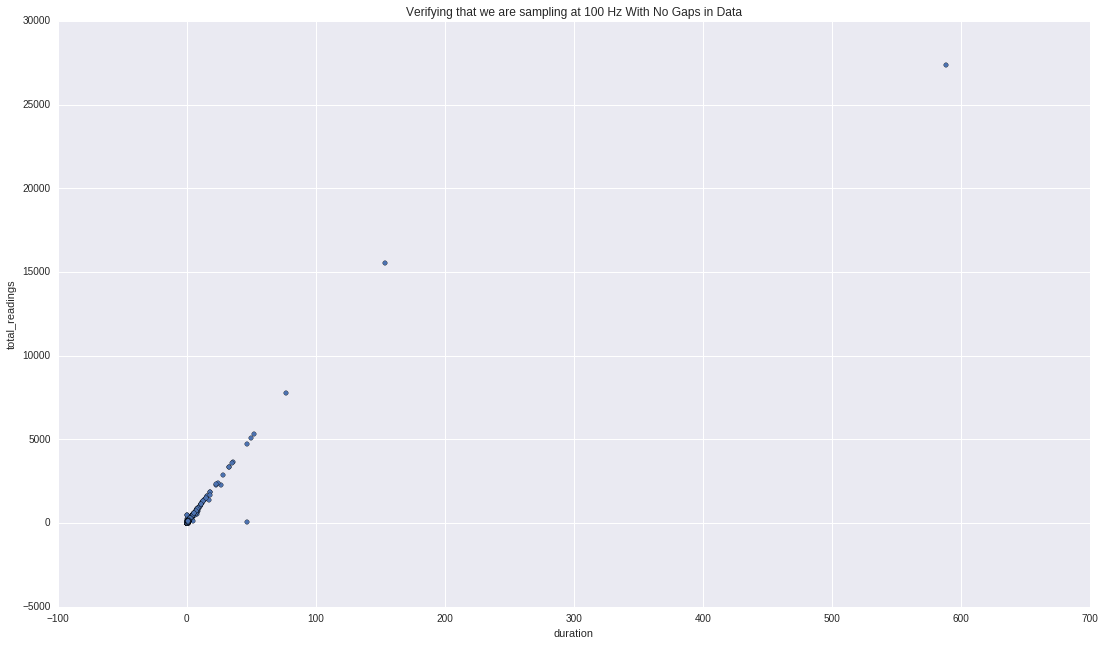

In [8]:
readings.plot(x='duration', y='total_readings', kind='scatter')
plt.title('Verifying that we are sampling at 100 Hz With No Gaps in Data')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

Checks out some random rides to make sure that our line segments line up and form a proper route, since there are some concerns that GPS data is a bit noisy for this!

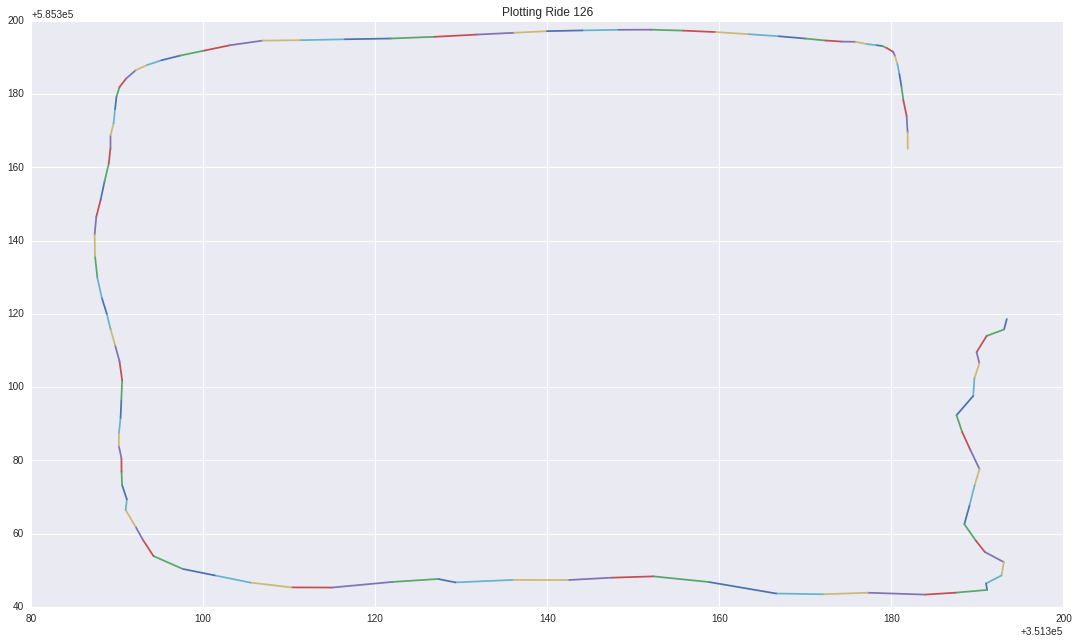

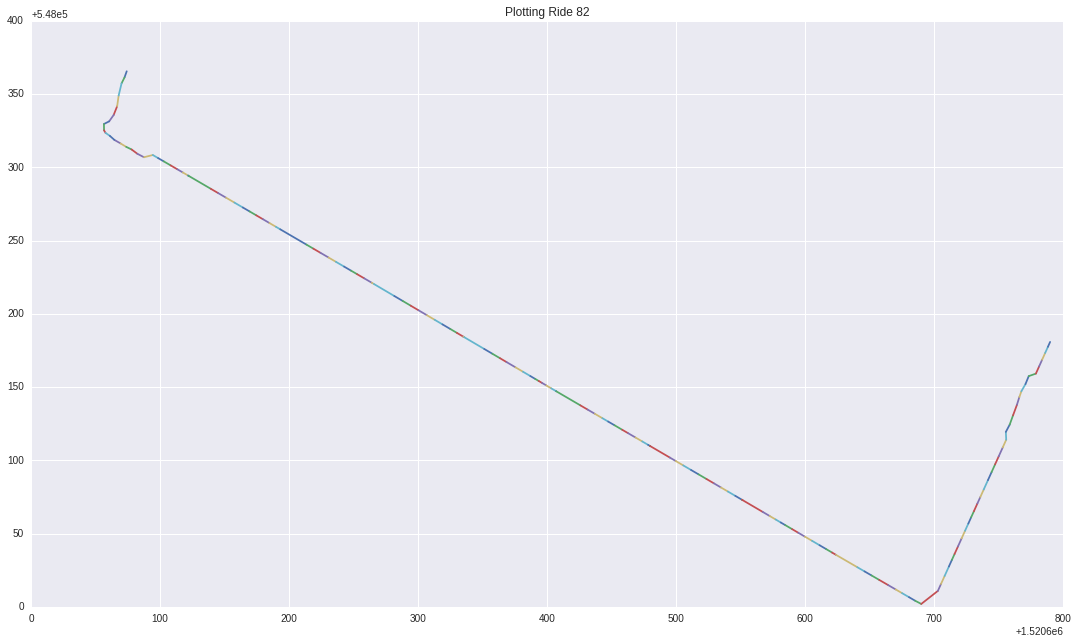

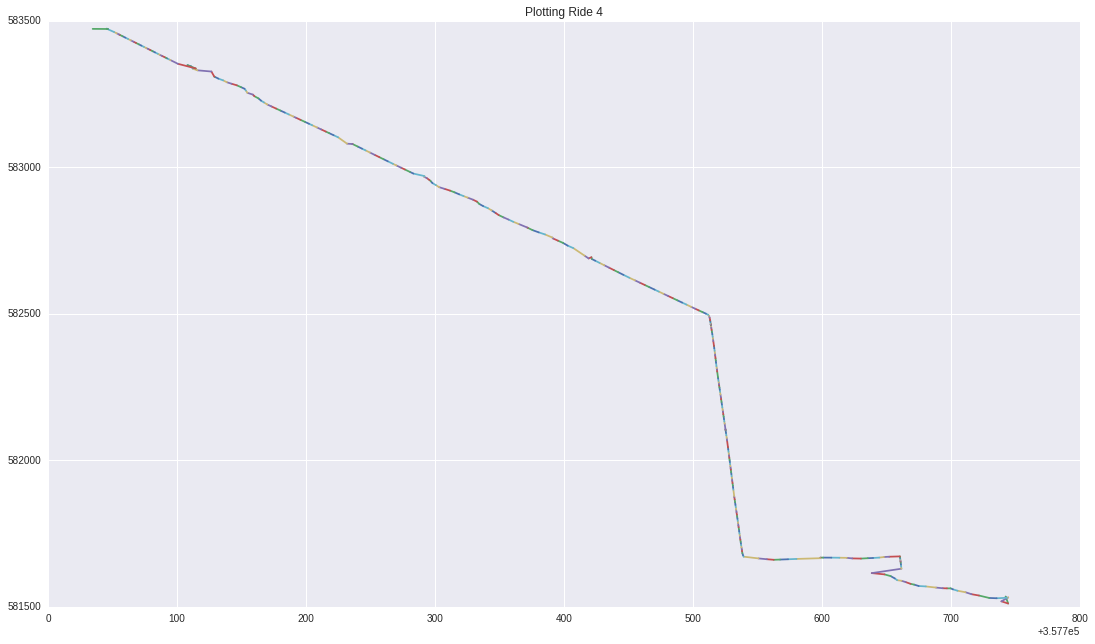

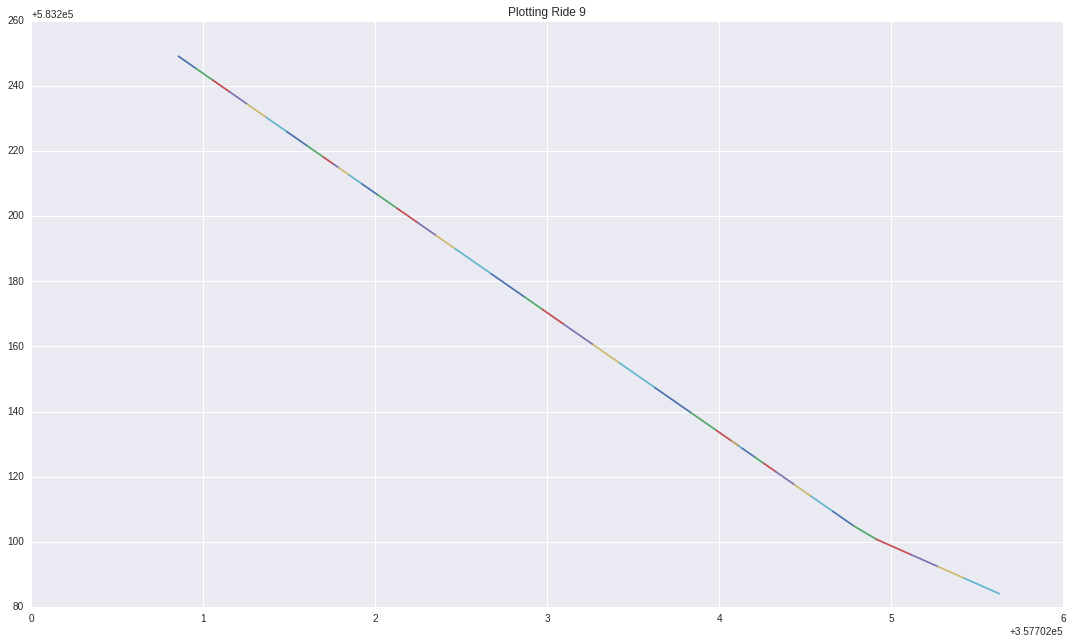

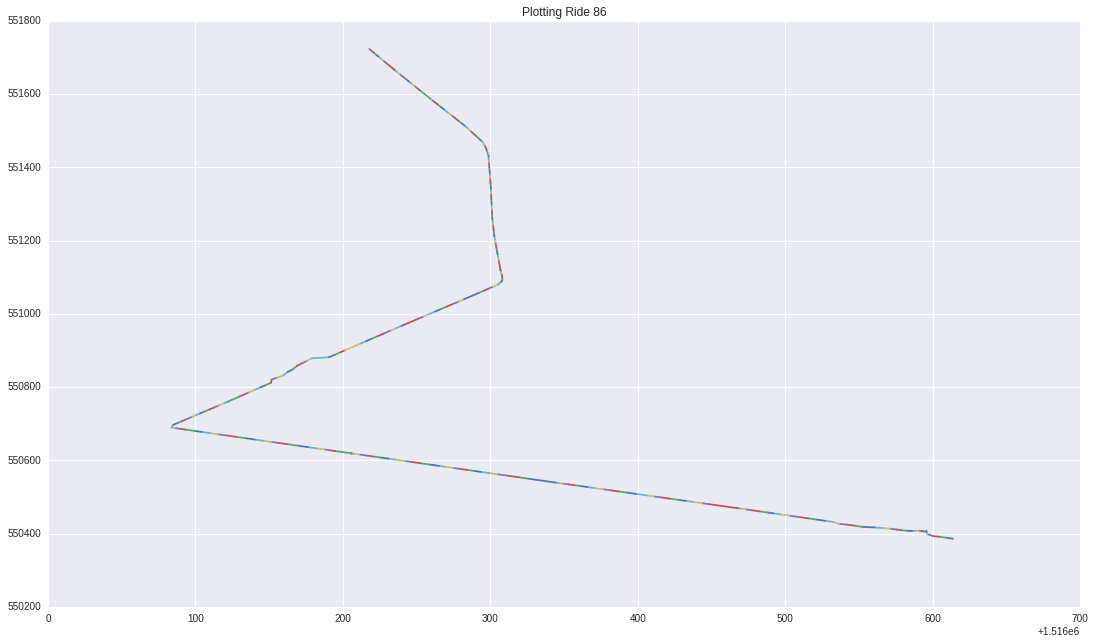

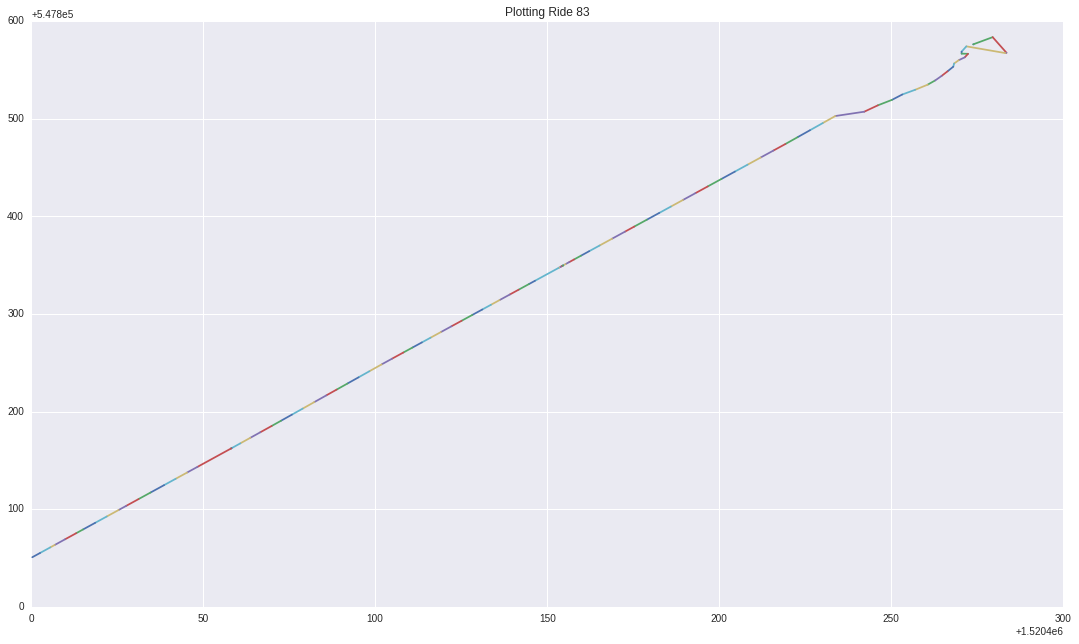

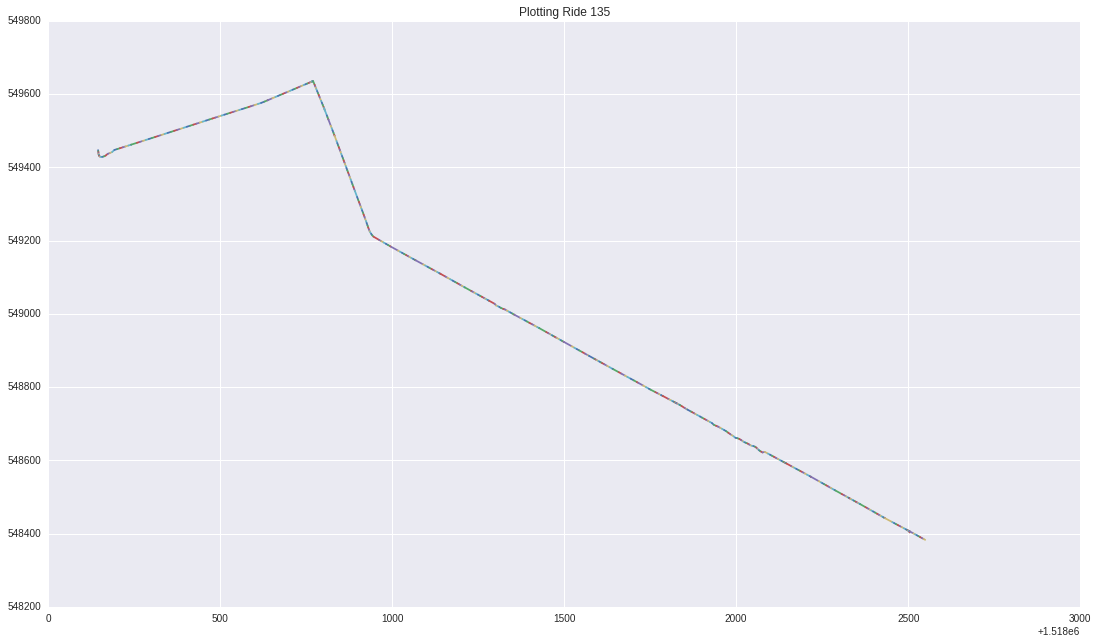

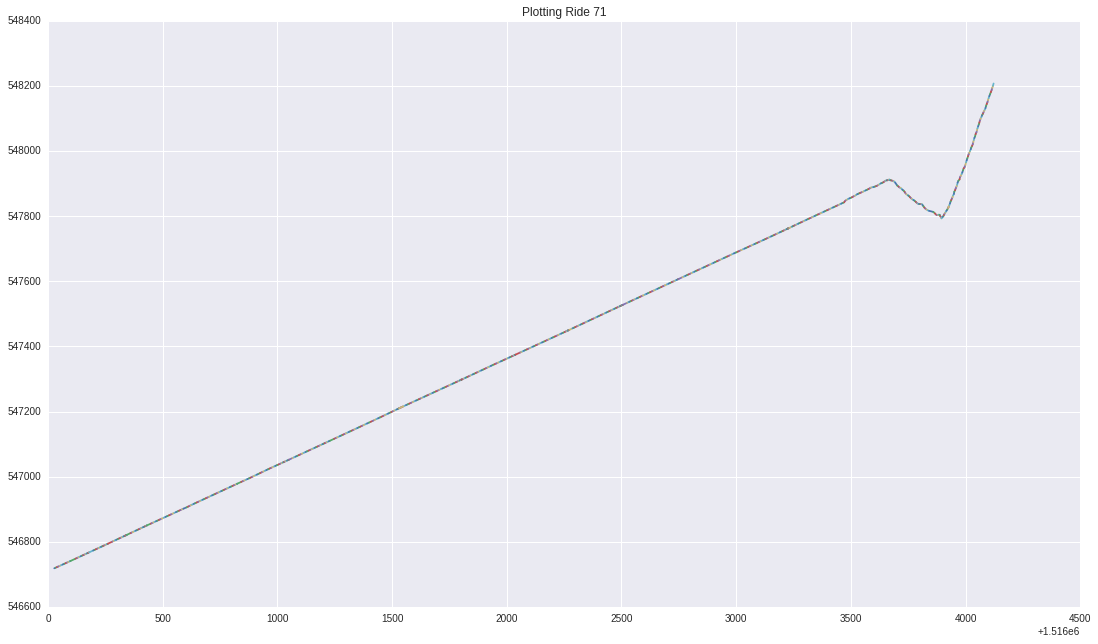

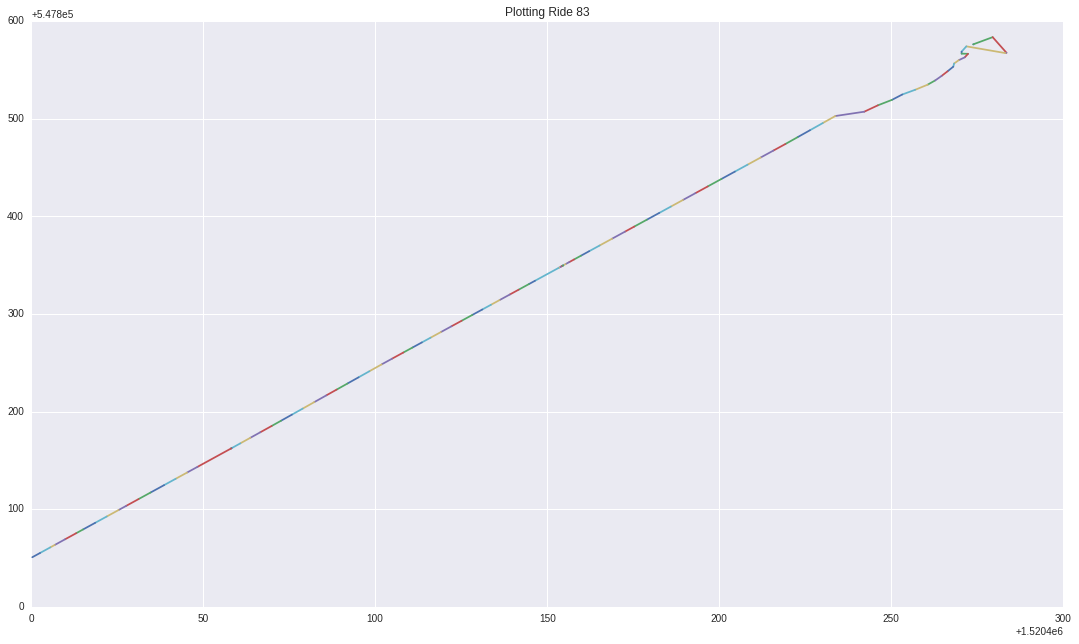

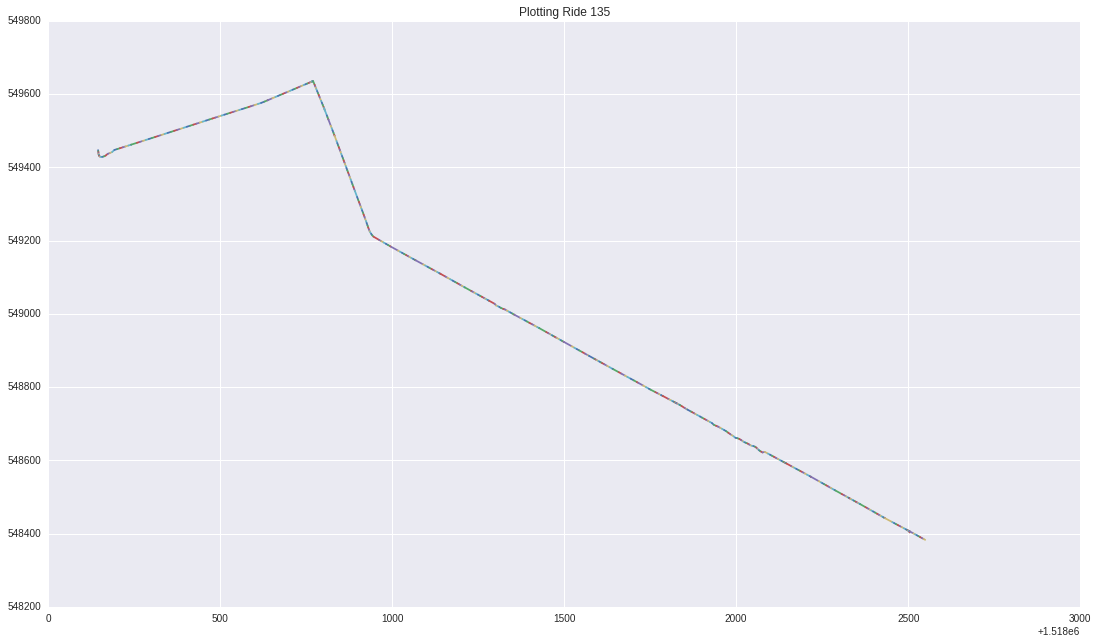

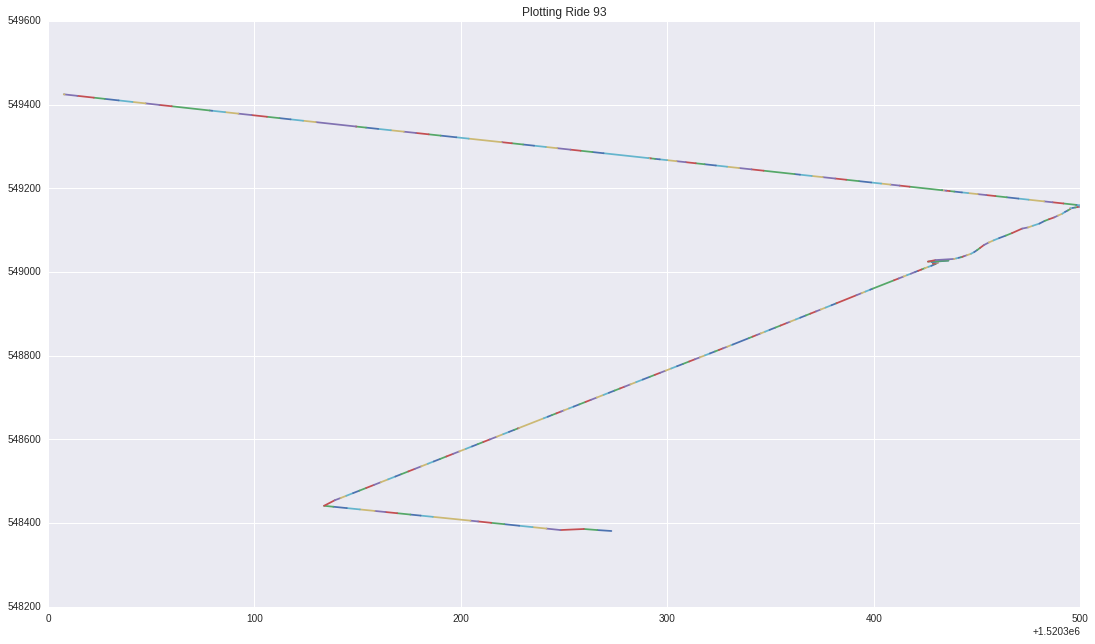

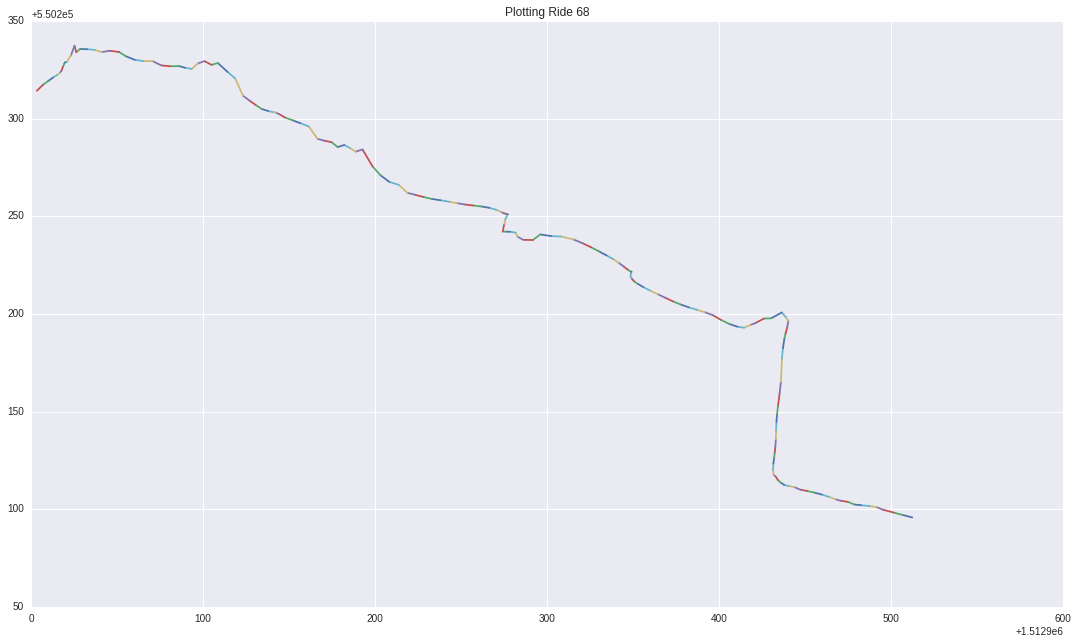

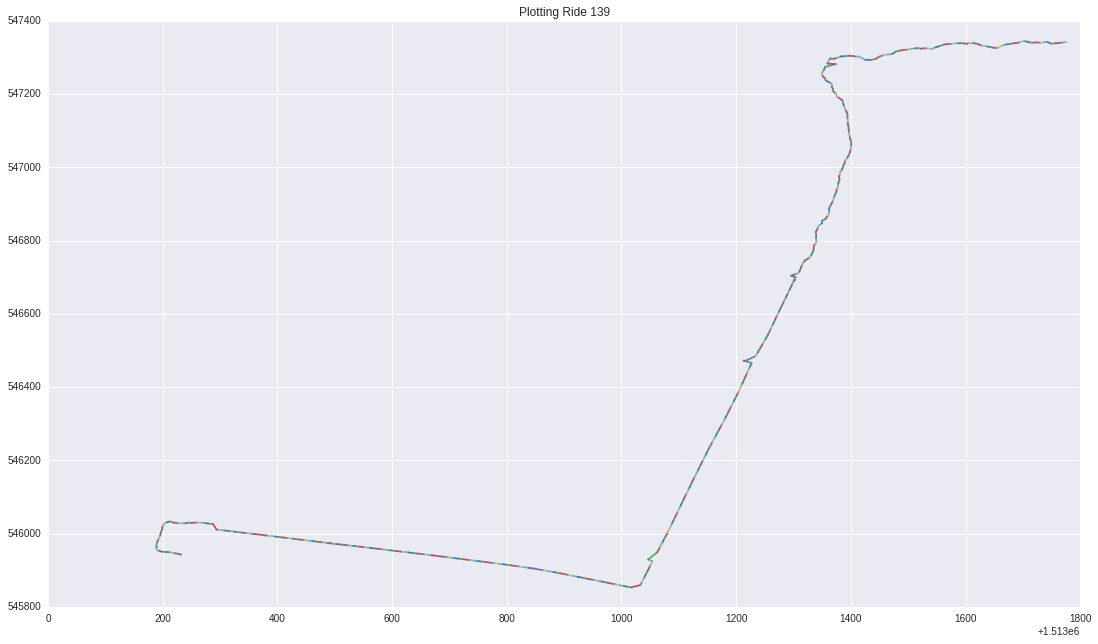

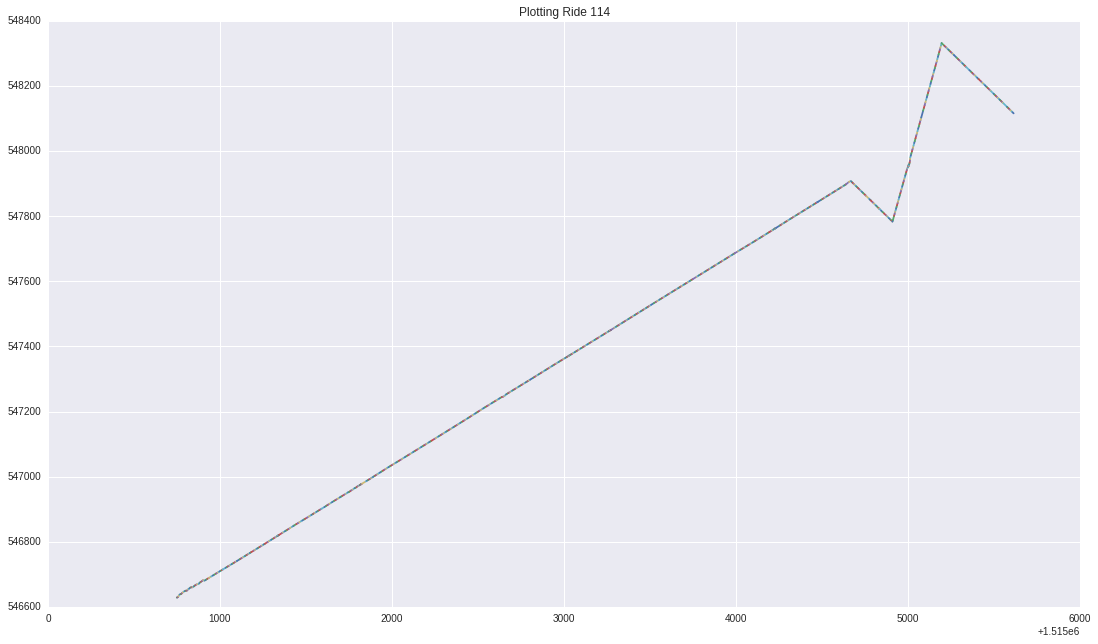

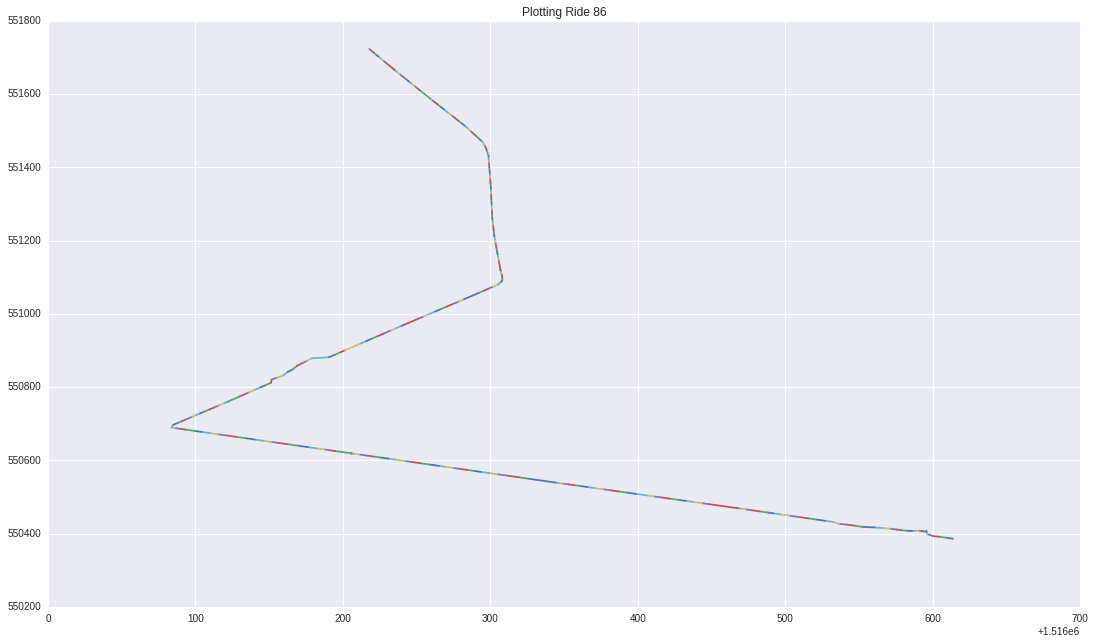

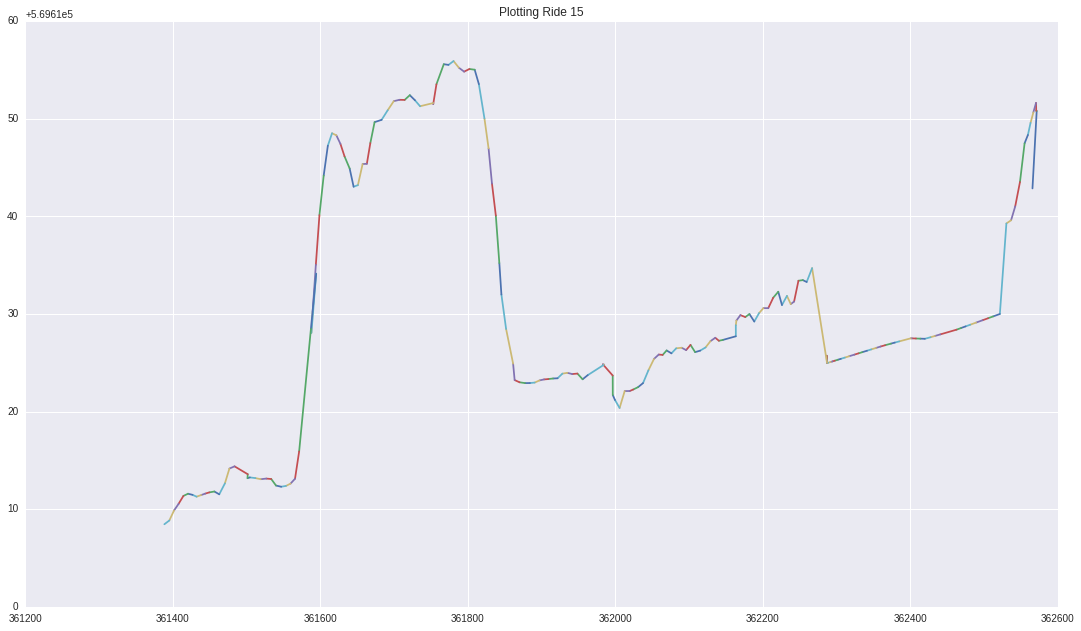

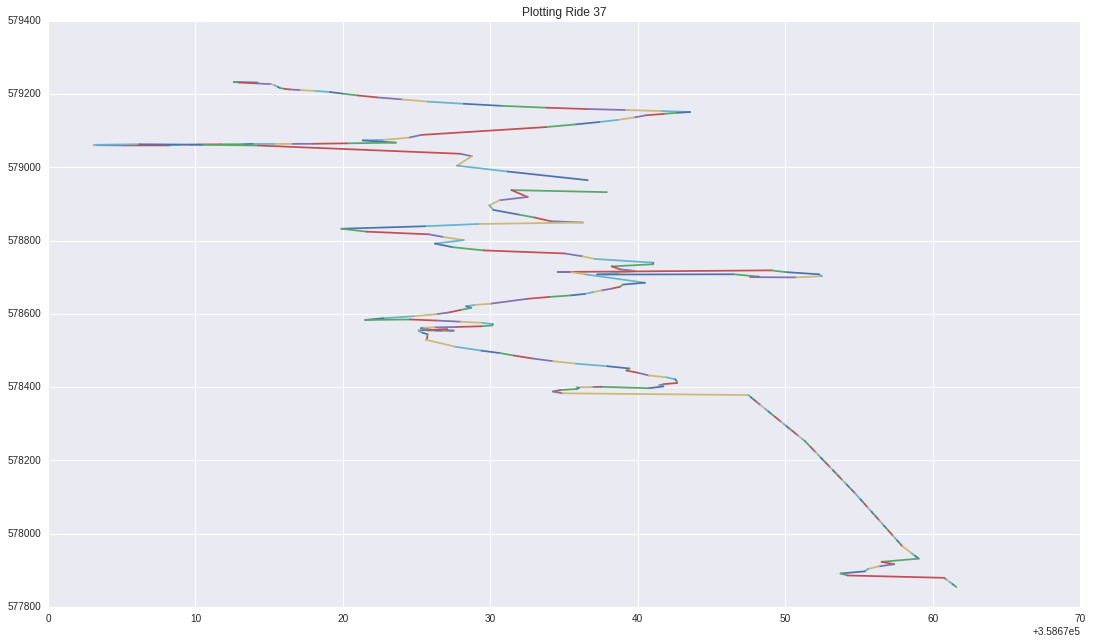

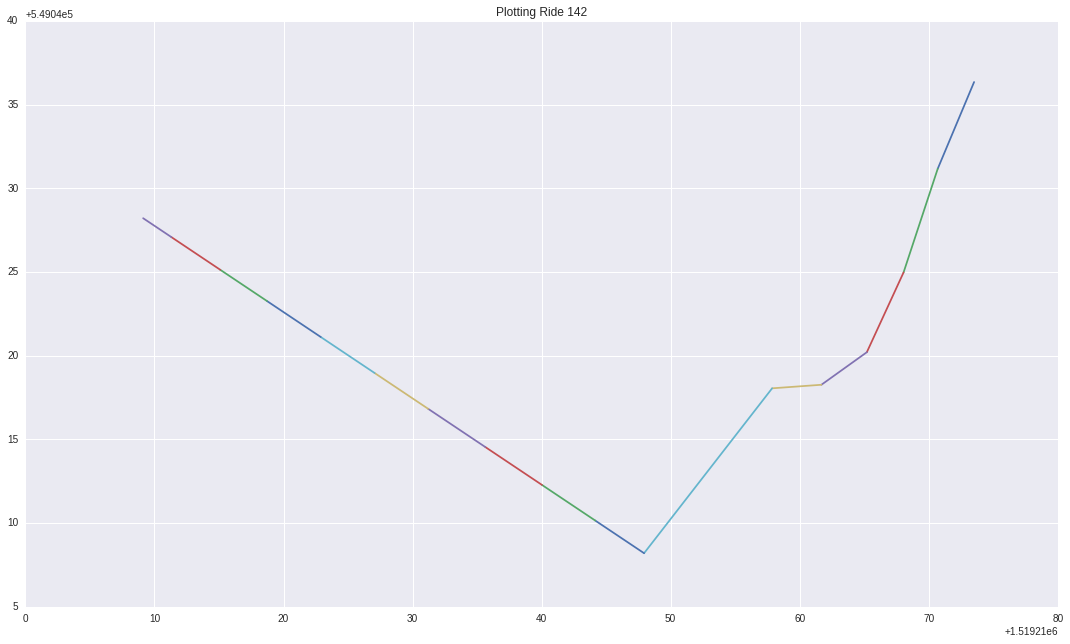

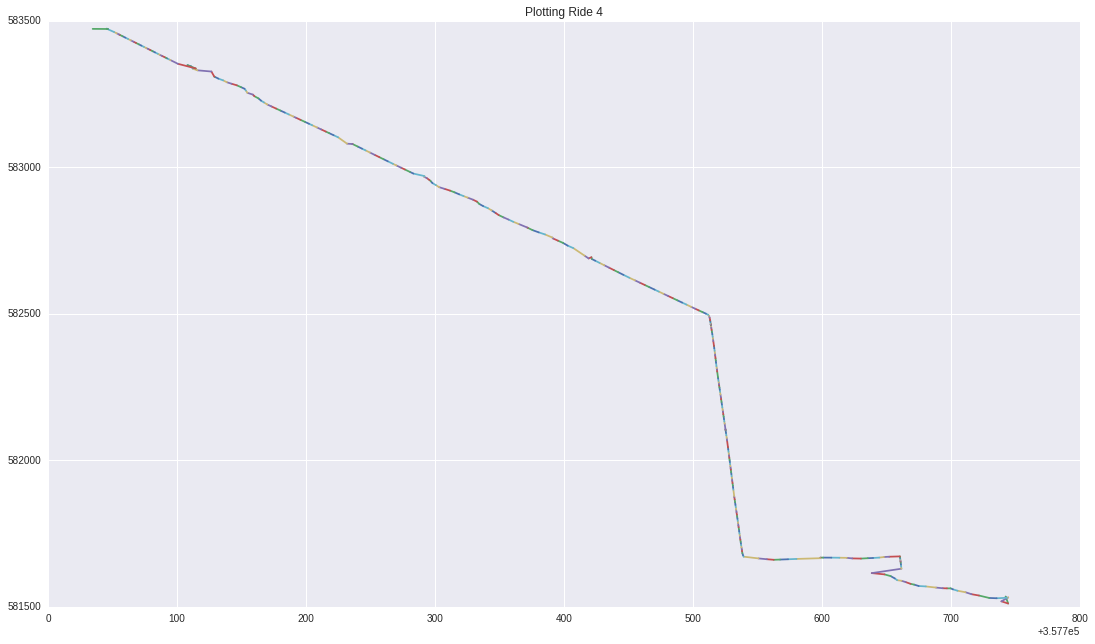

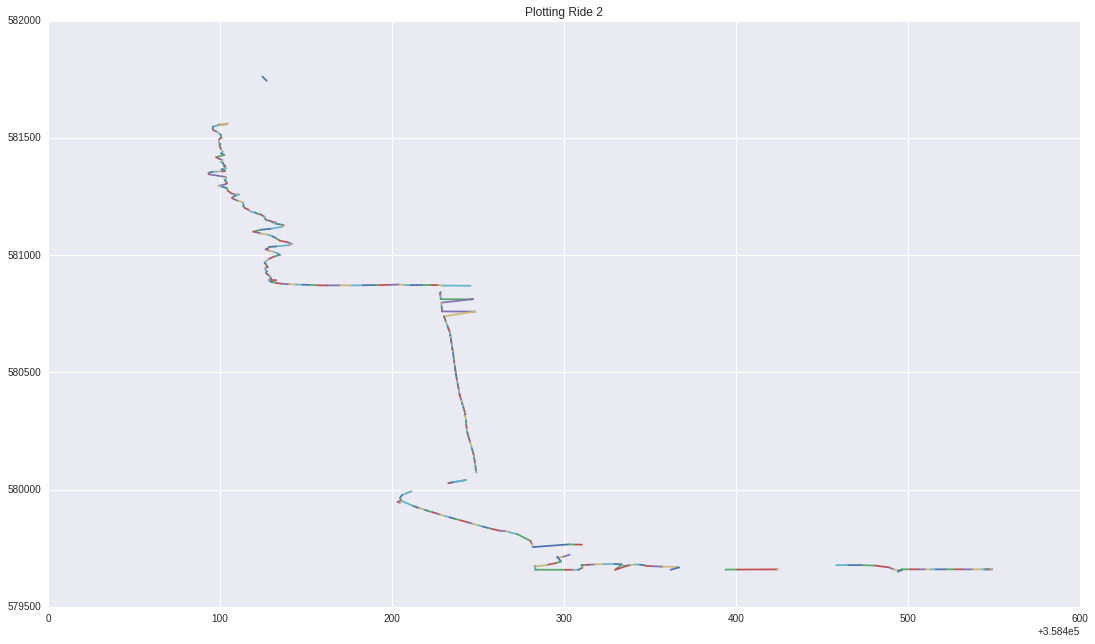

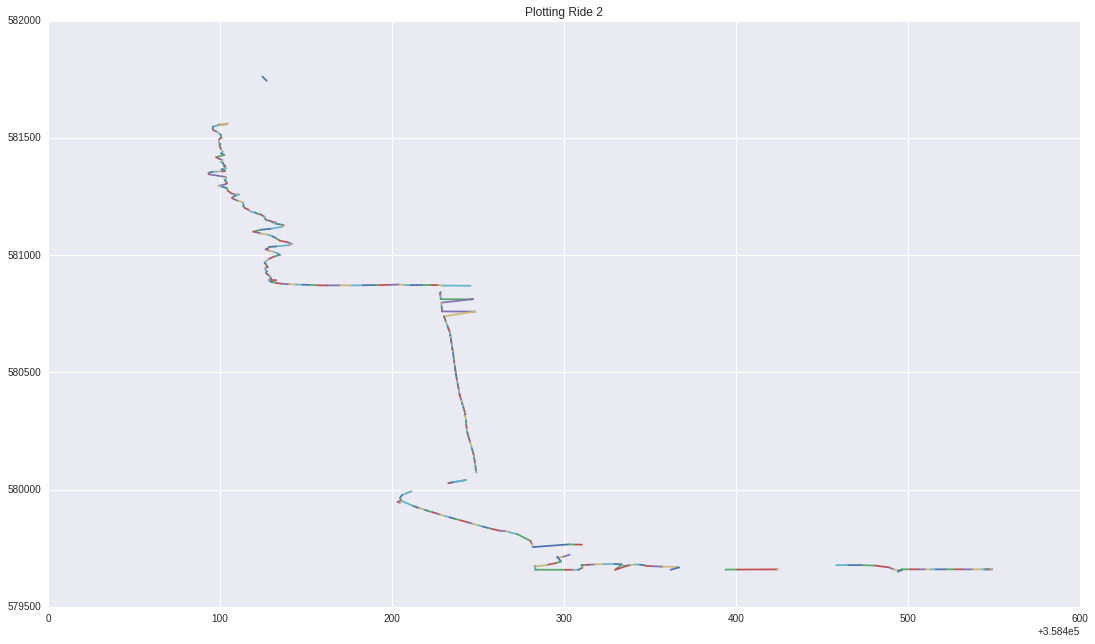

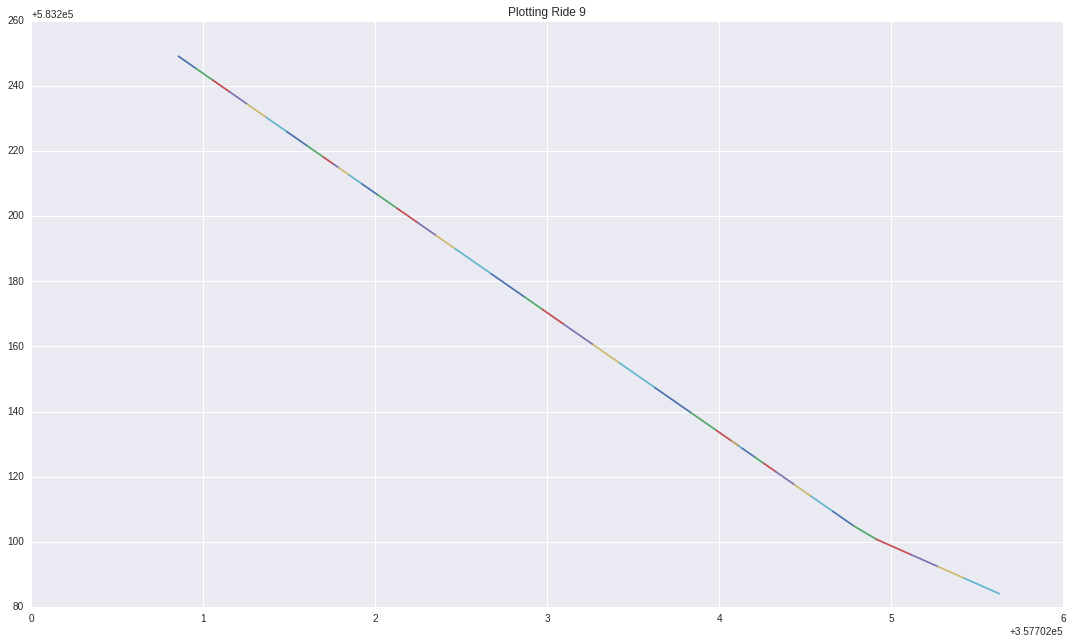

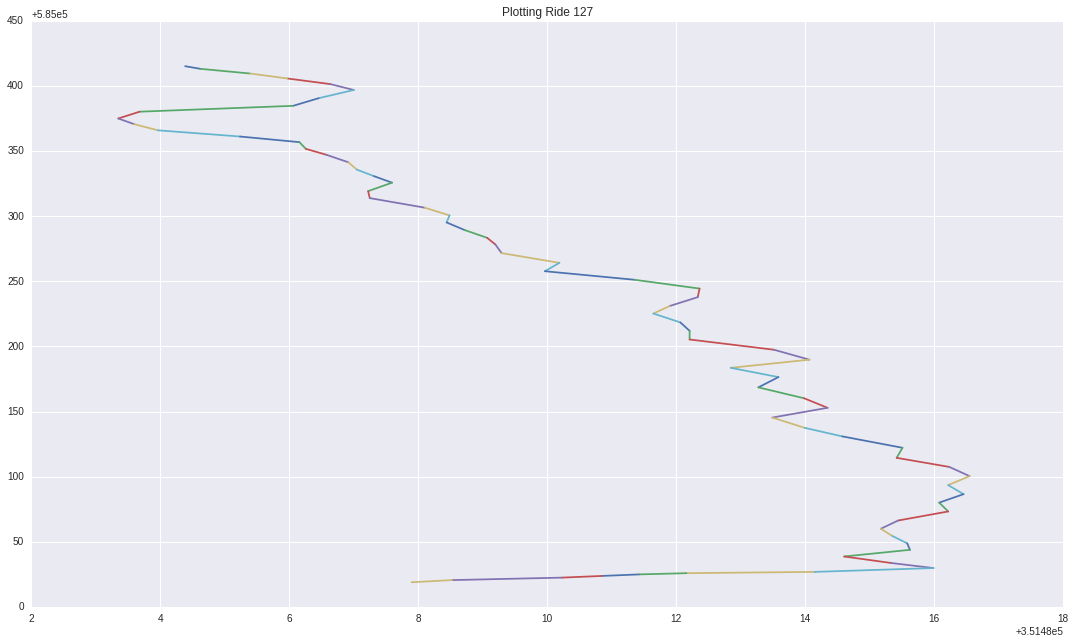

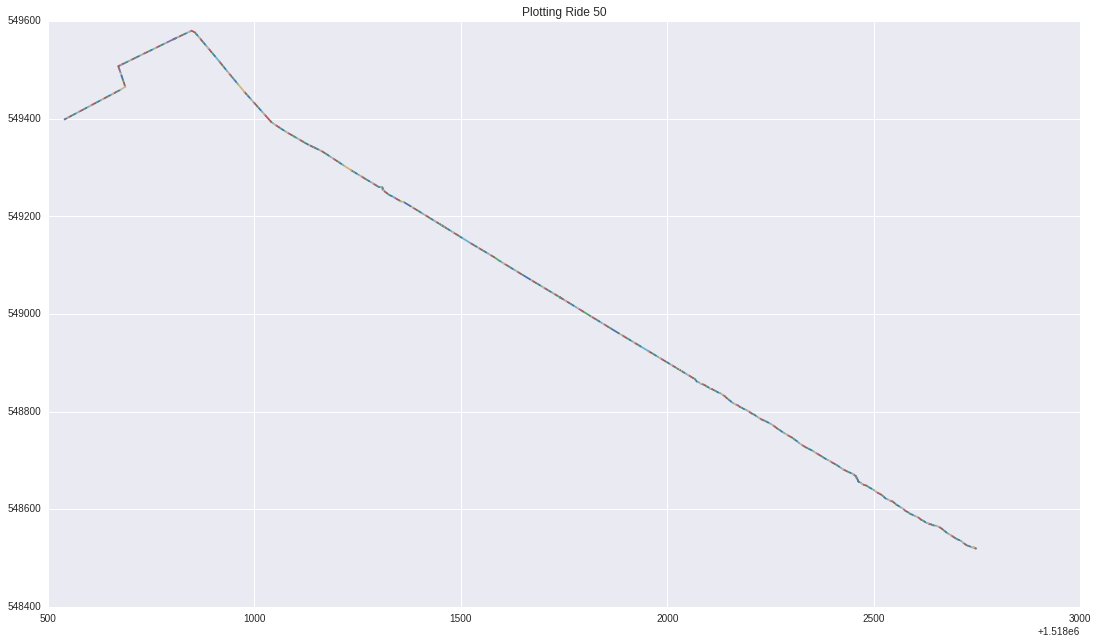

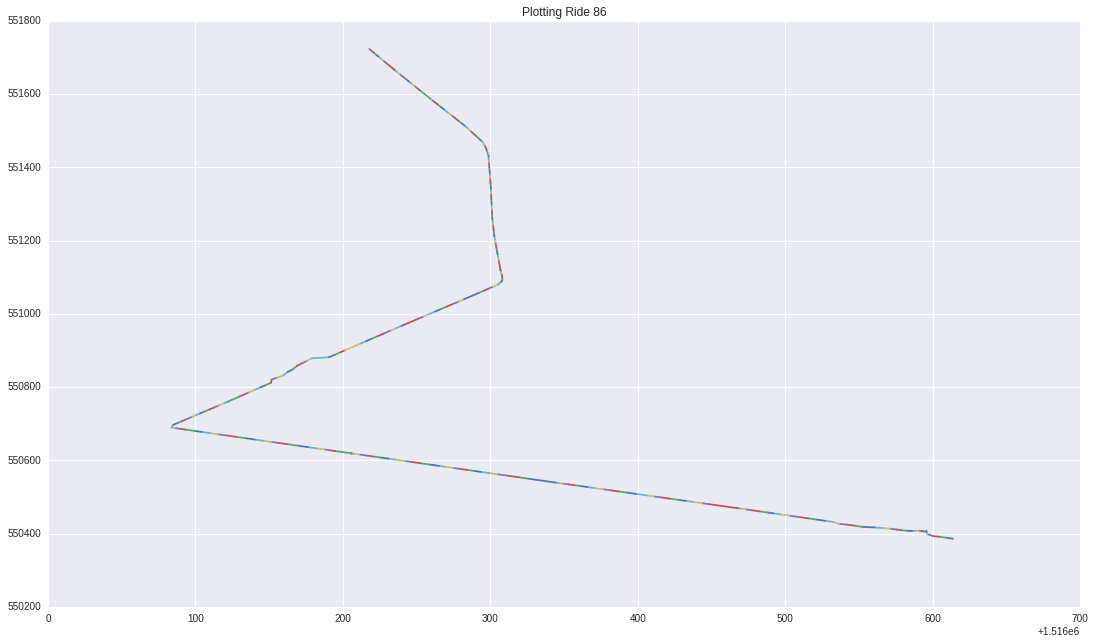

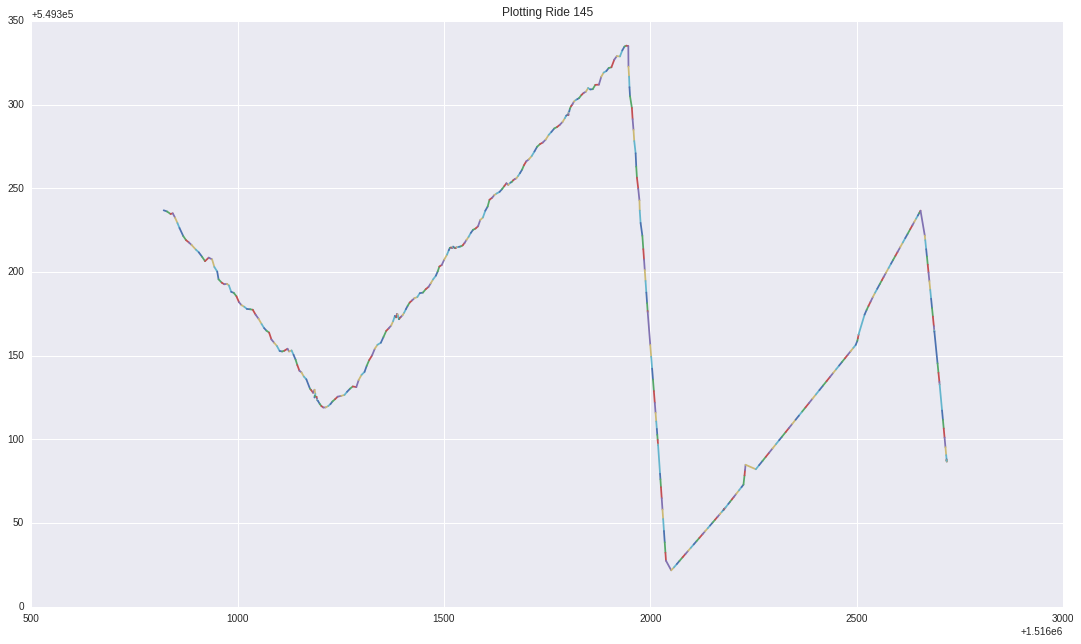

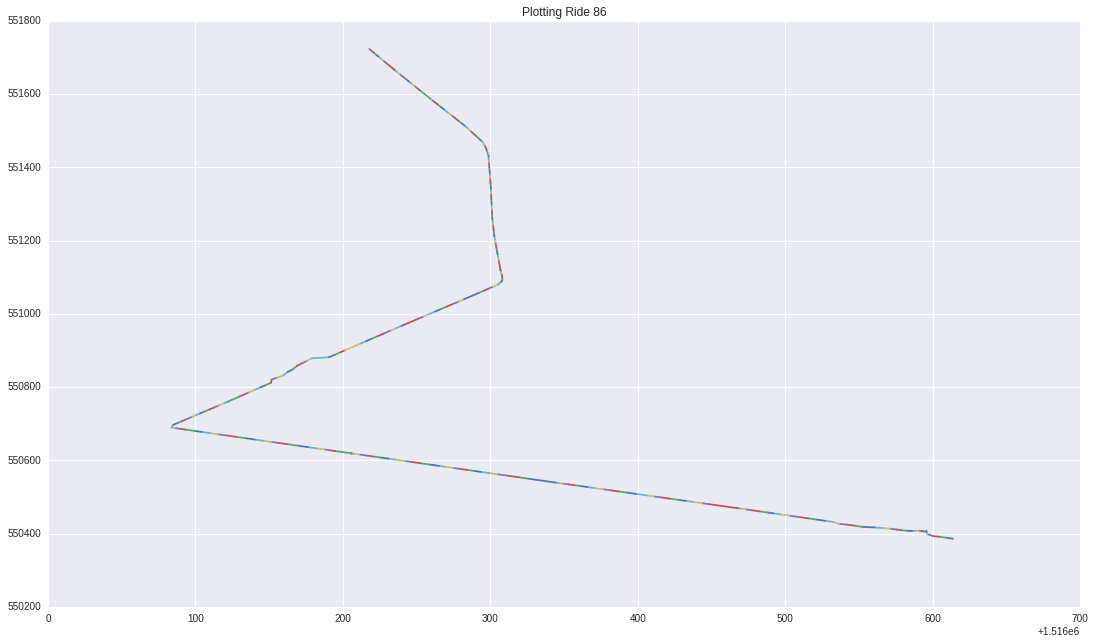

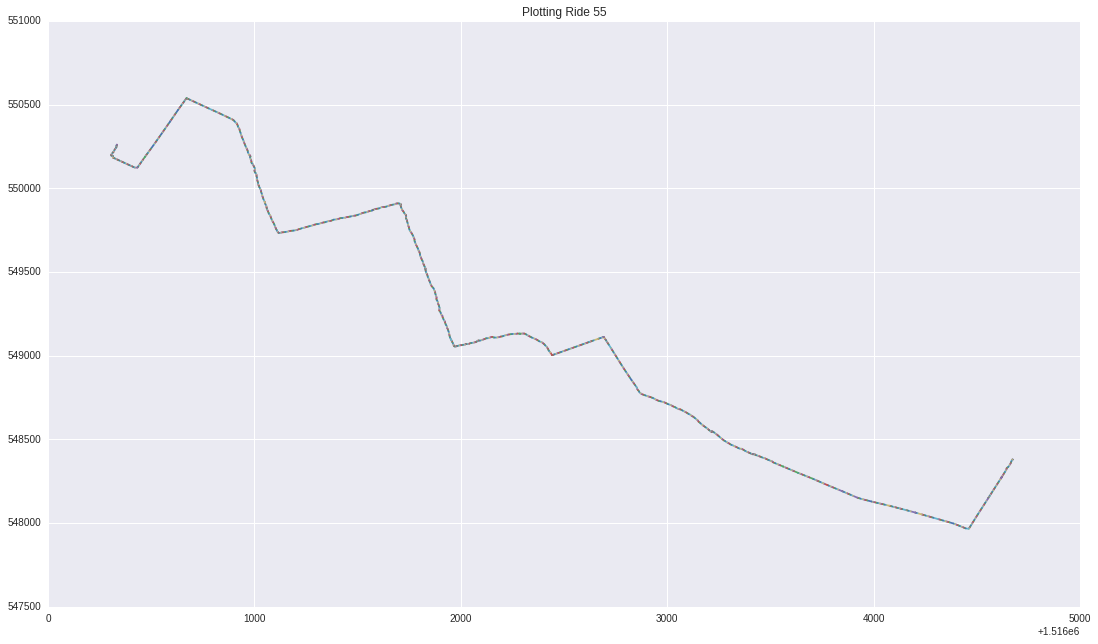

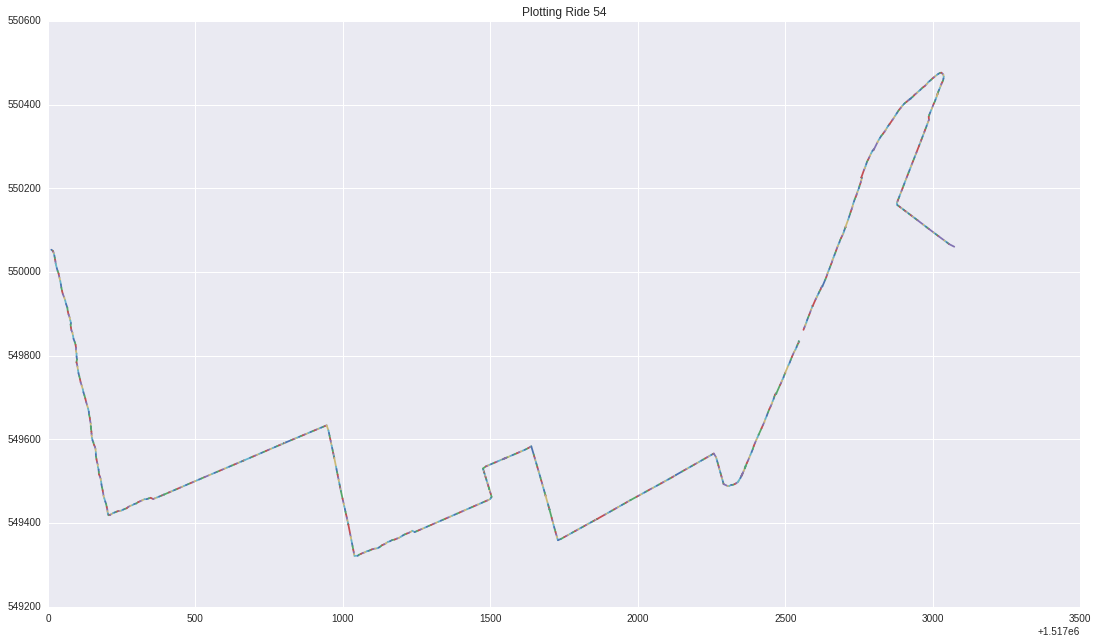

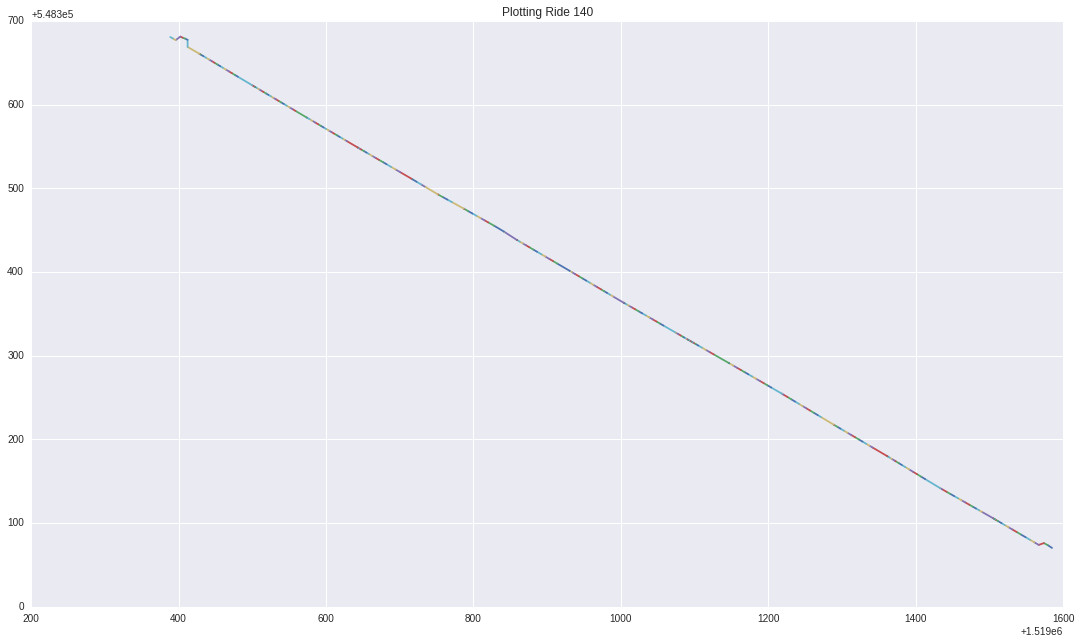

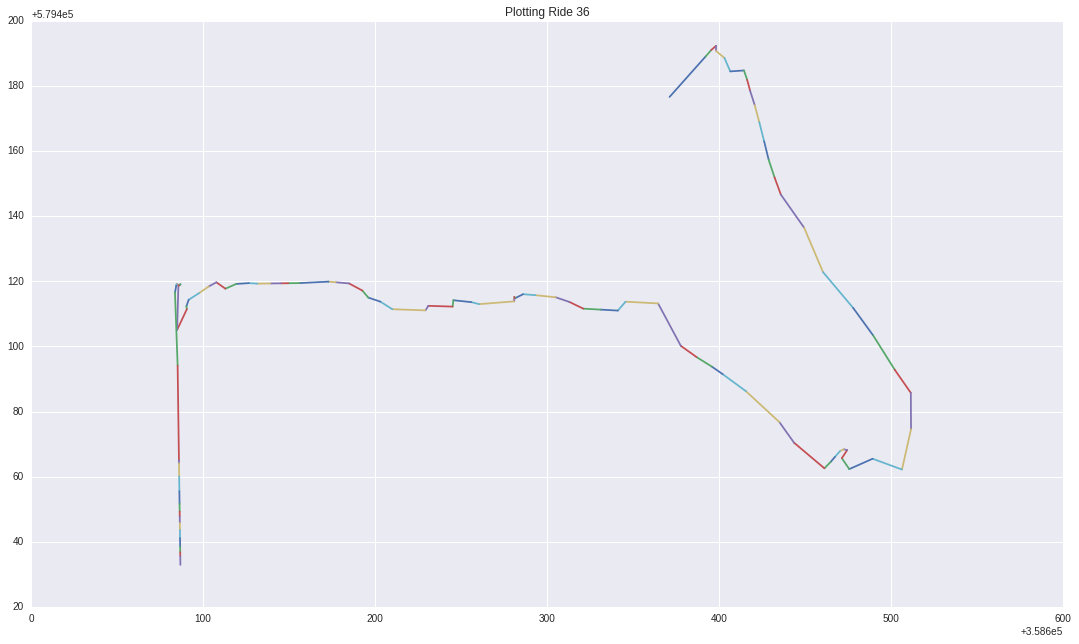

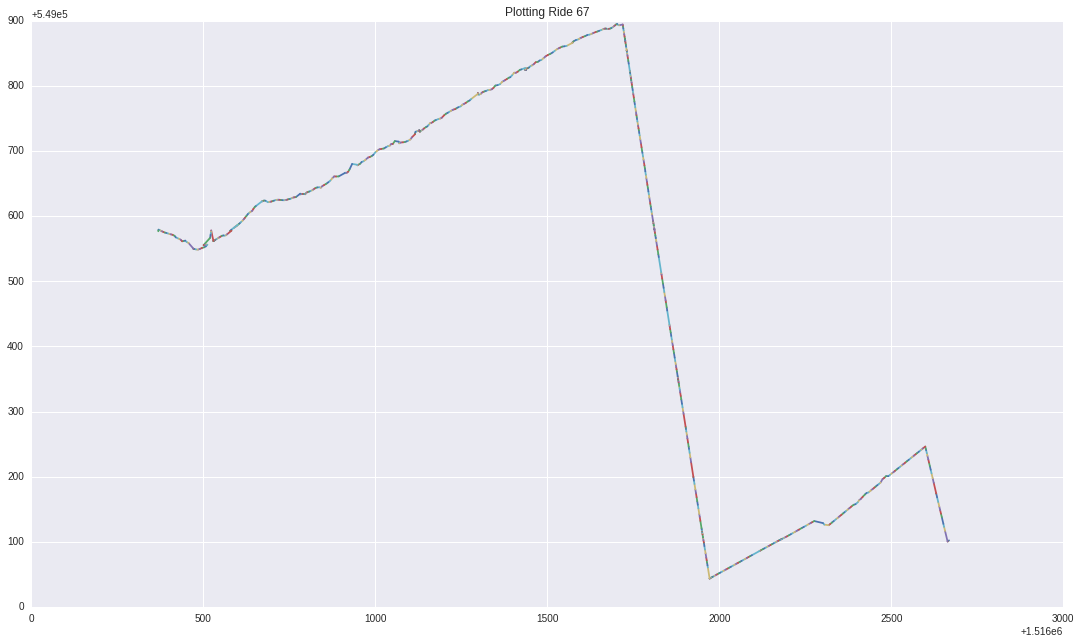

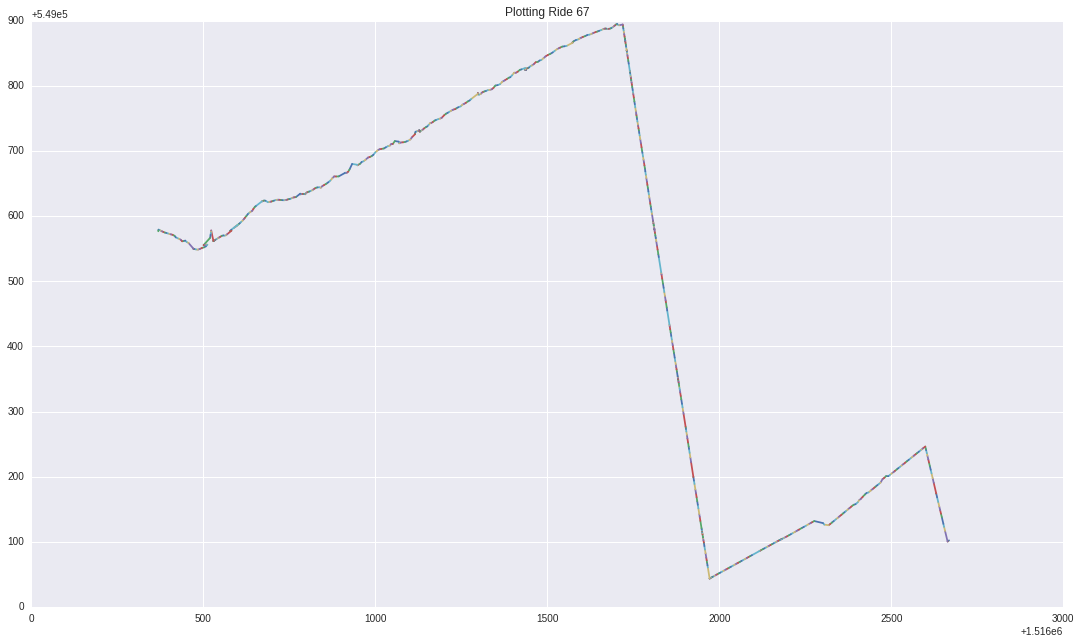

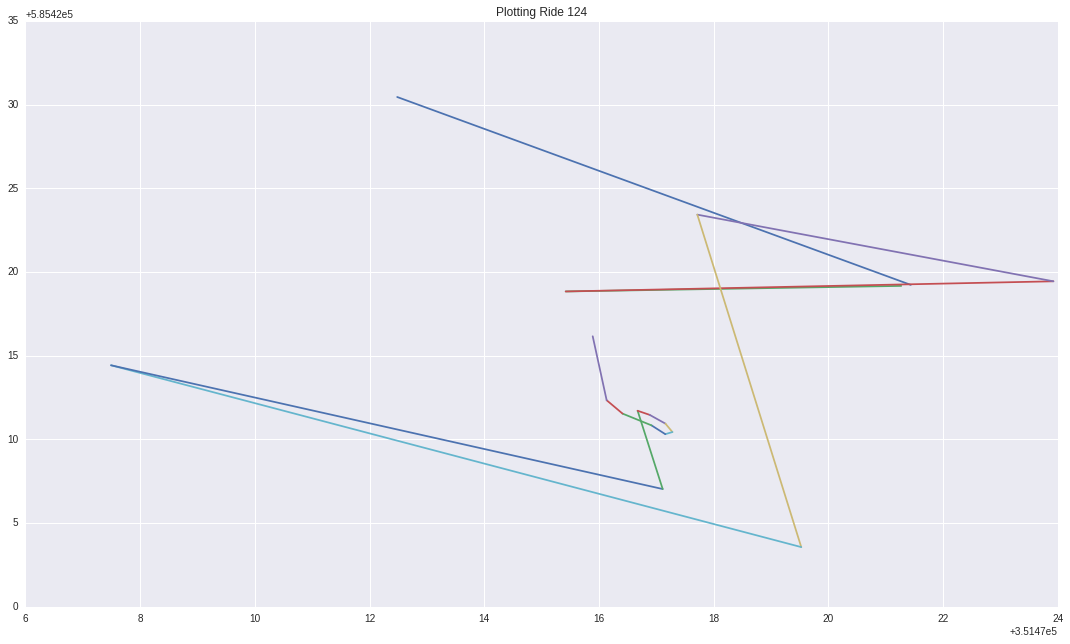

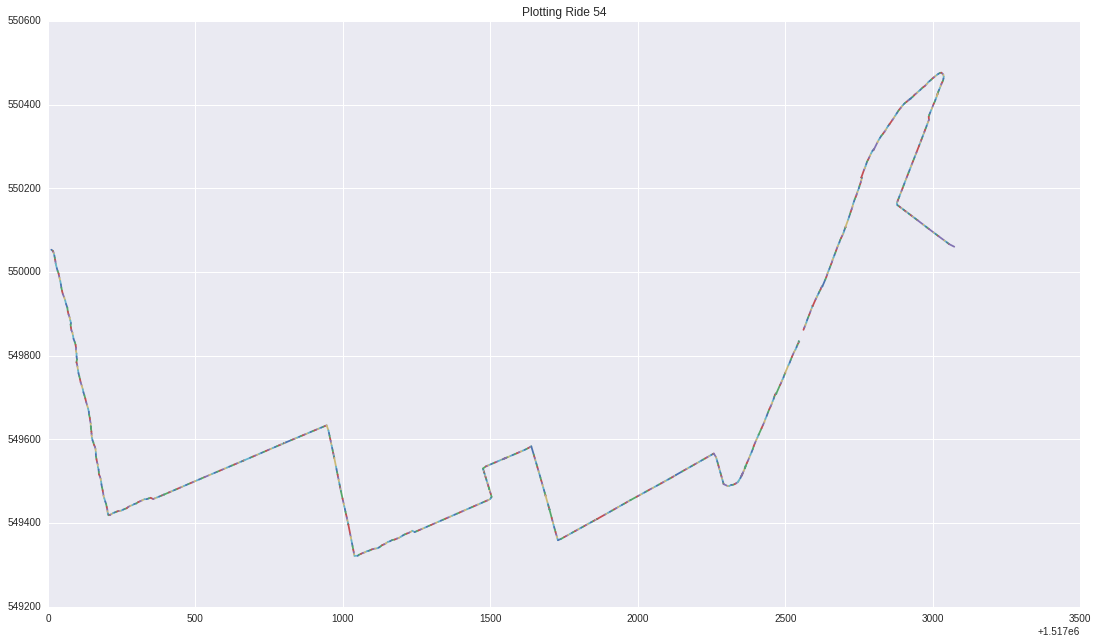

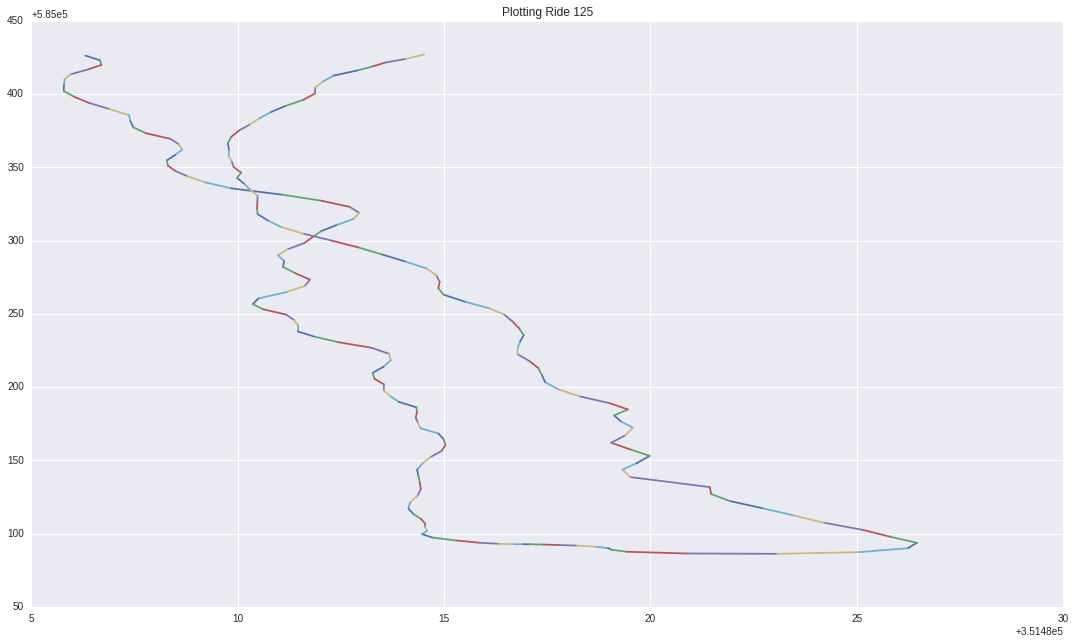

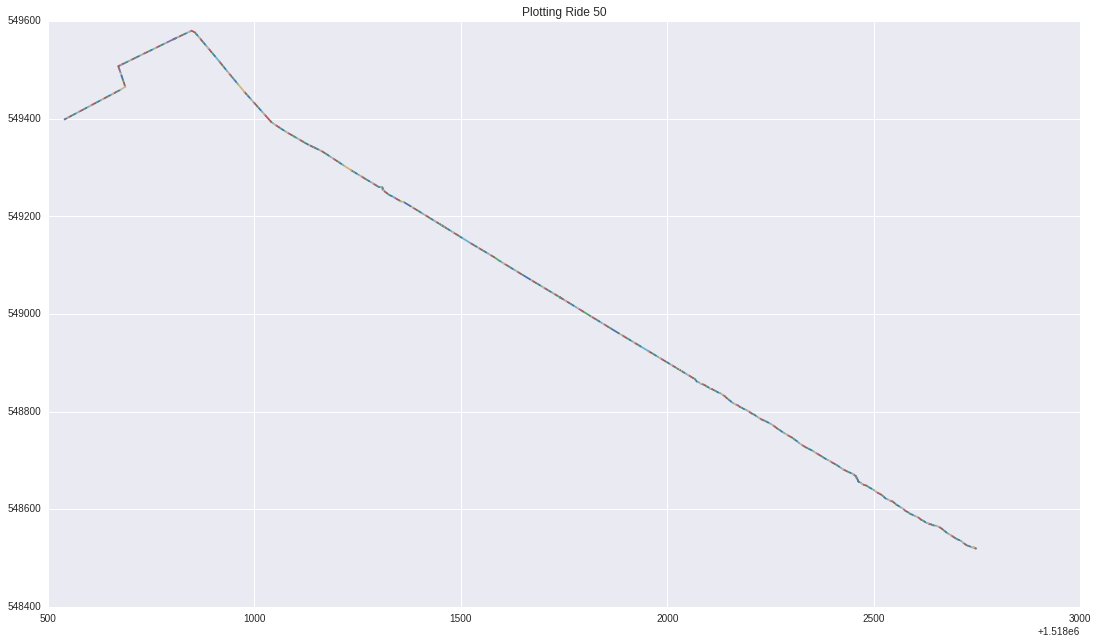

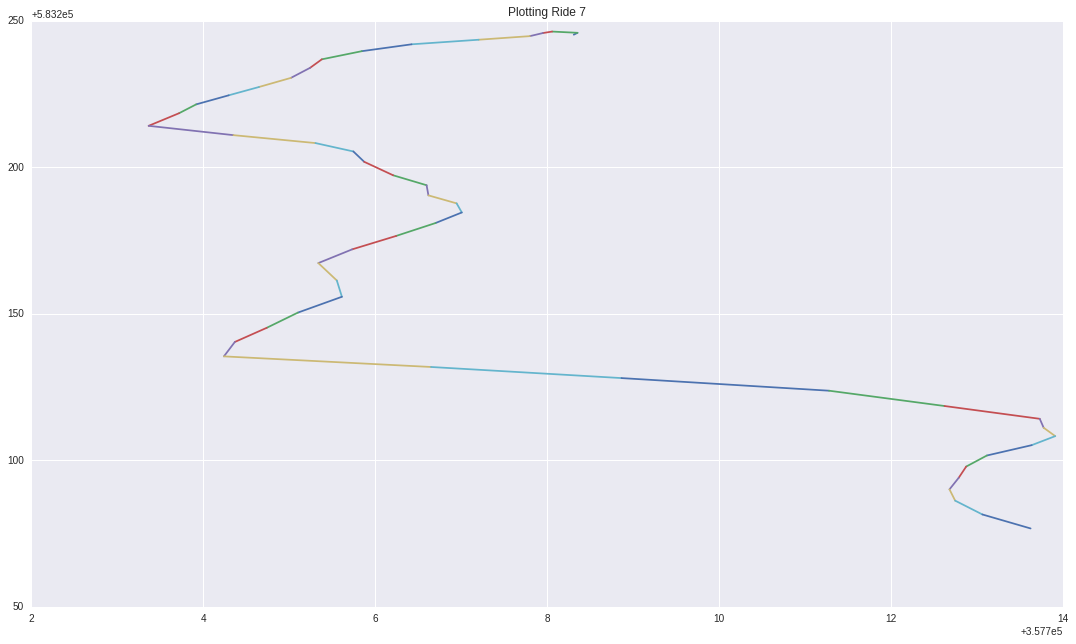

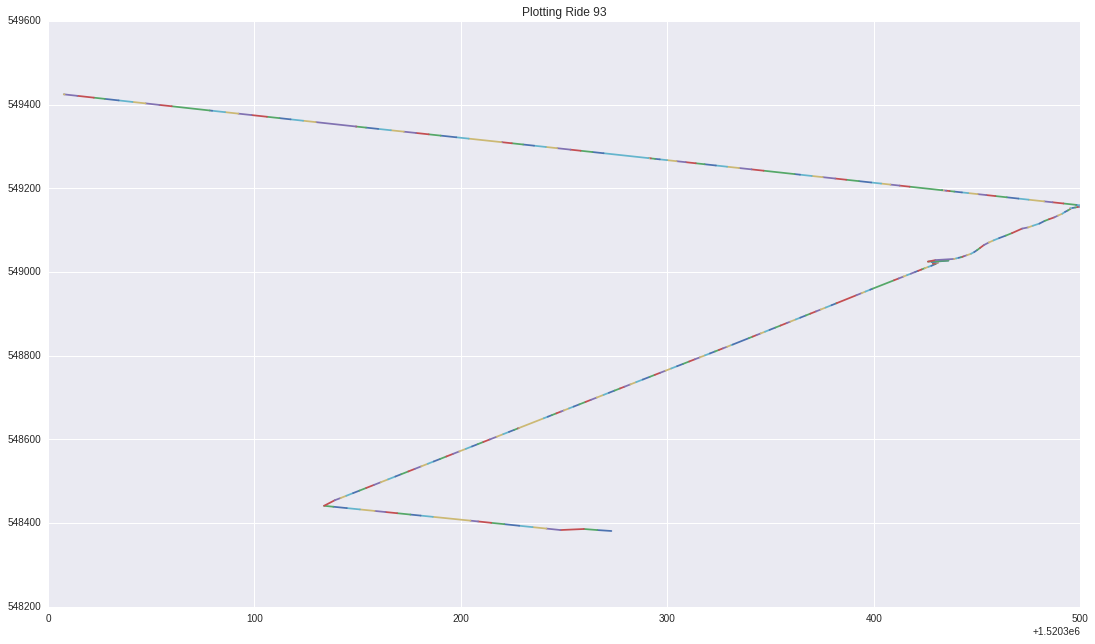

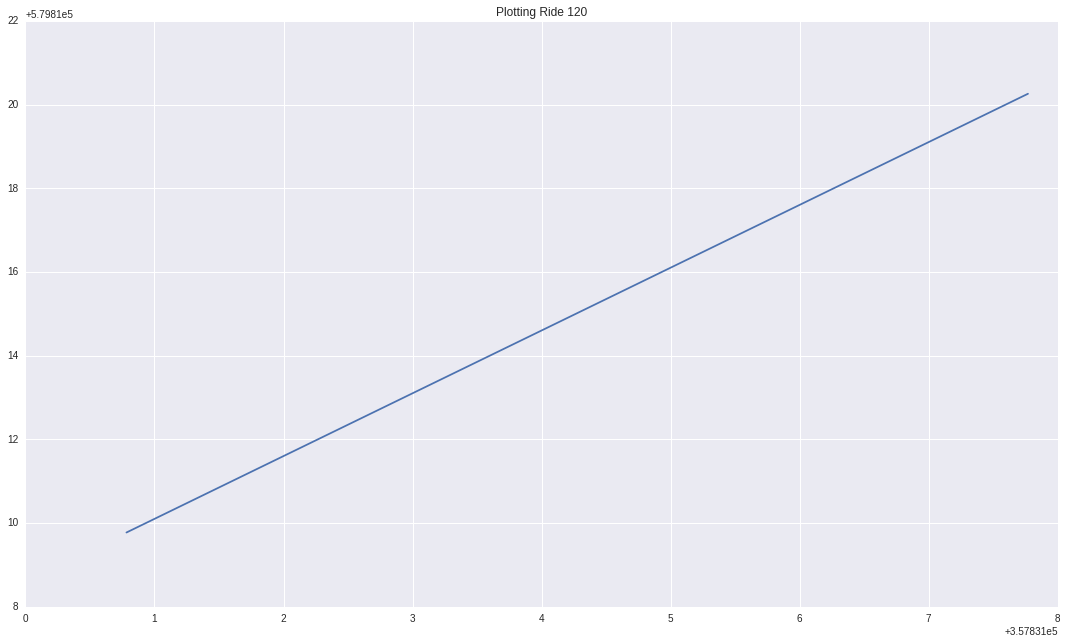

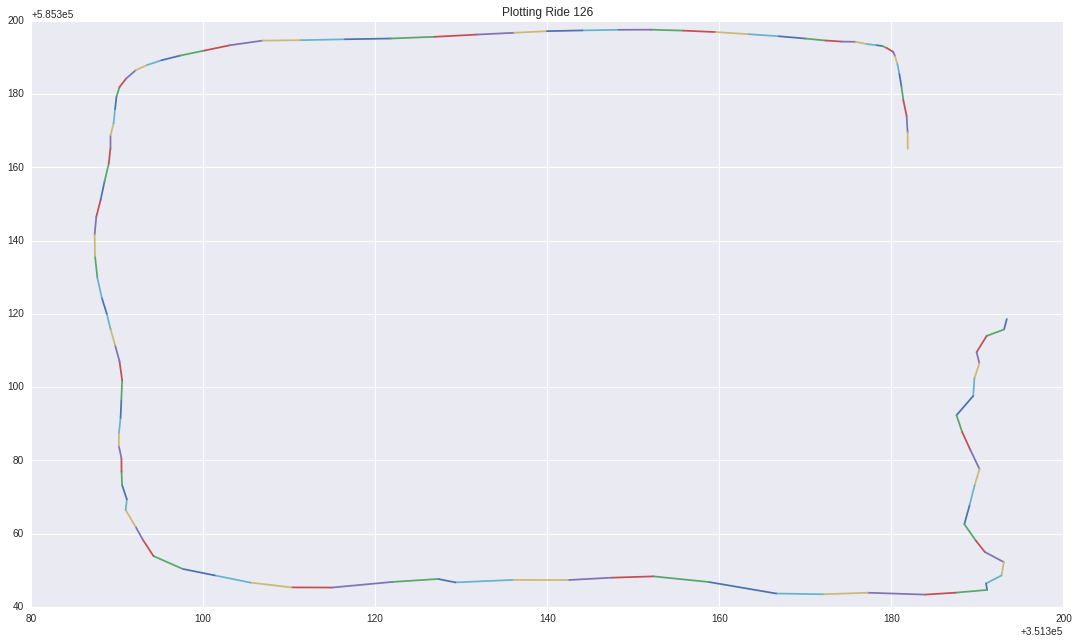

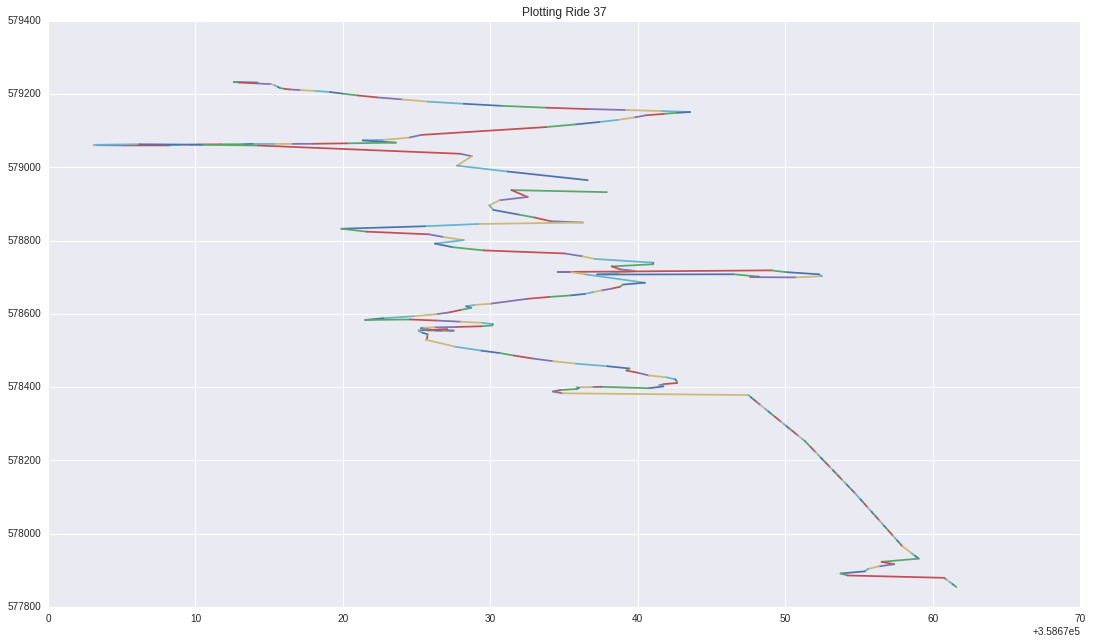

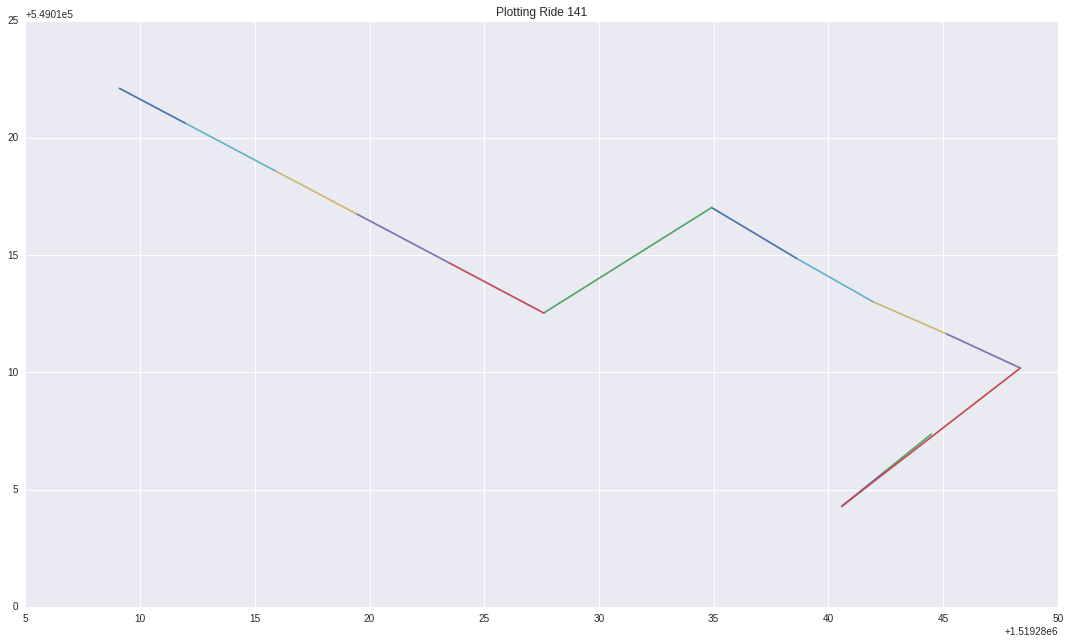

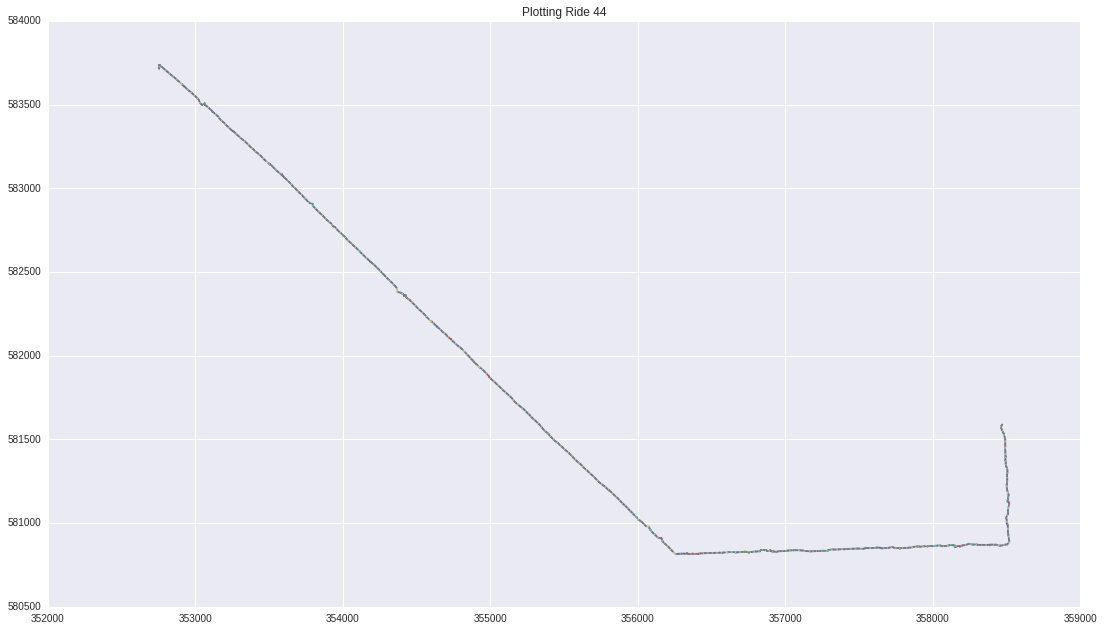

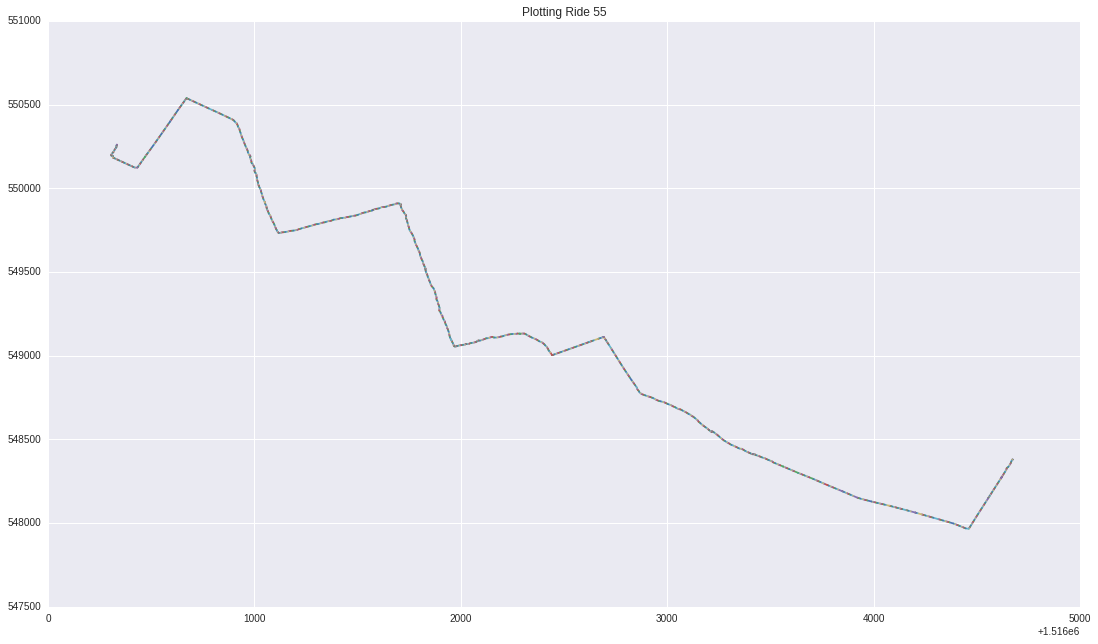

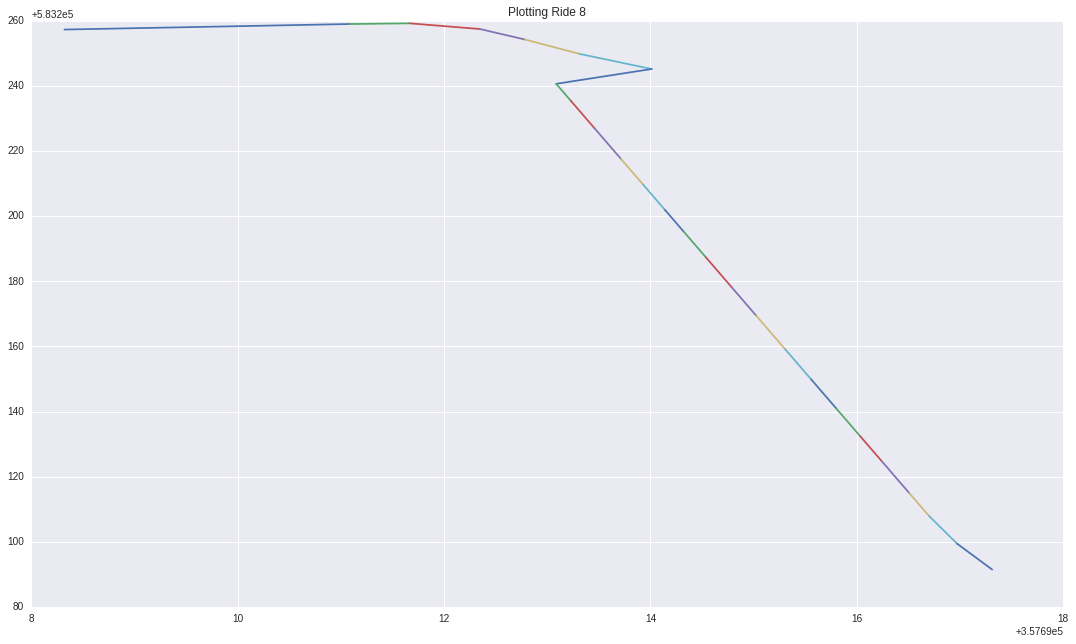

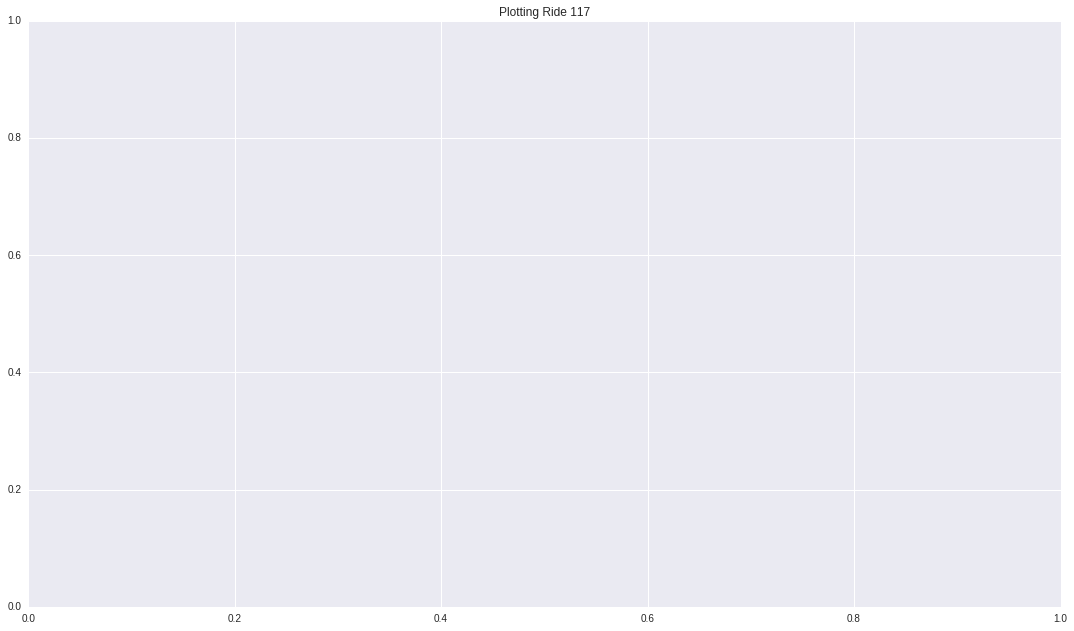

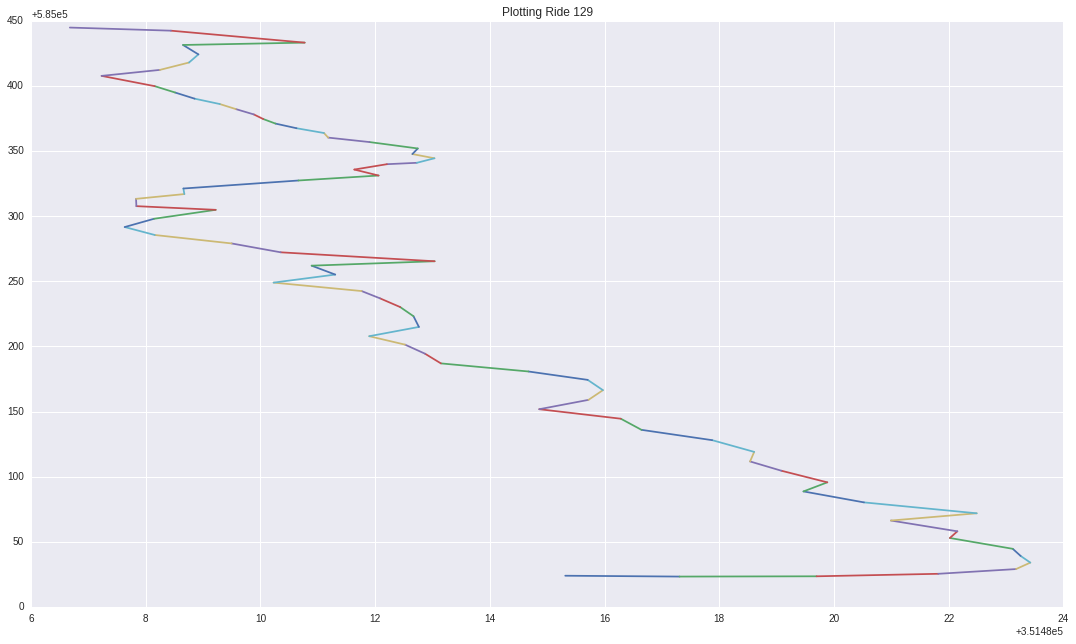

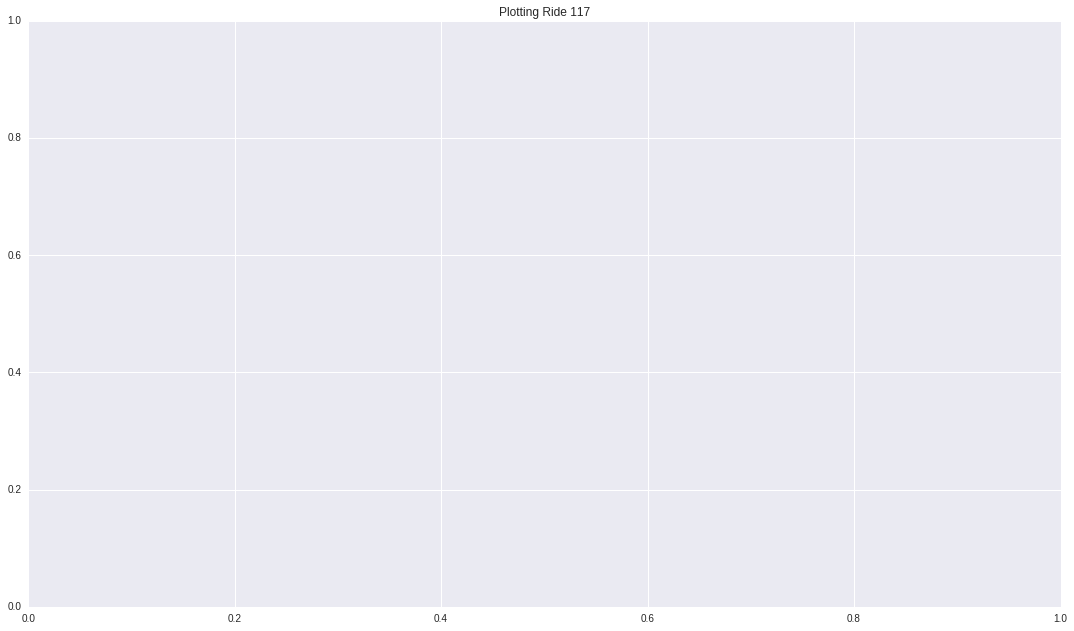

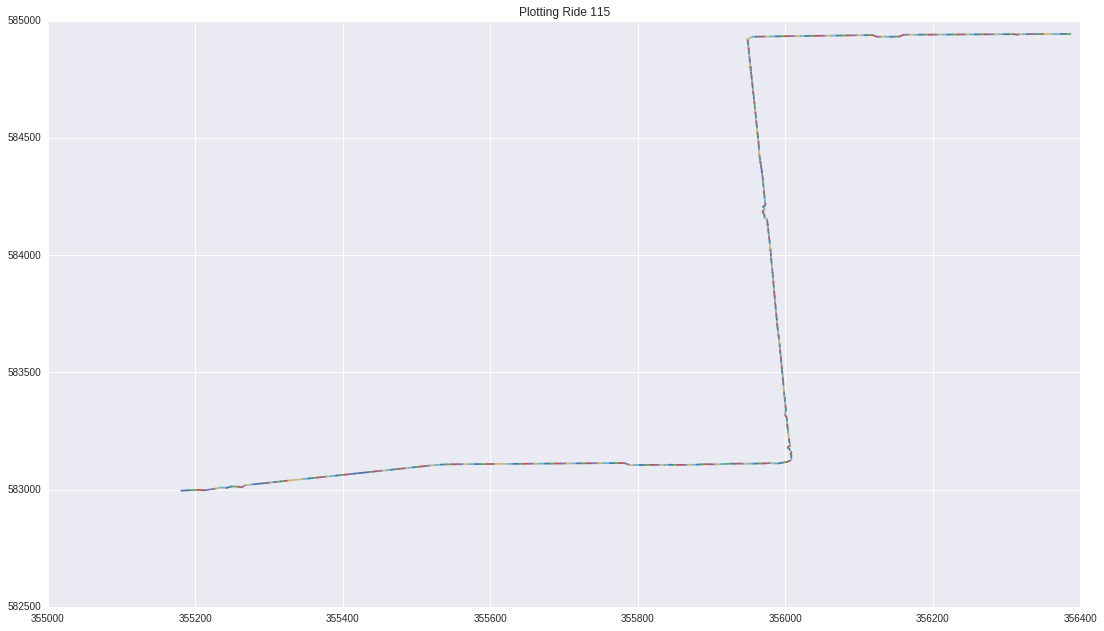

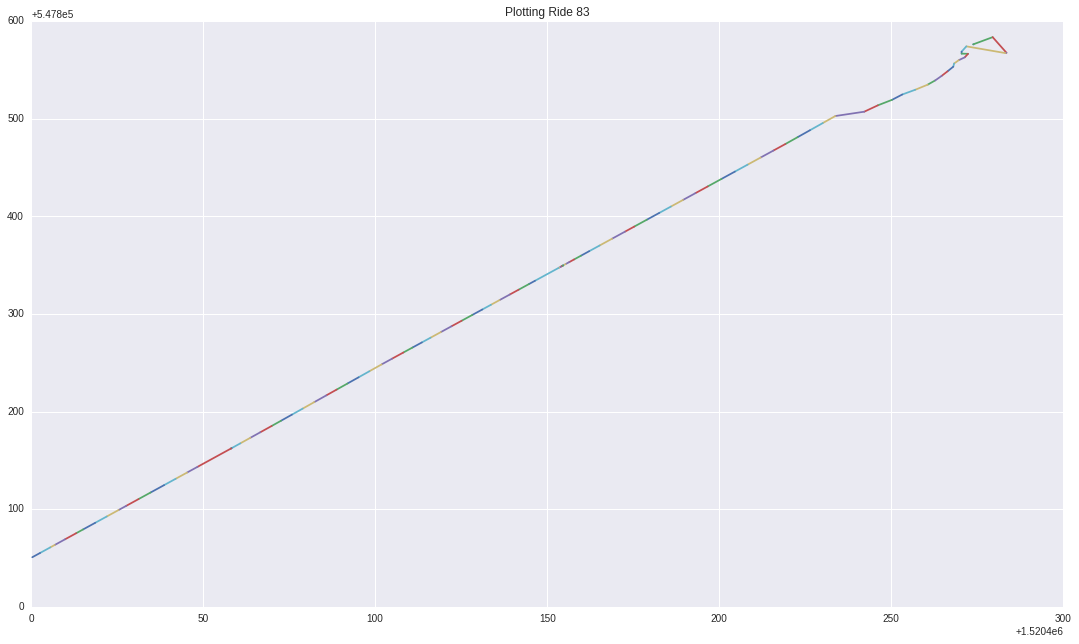

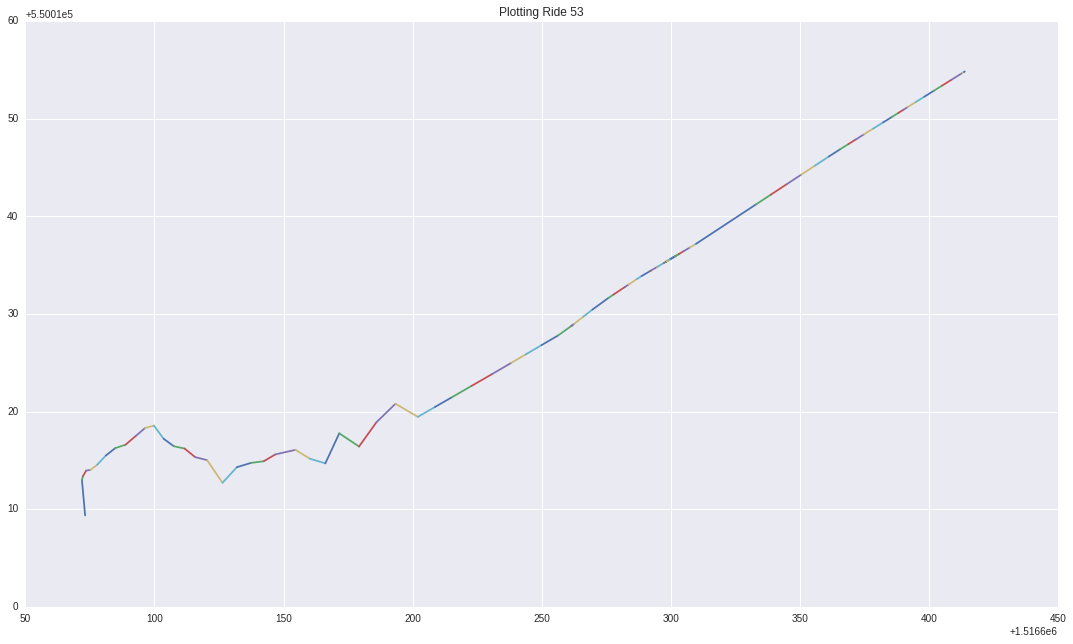

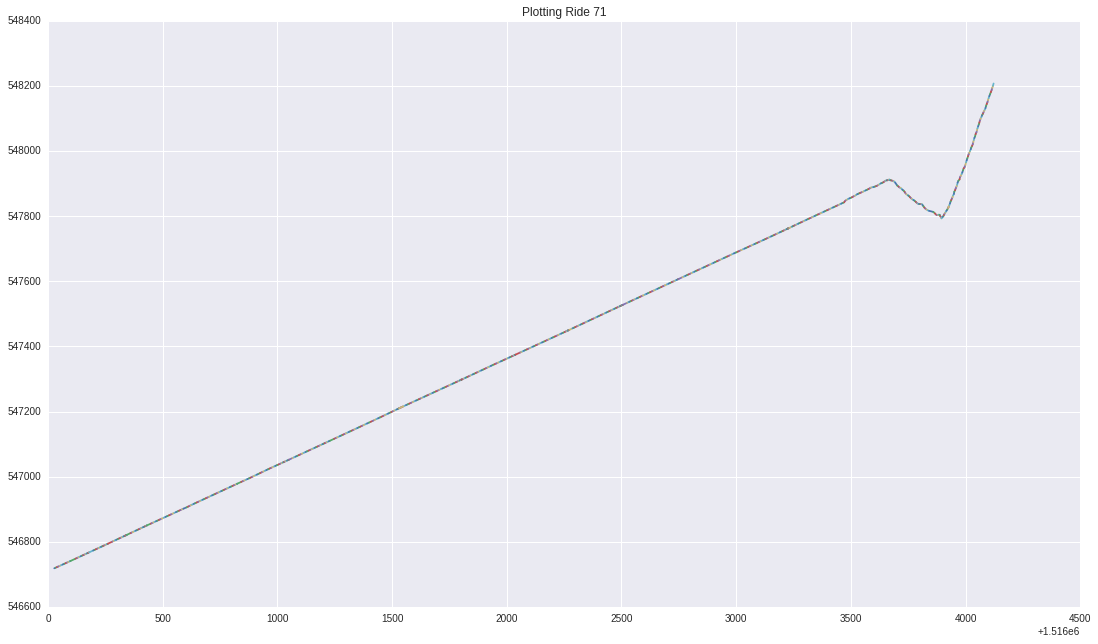

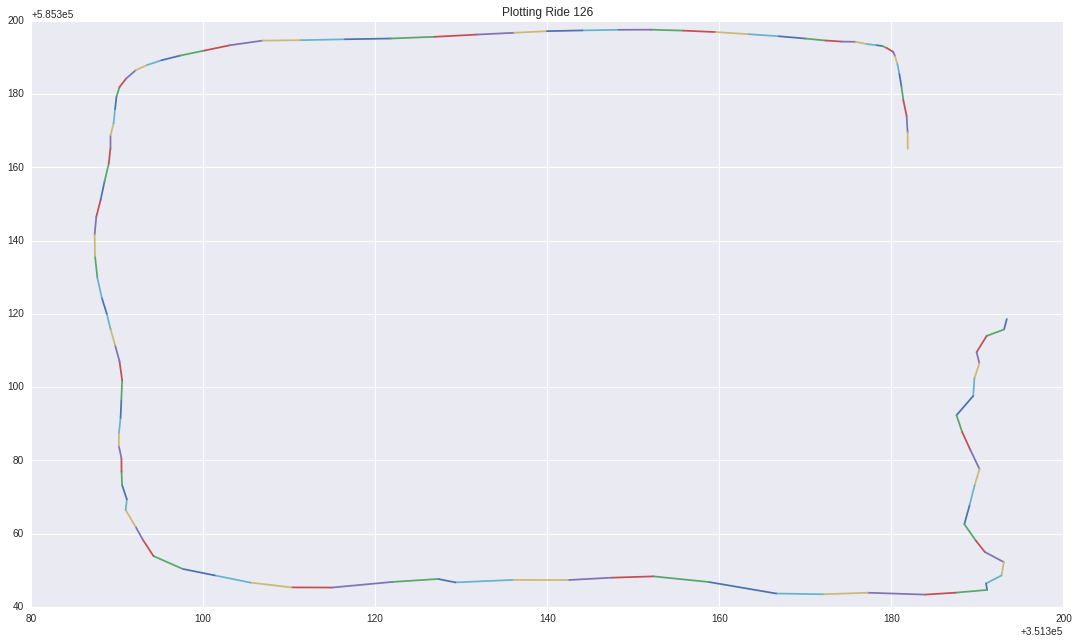

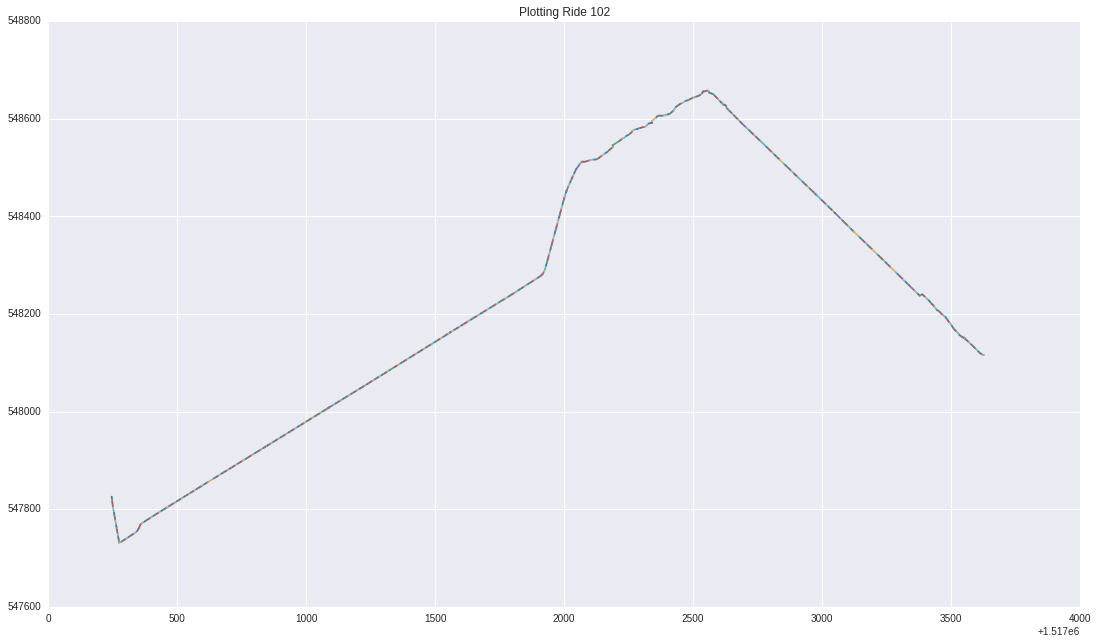

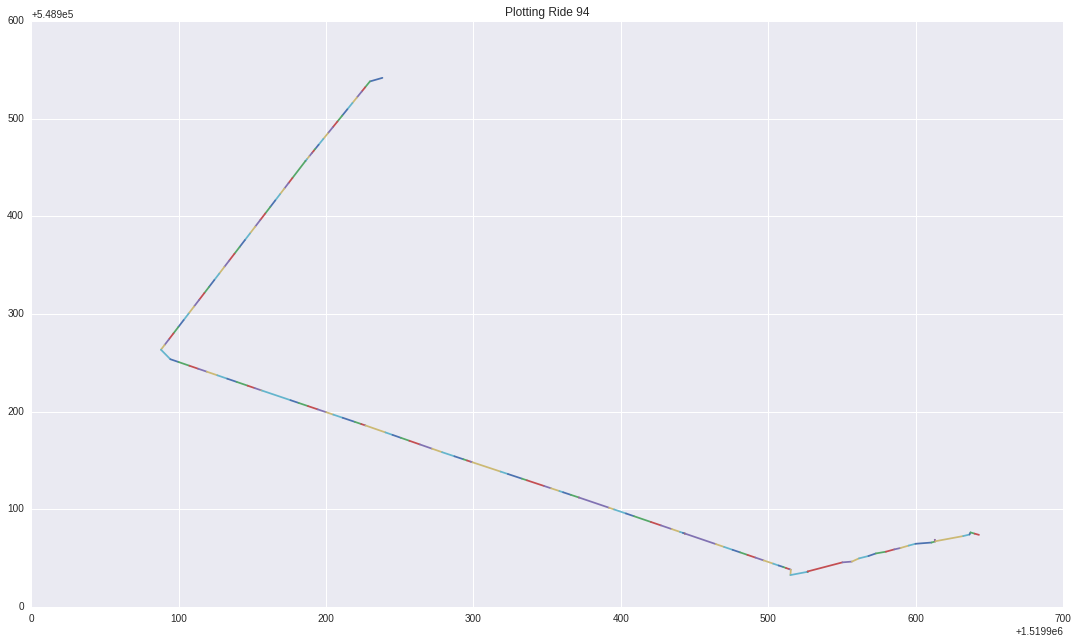

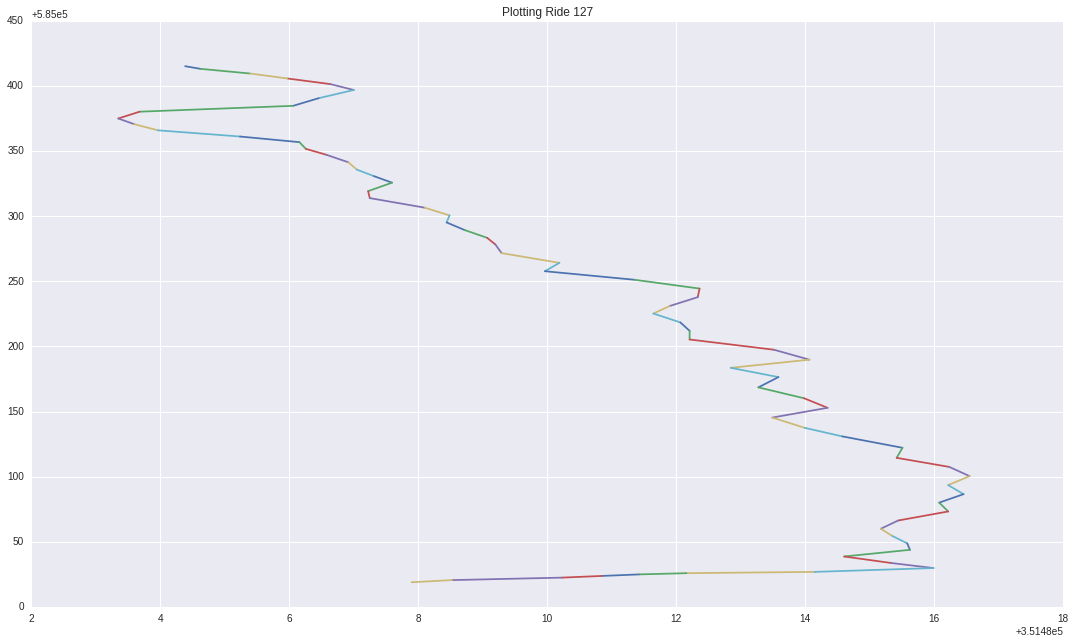

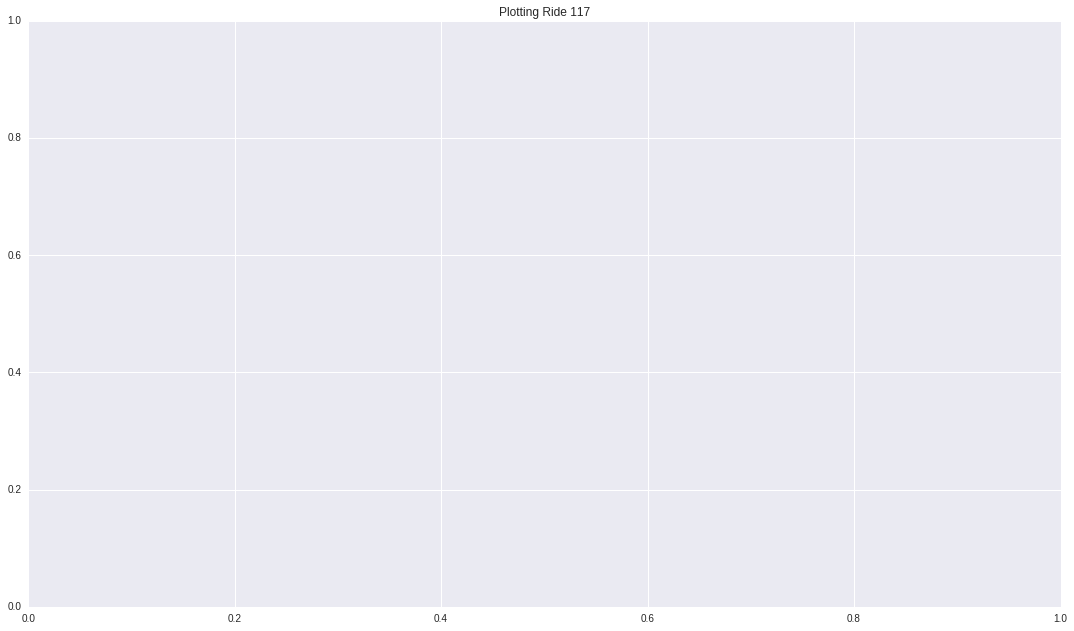

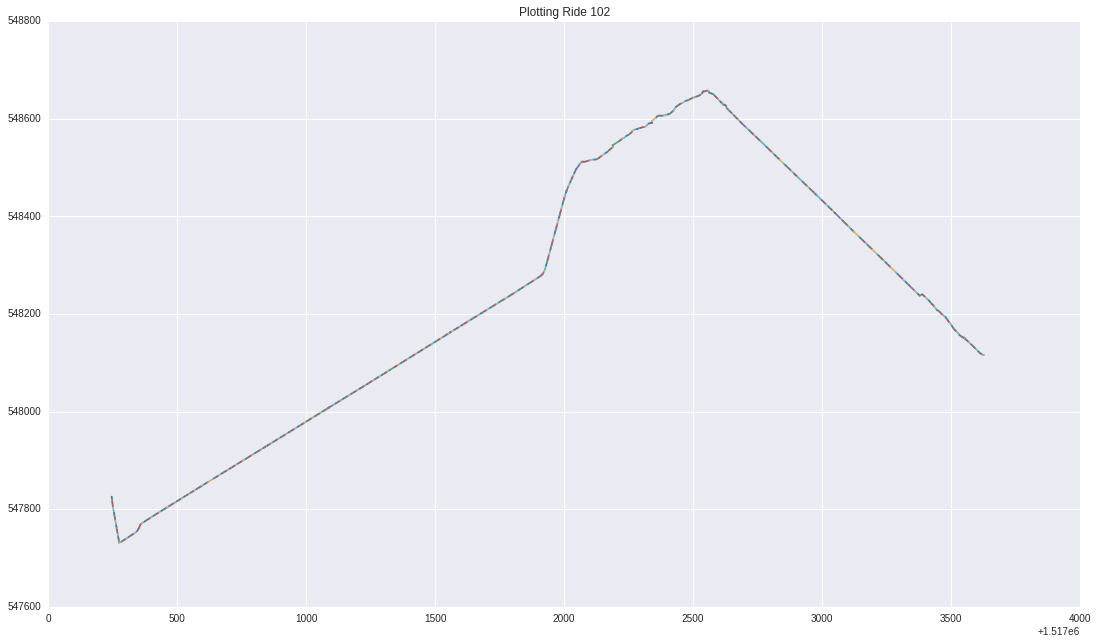

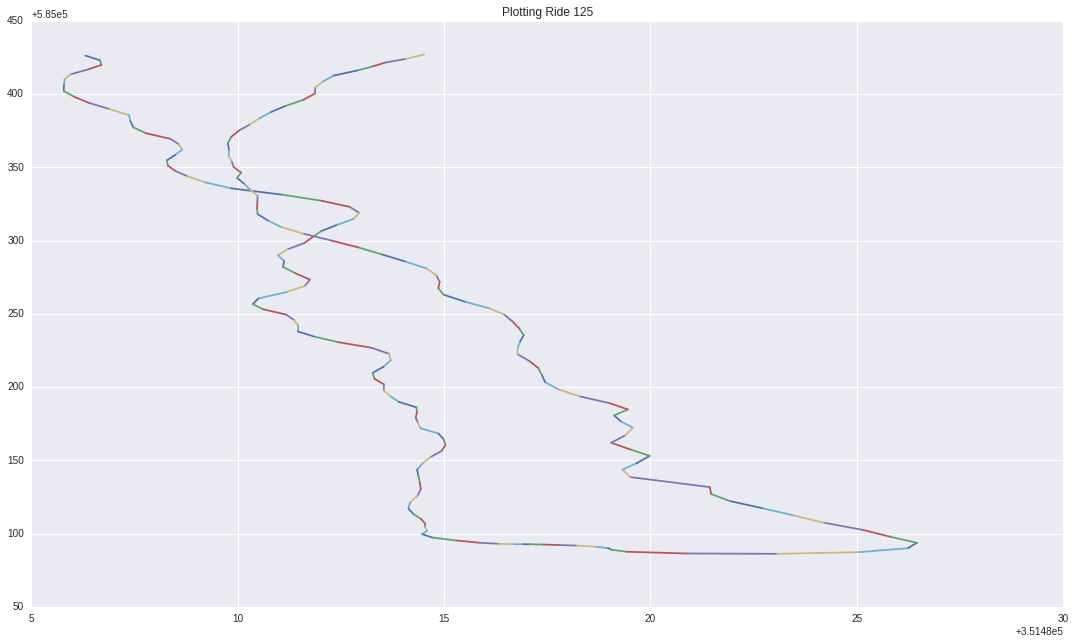

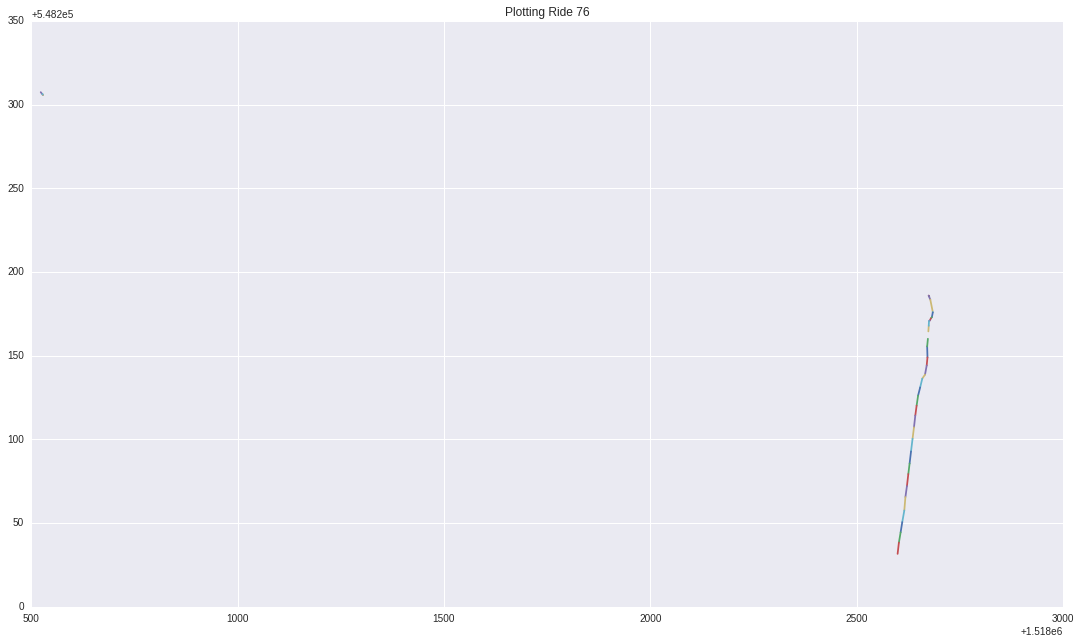

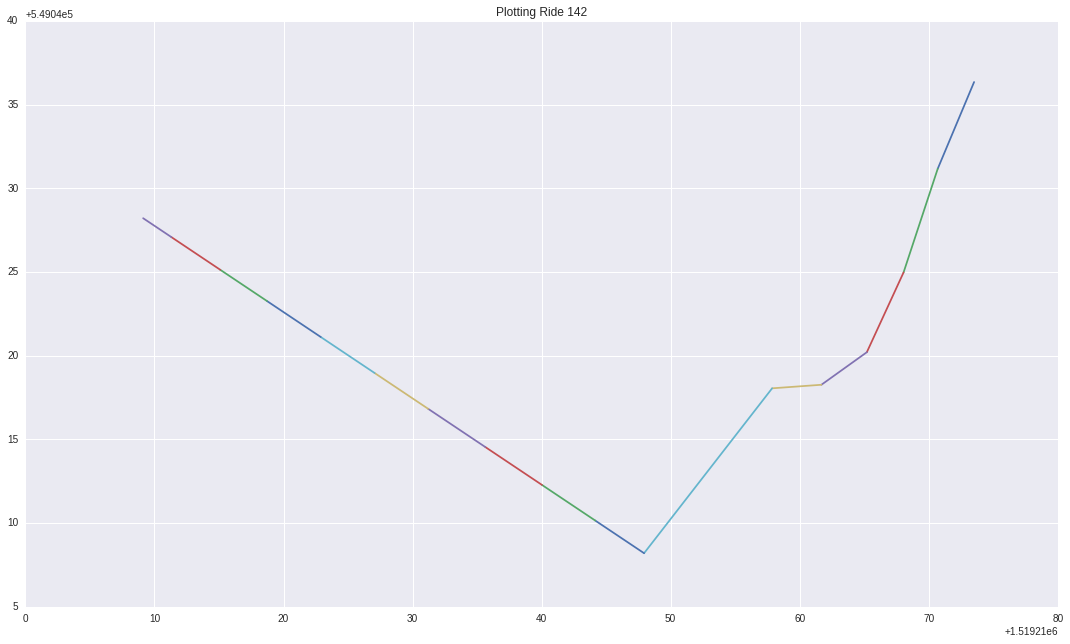

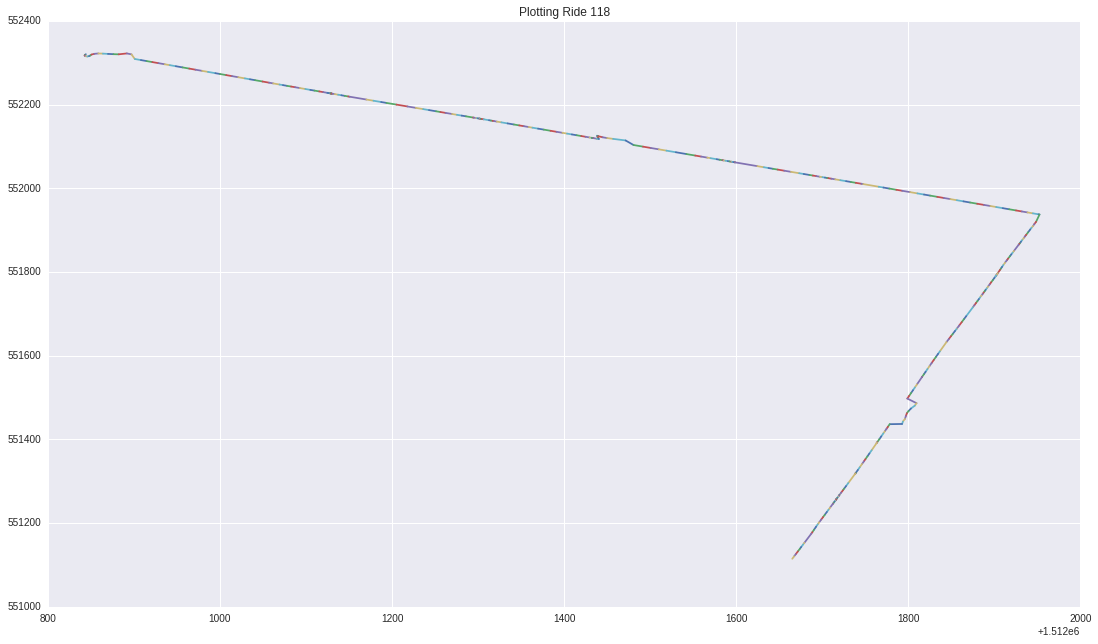

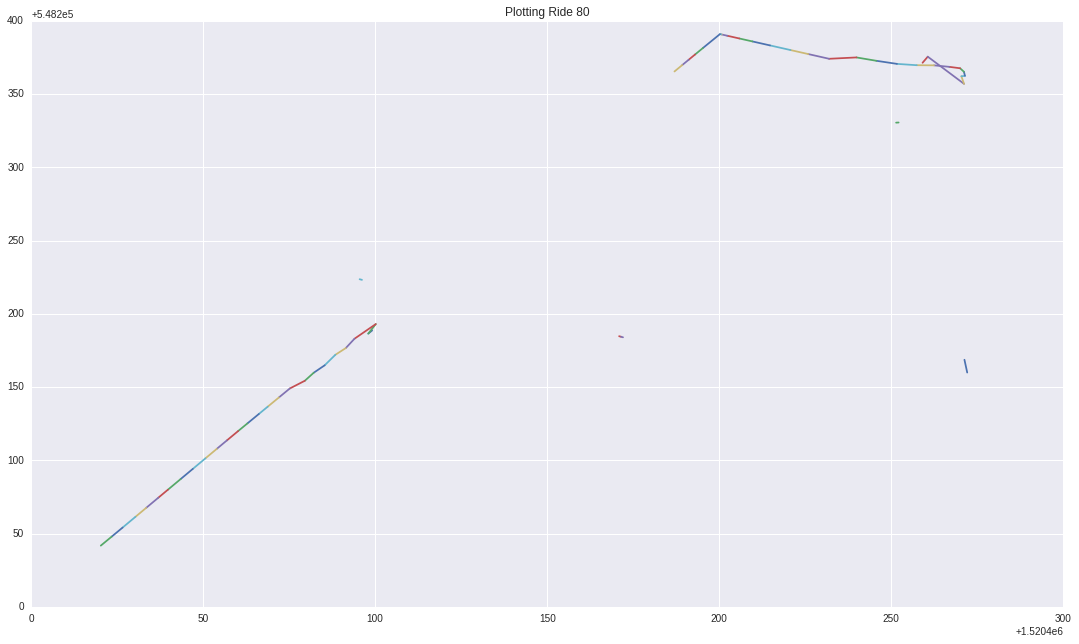

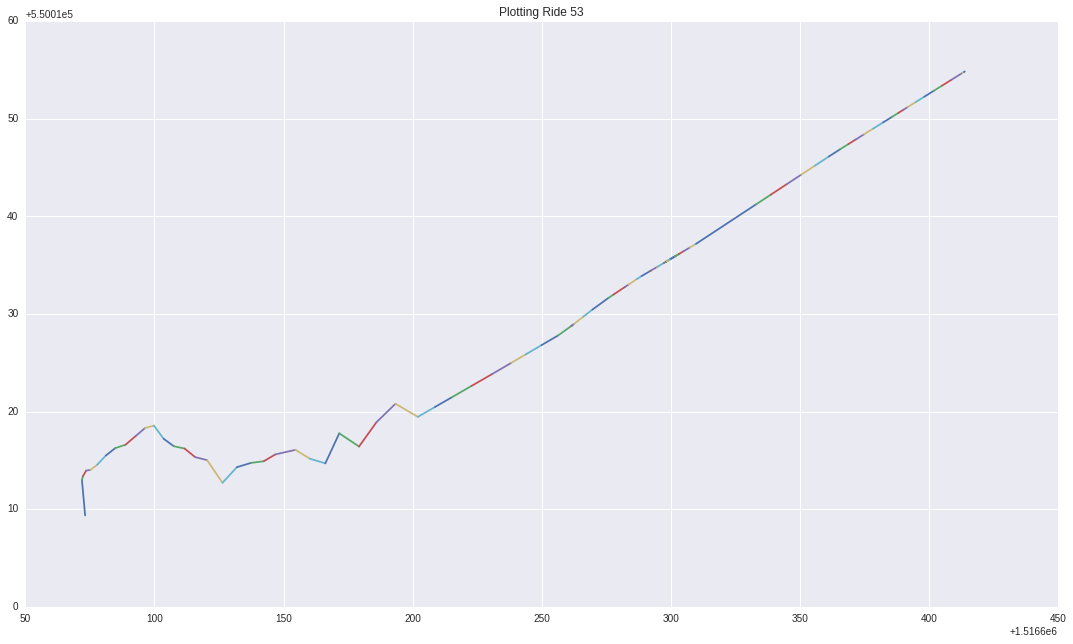

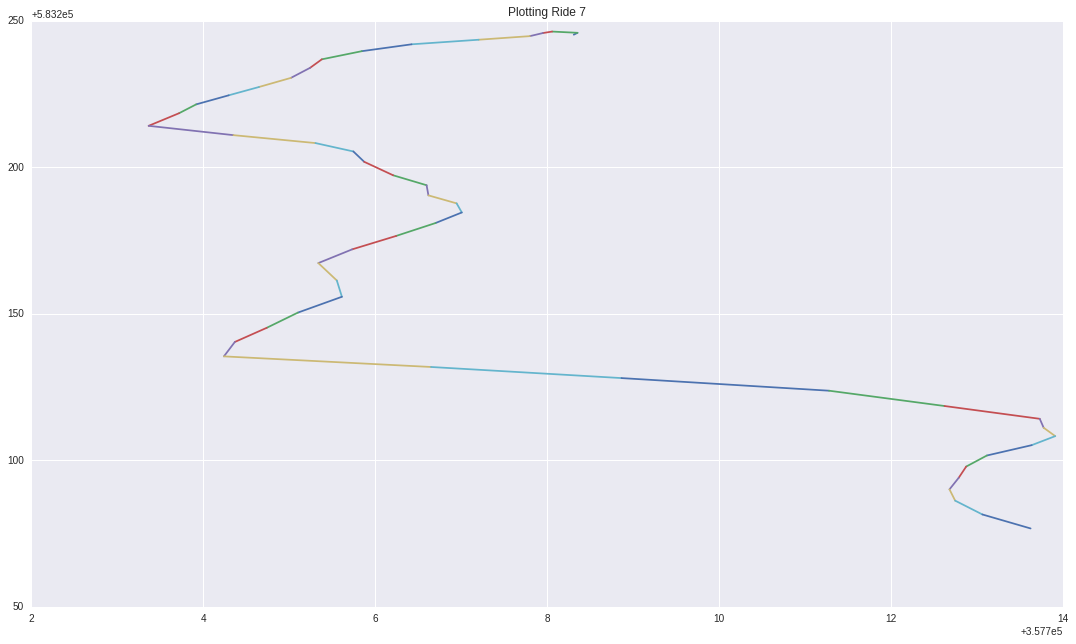

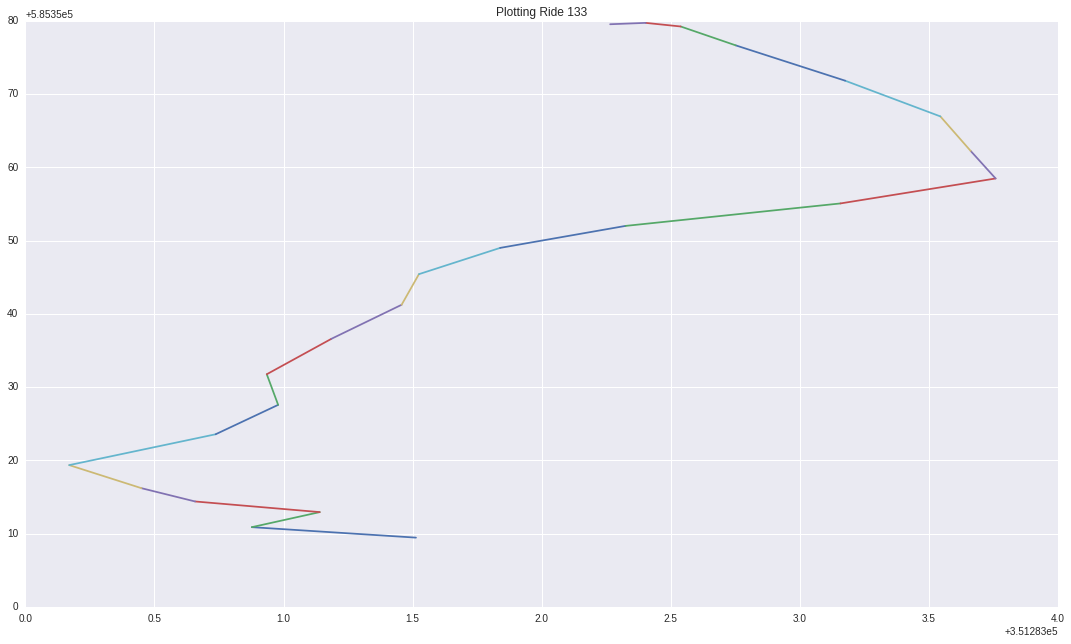

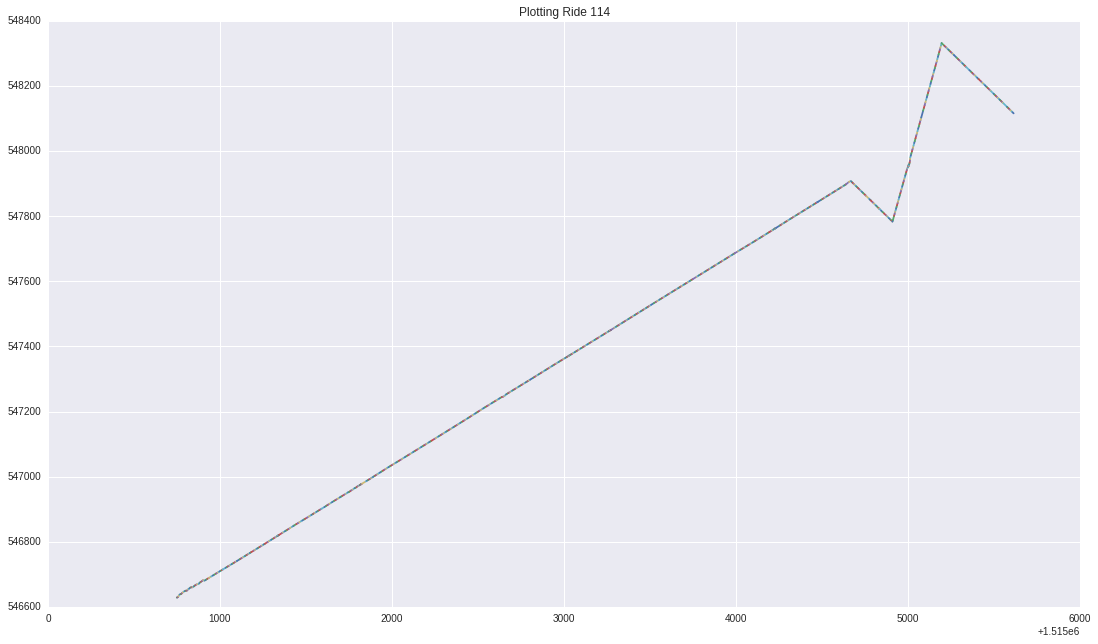

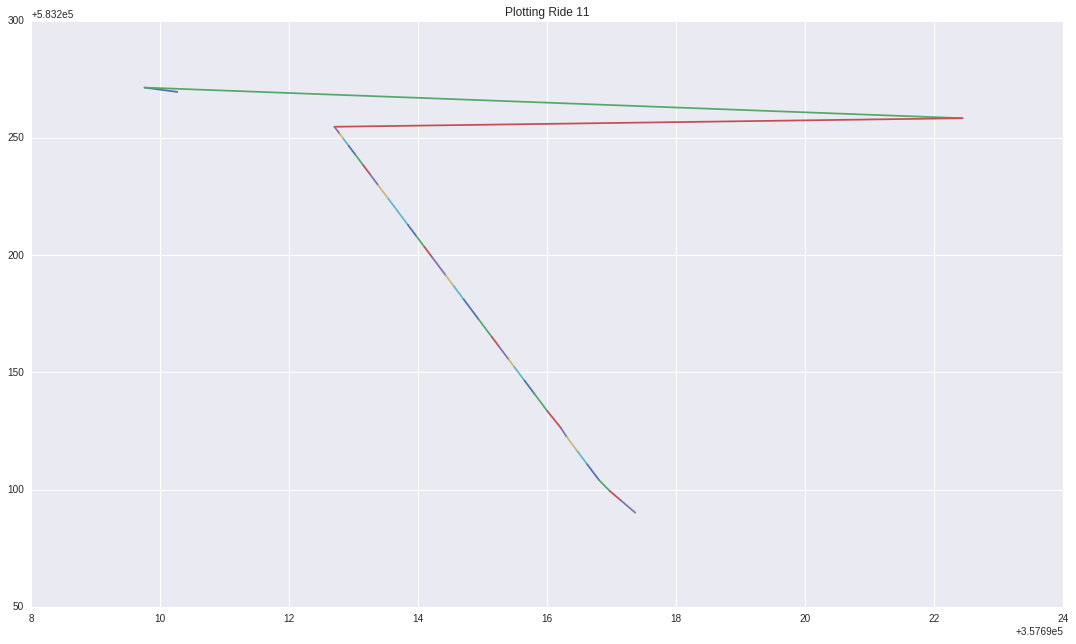

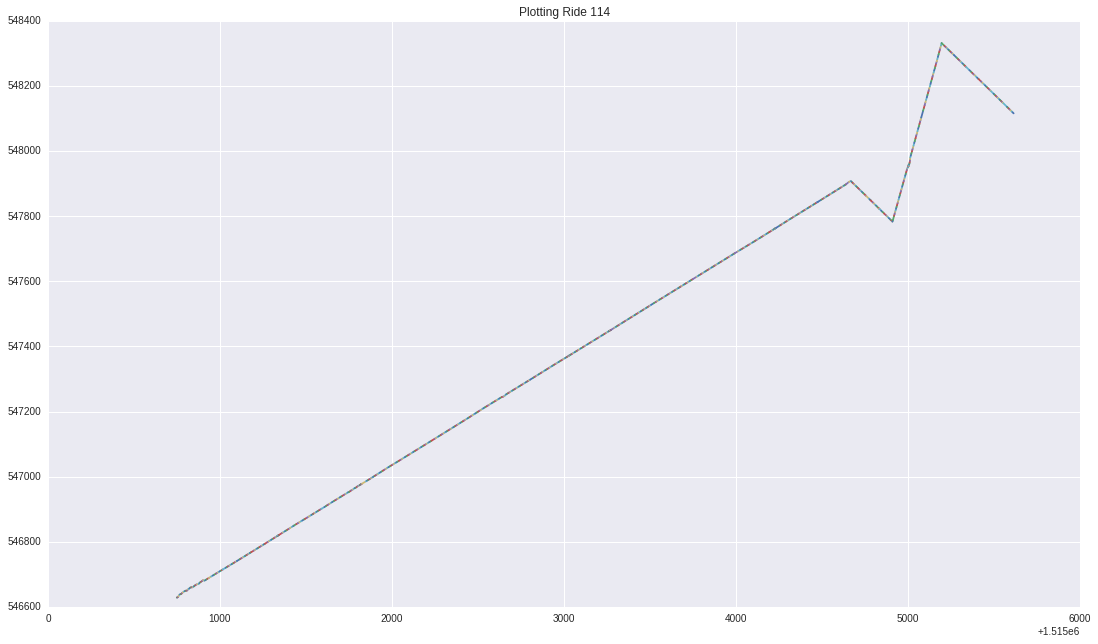

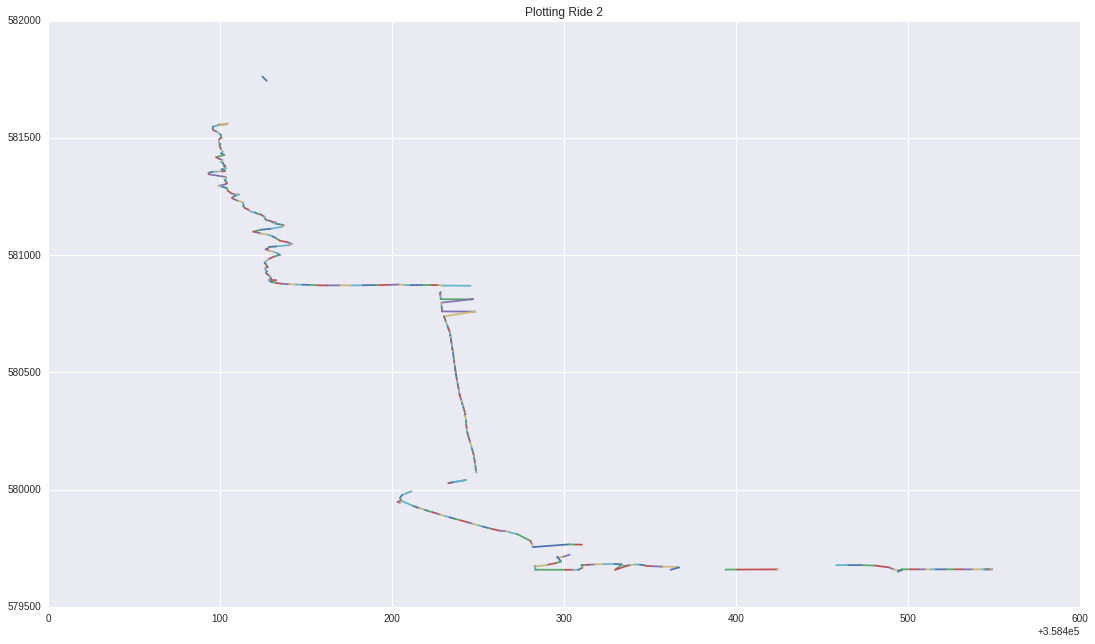

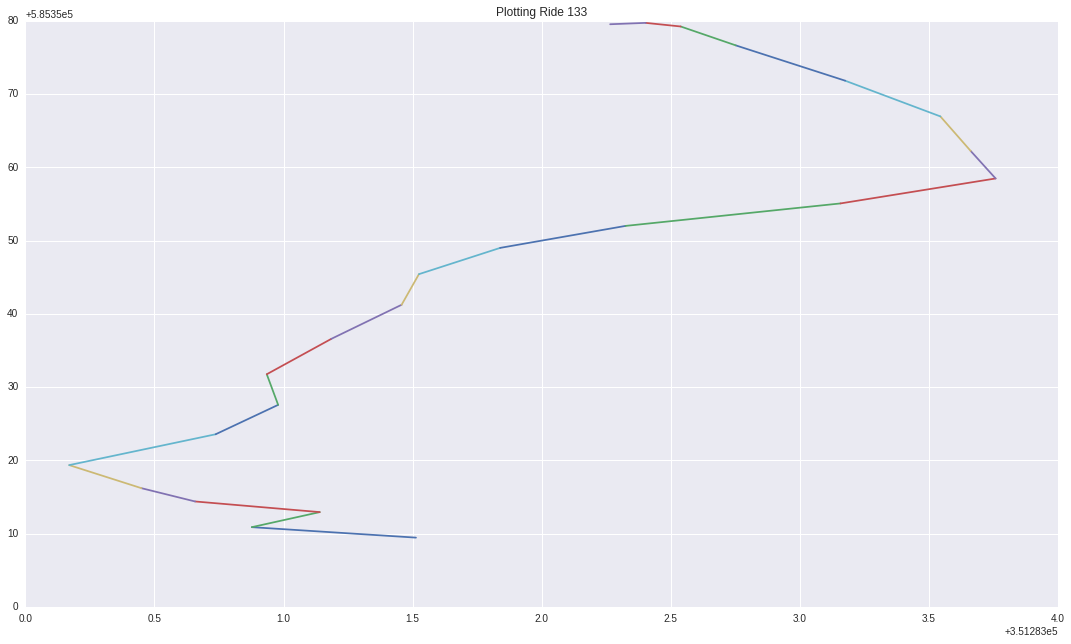

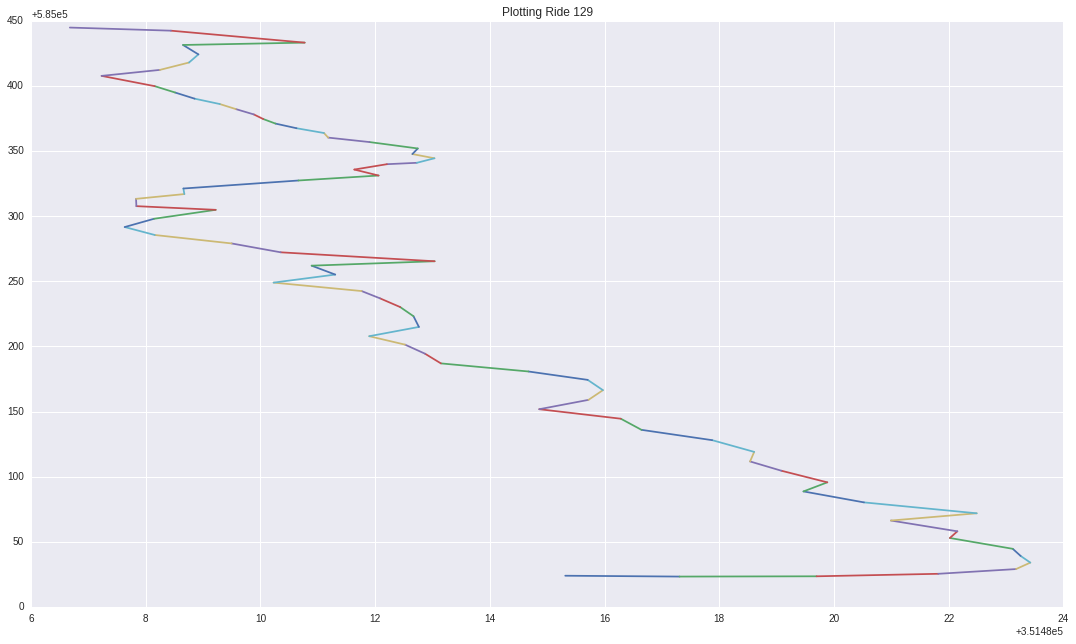

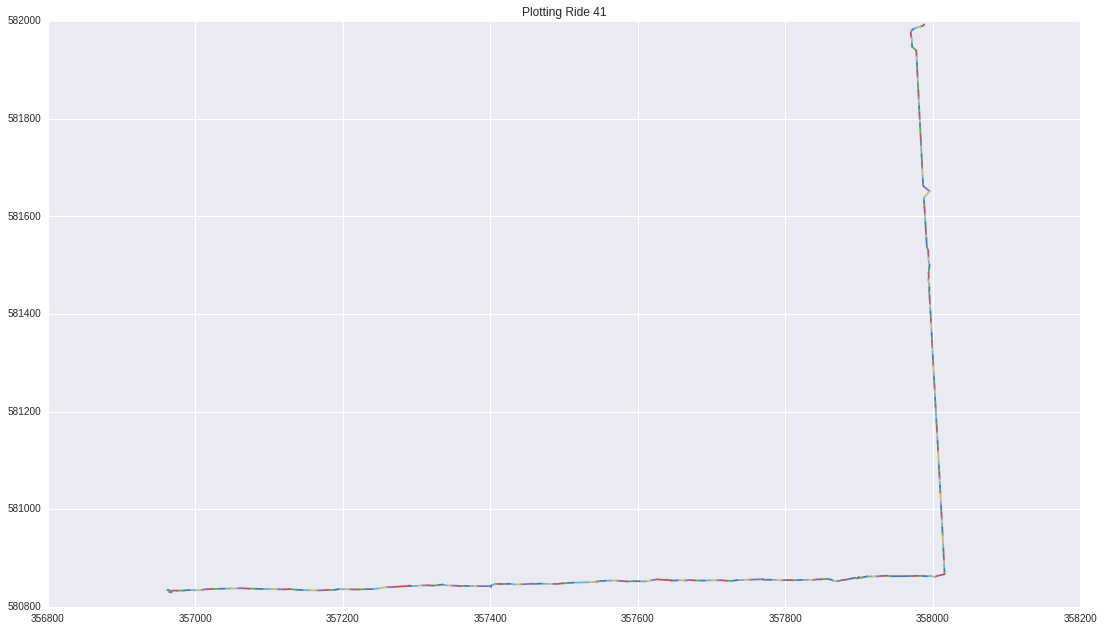

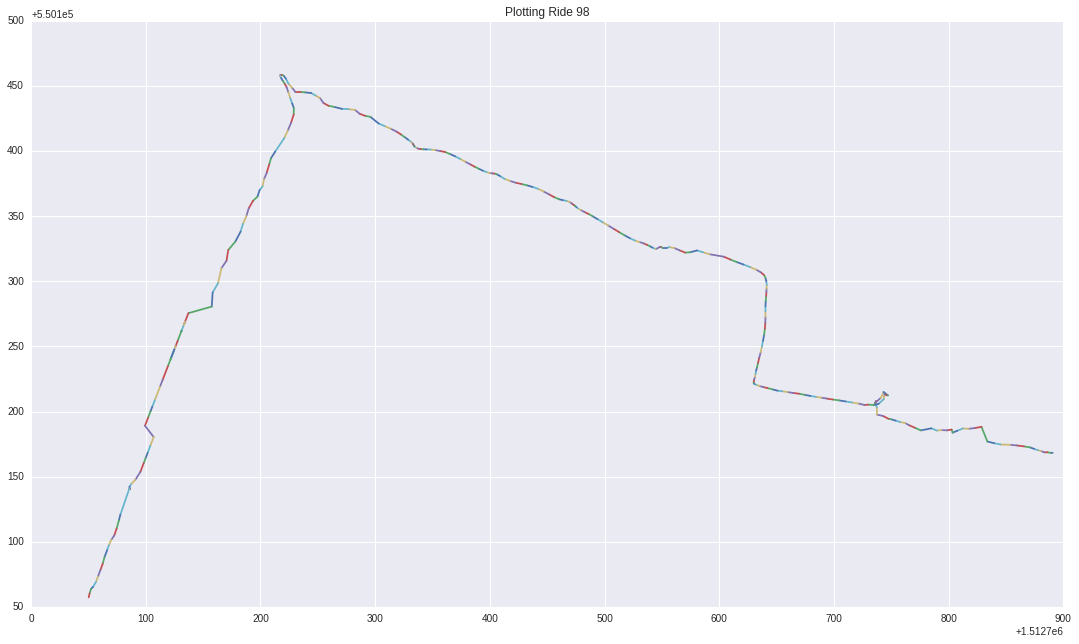

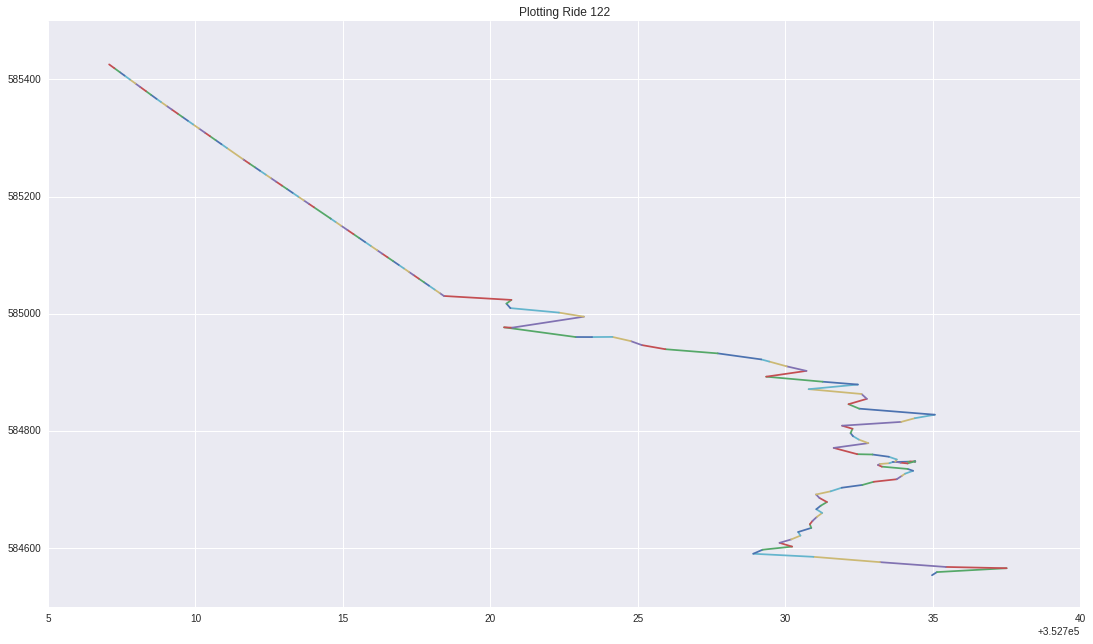

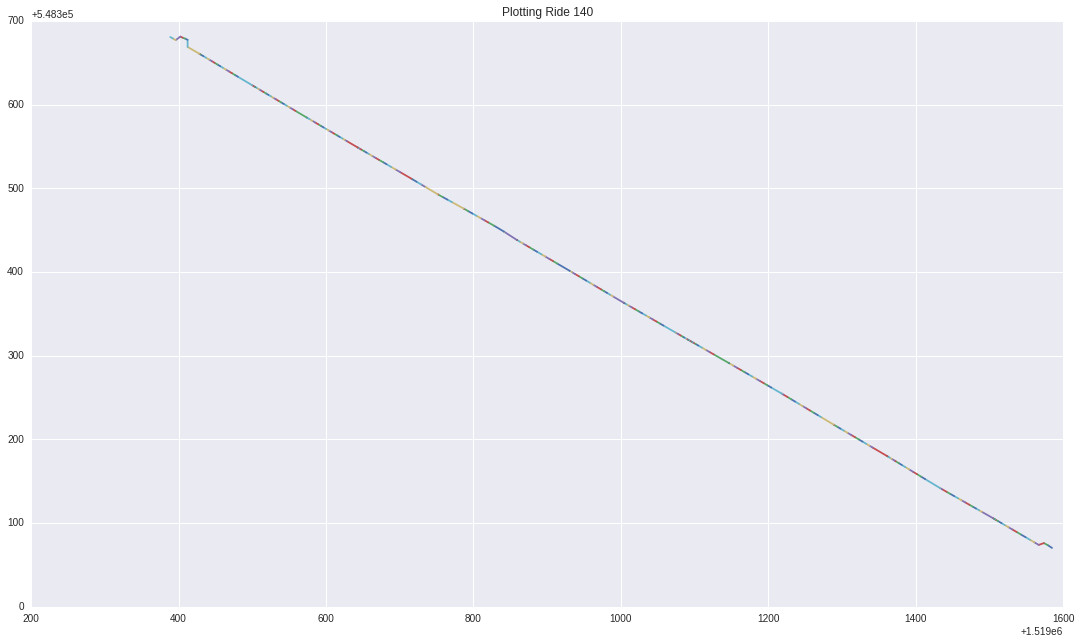

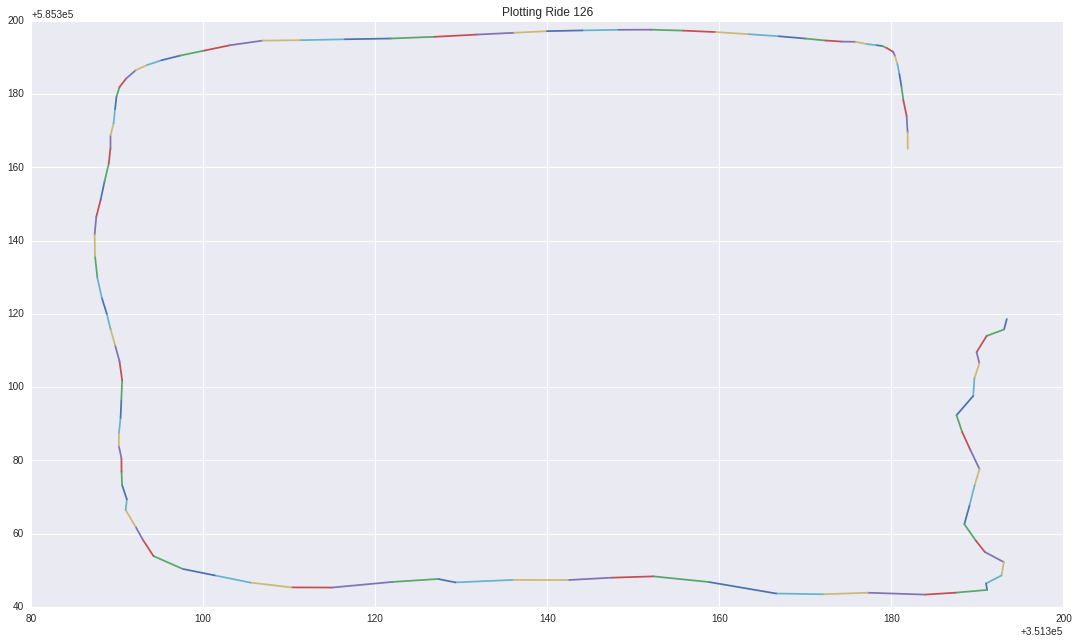

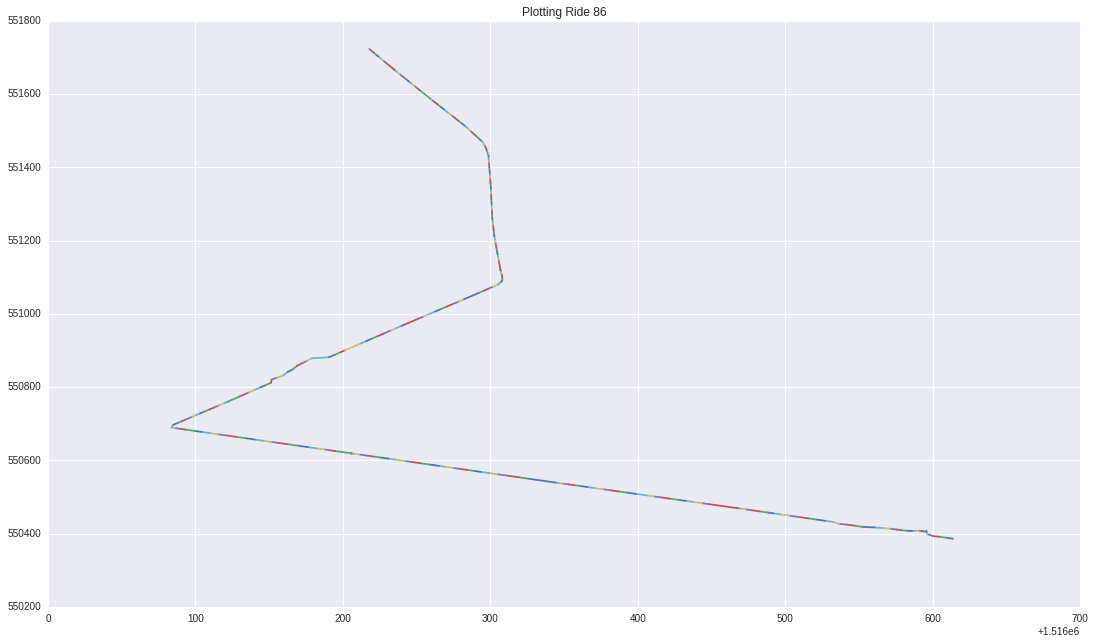

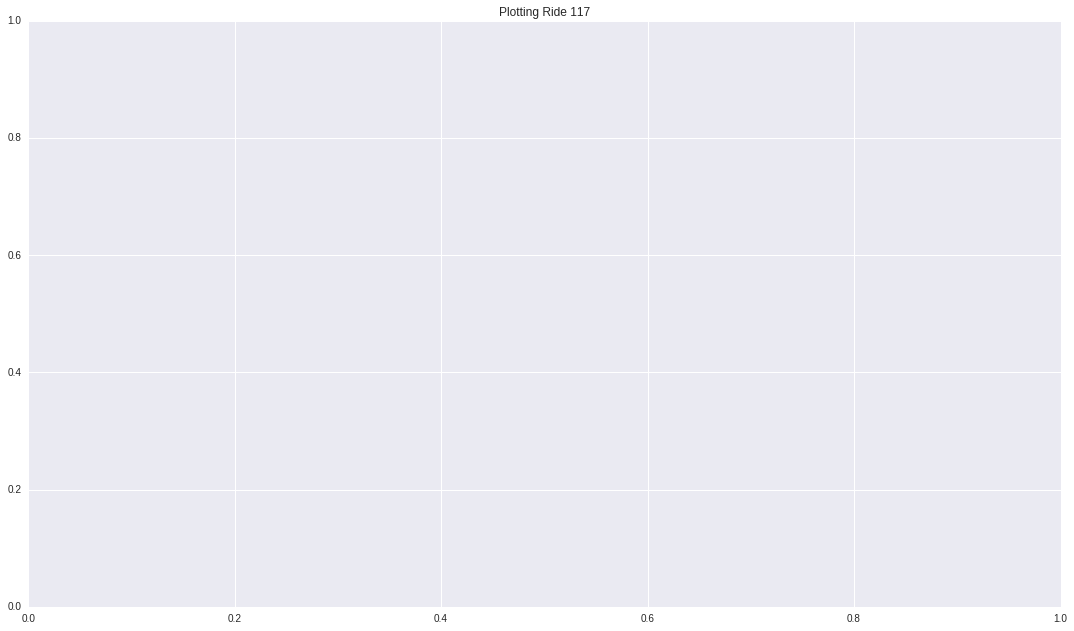

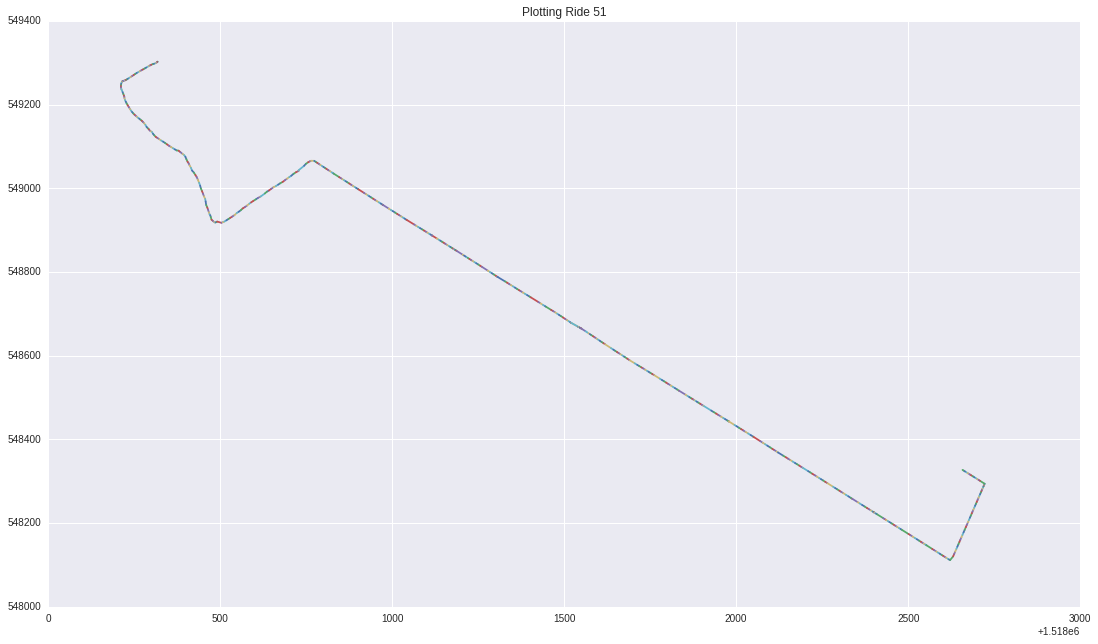

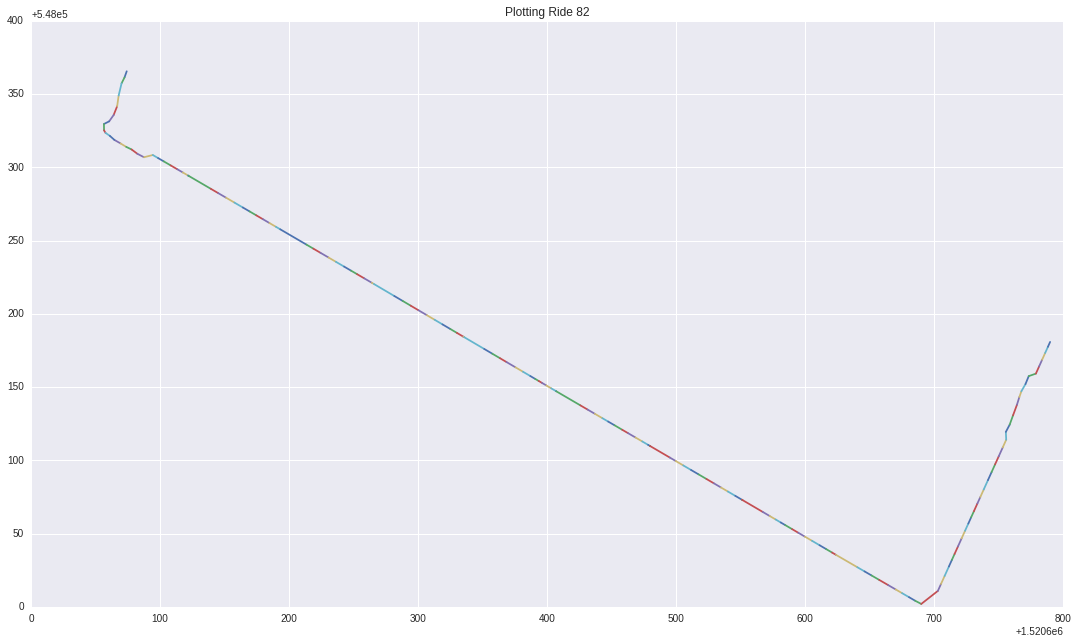

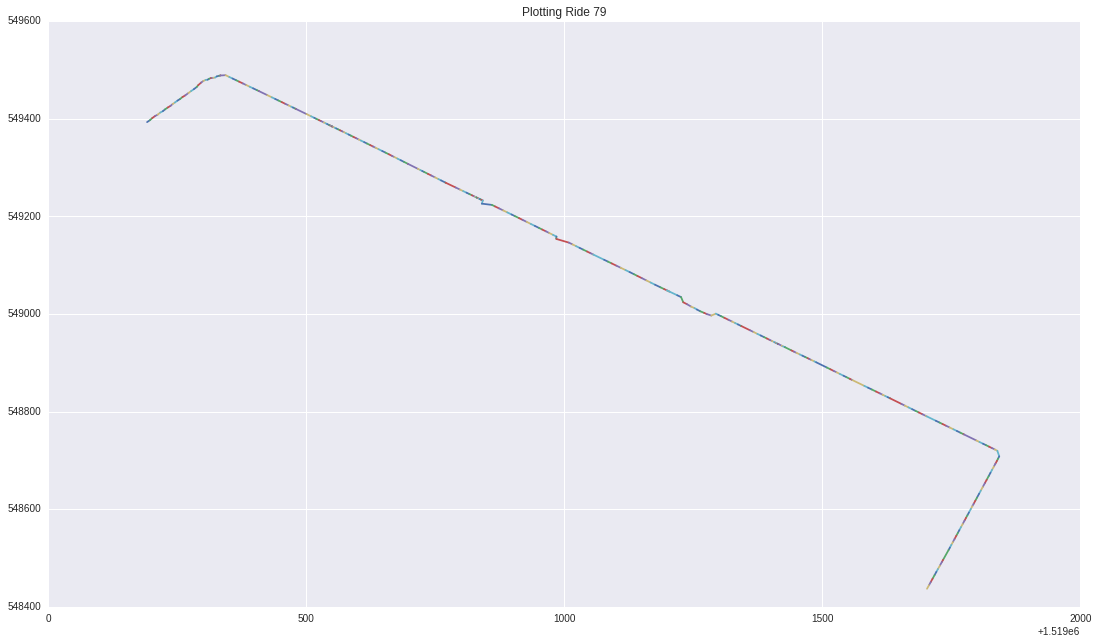

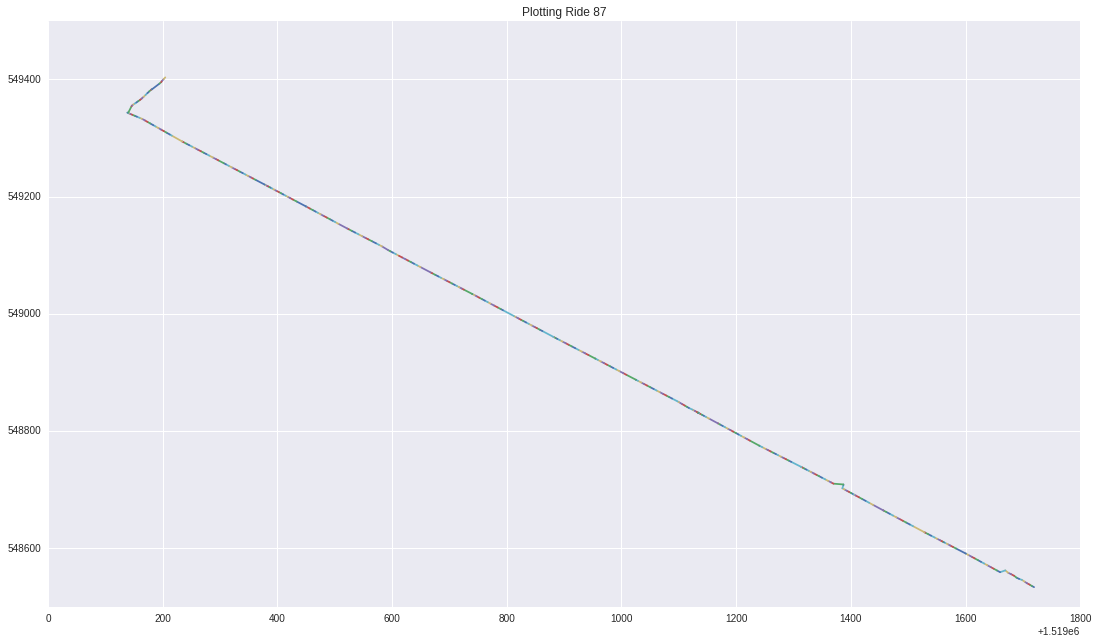

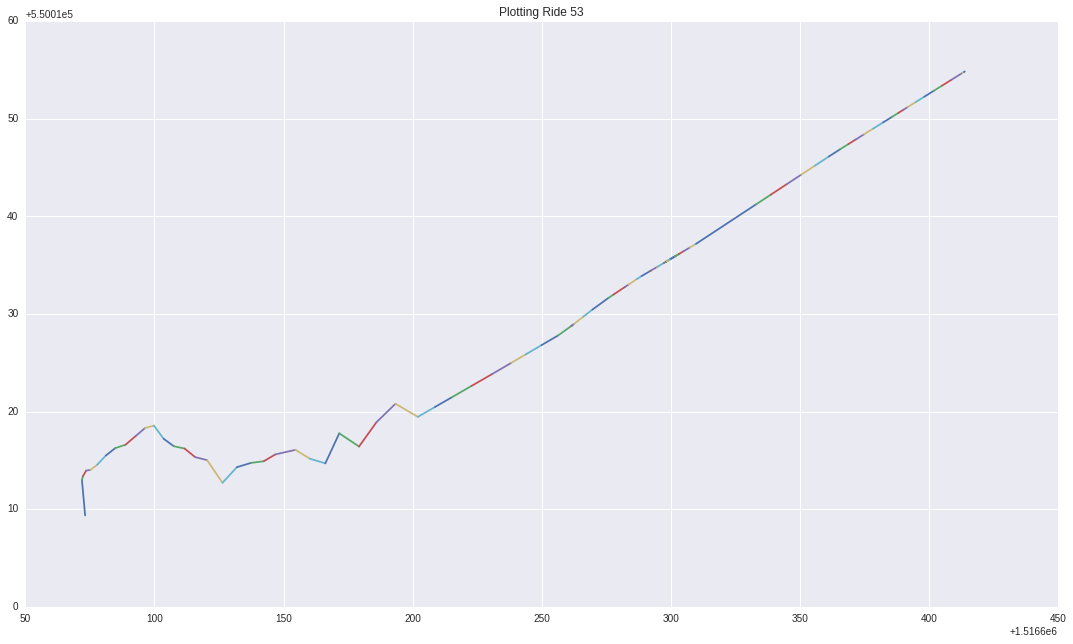

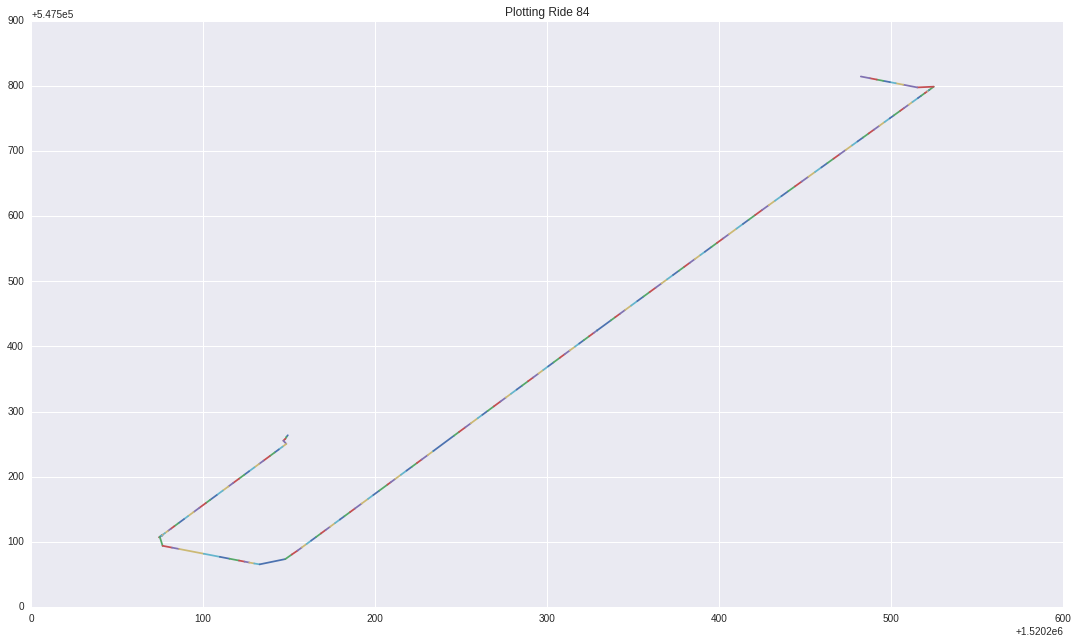

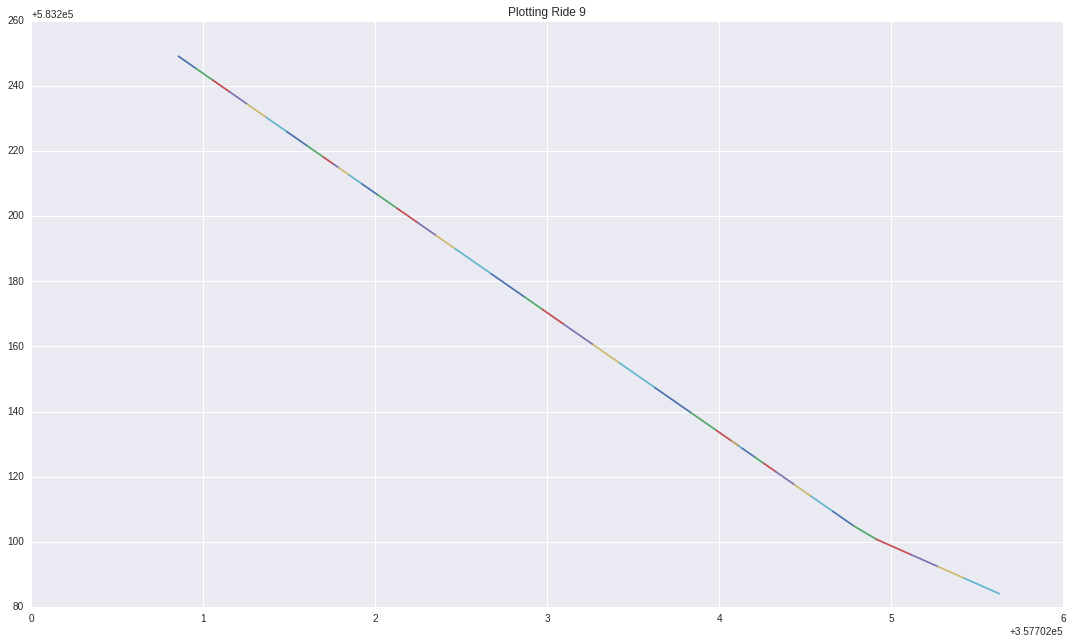

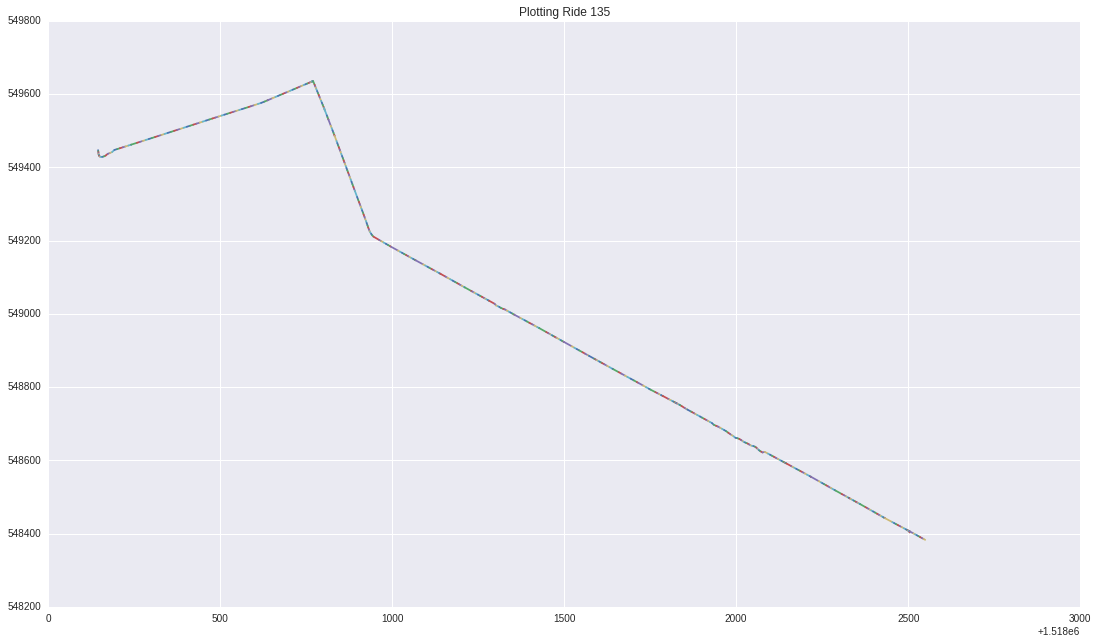

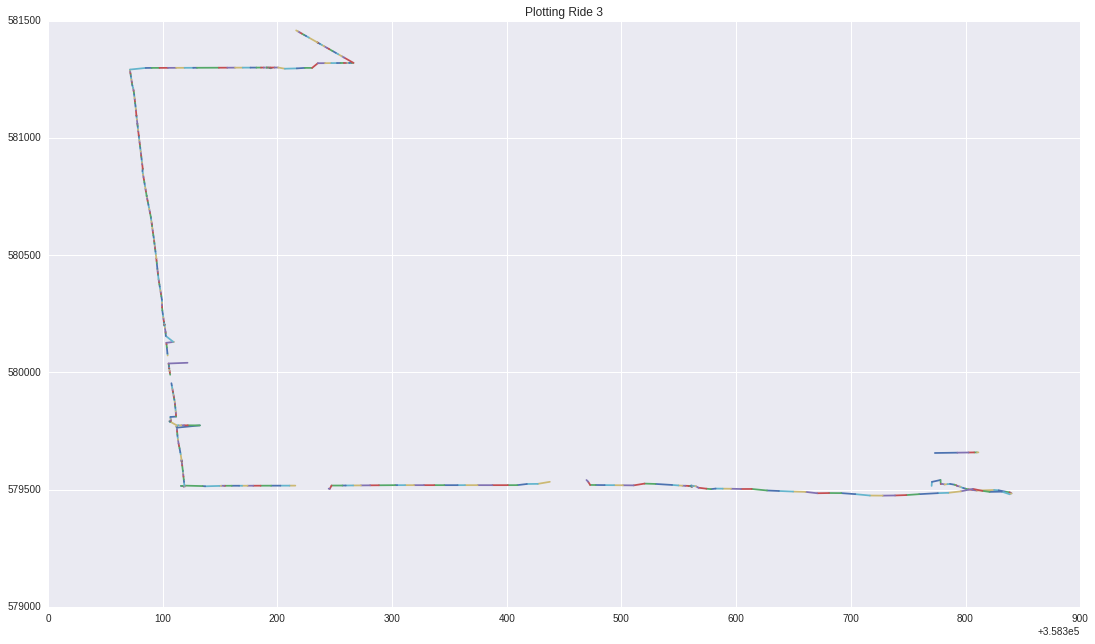

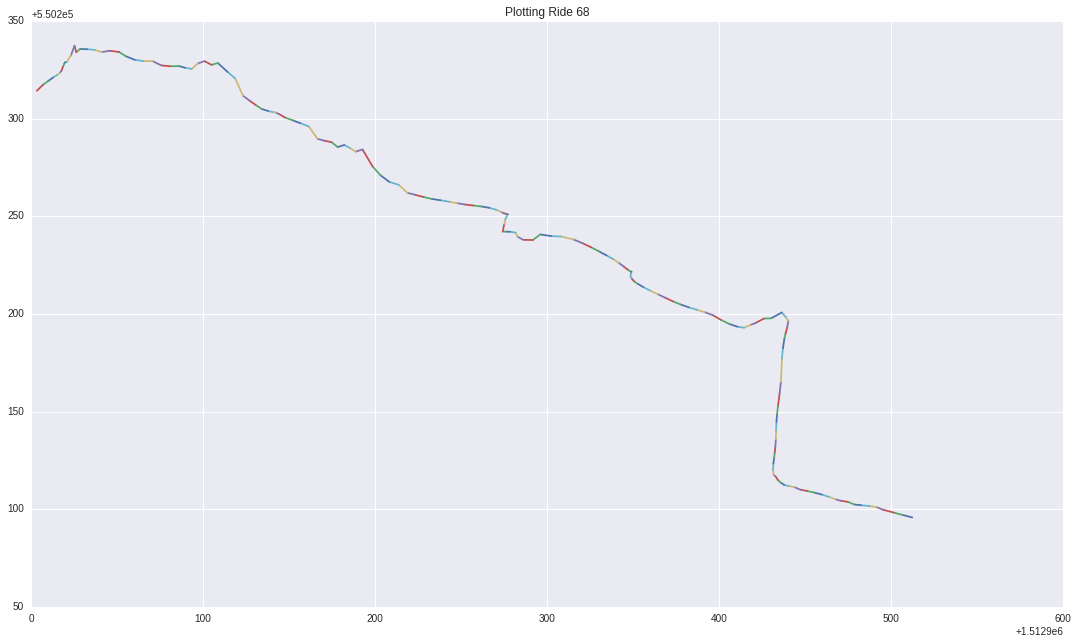

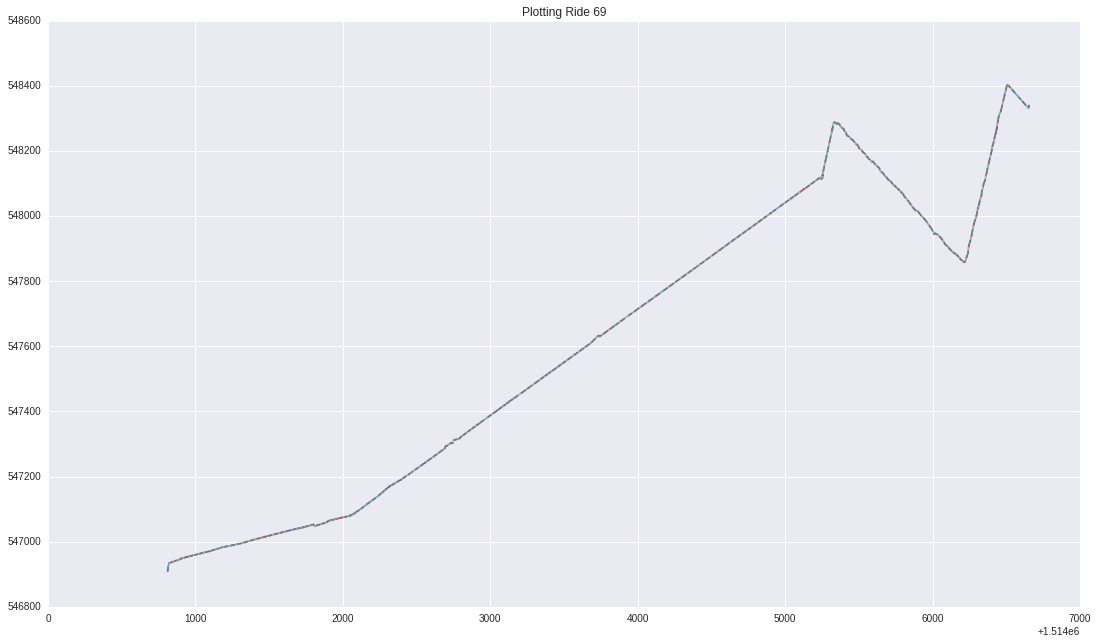

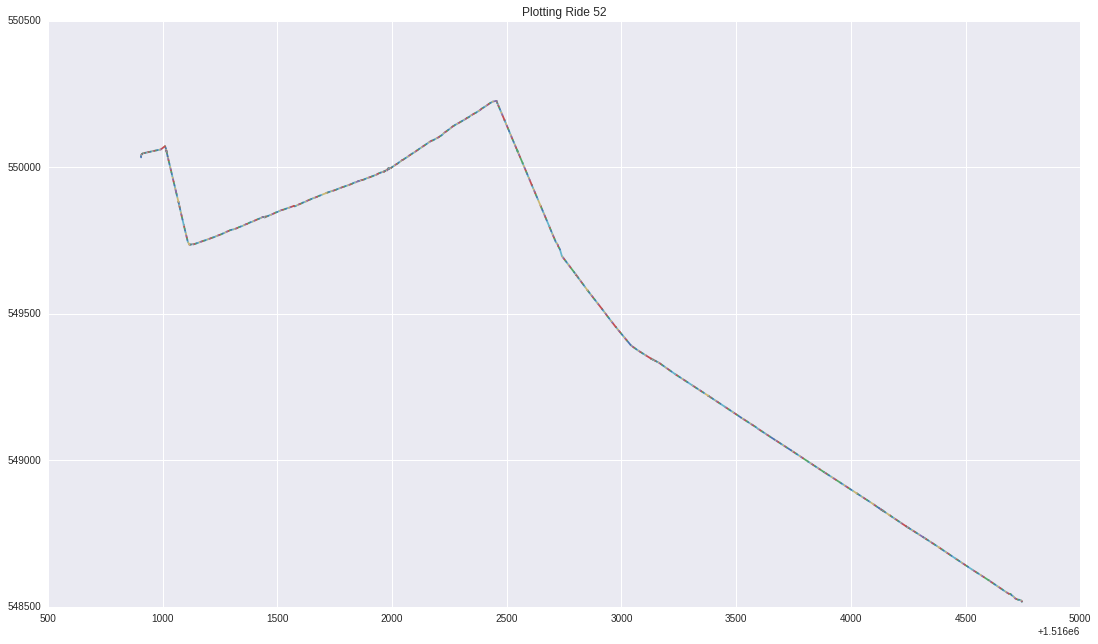

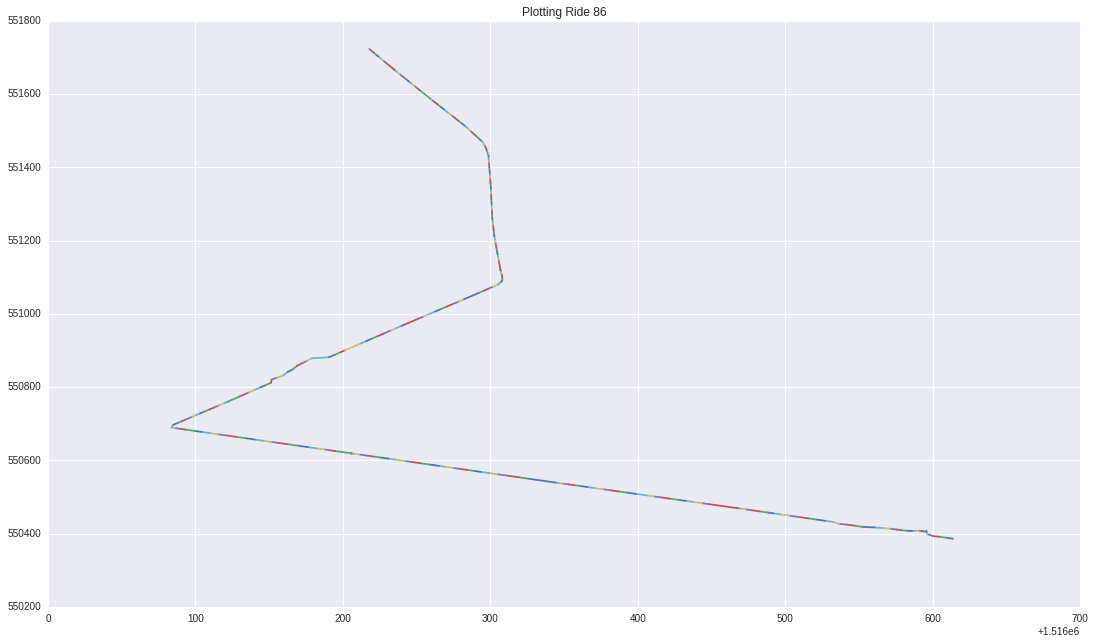

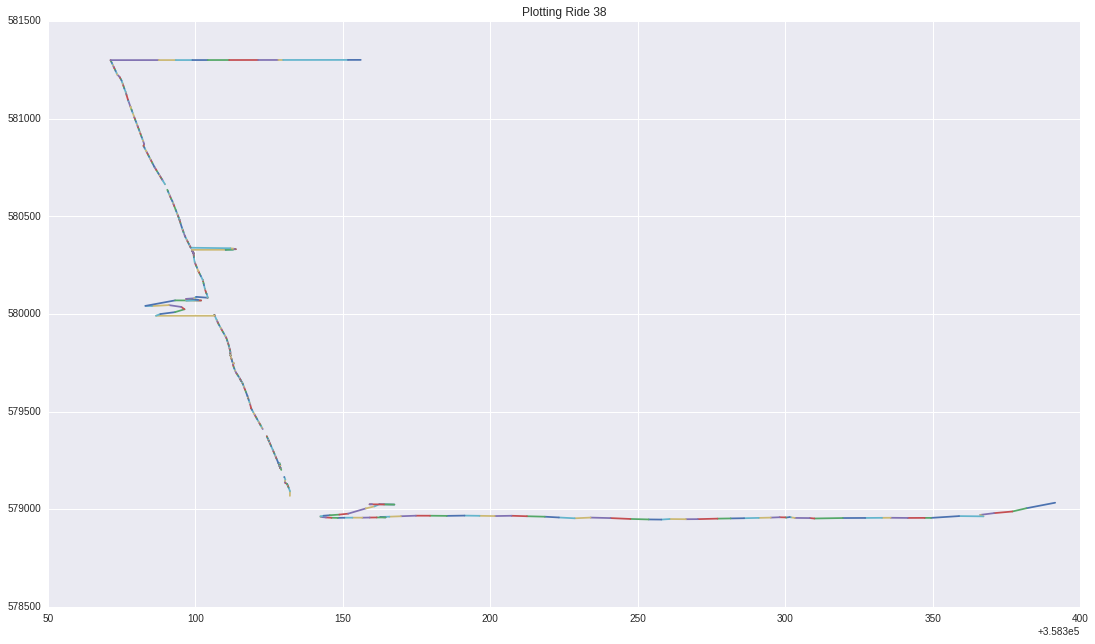

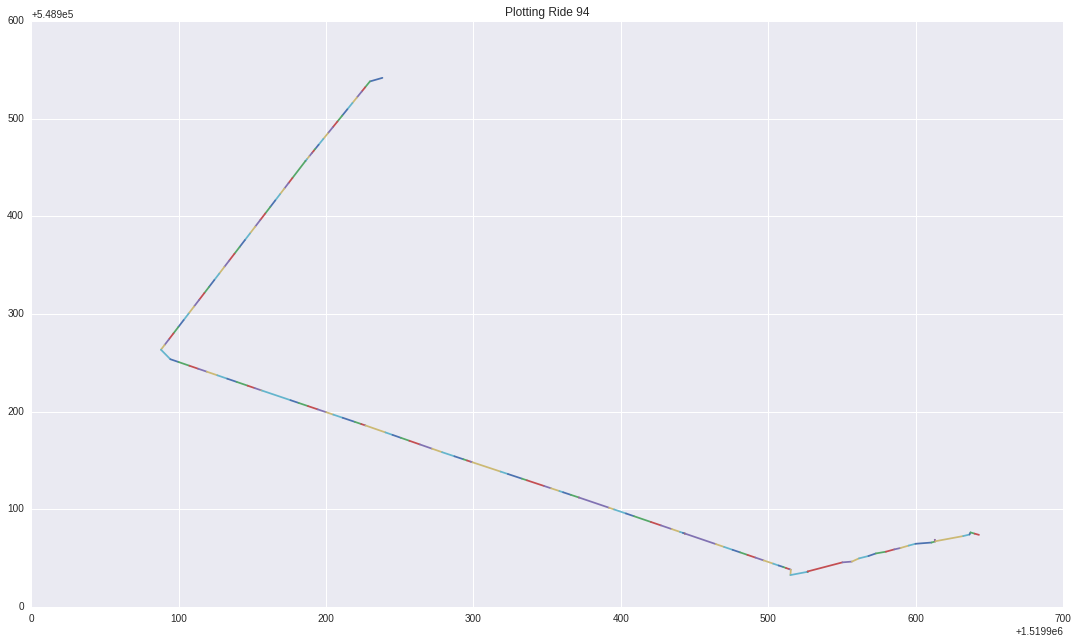

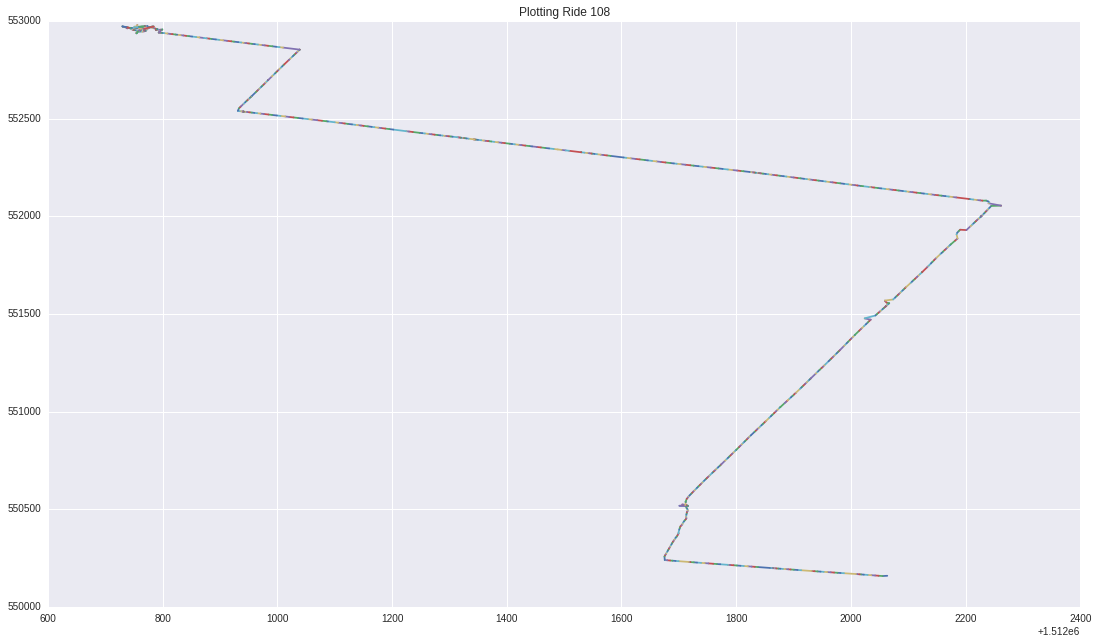

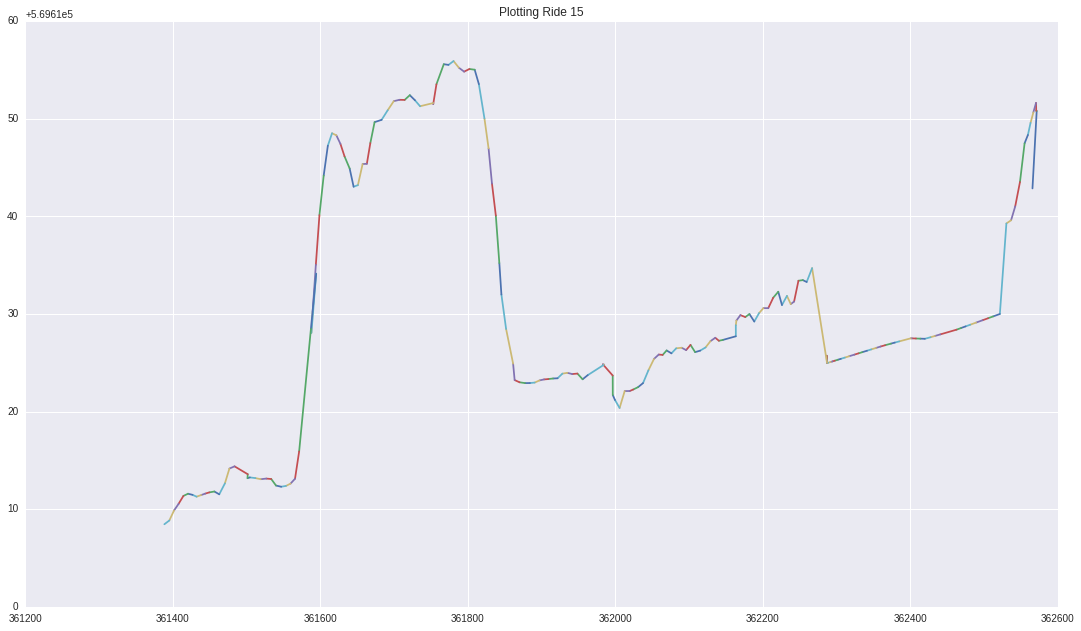

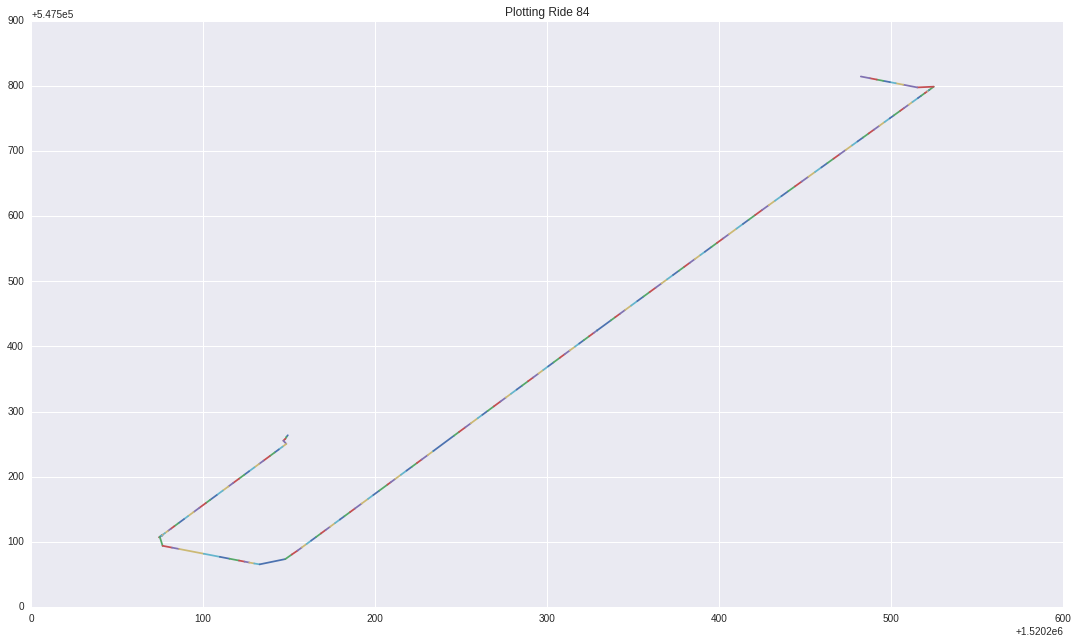

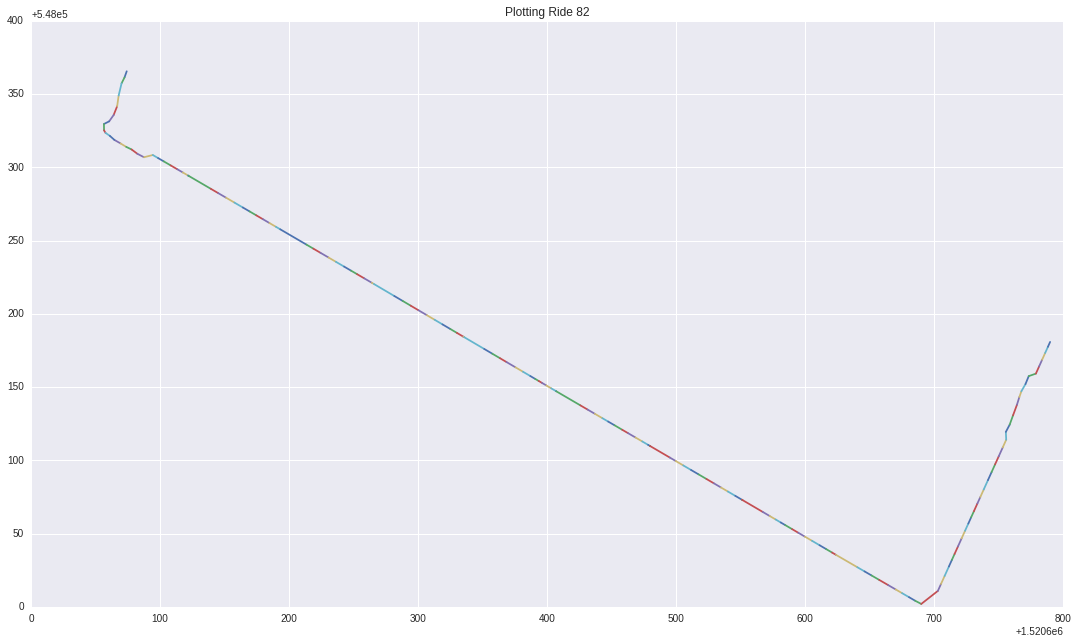

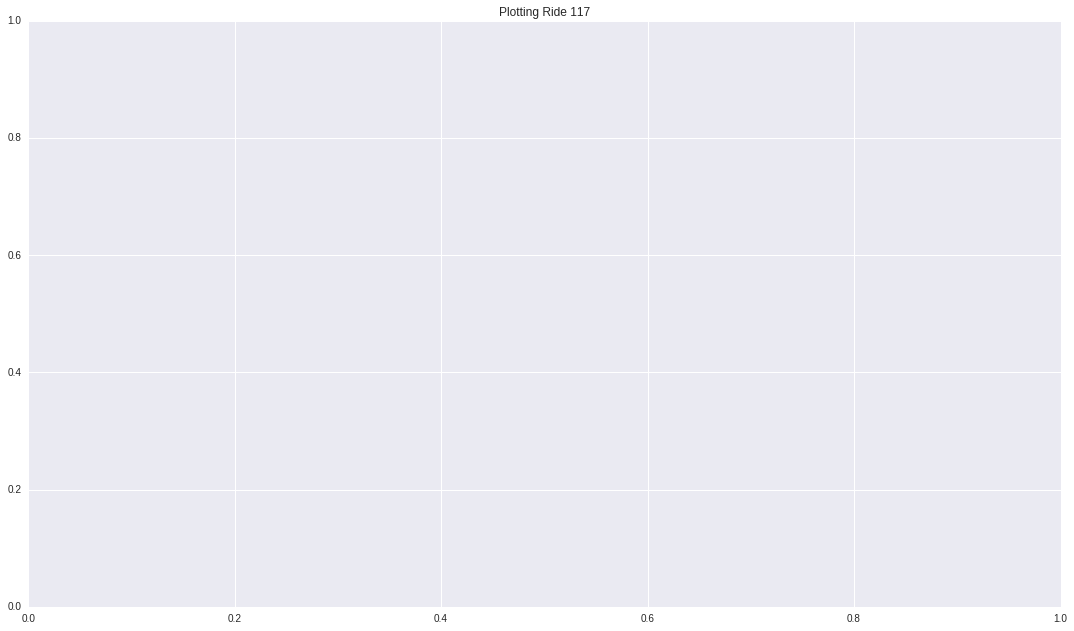

In [17]:
for random_ride_id in np.random.choice(rides.id, 100):
    for i, reading in readings.loc[readings['ride_id'] == random_ride_id, :].iterrows():
        plt.plot([reading['start_x'], reading['end_x']], [reading['start_y'], reading['end_y']])
    plt.title('Plotting Ride ' + str(random_ride_id))
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.show()

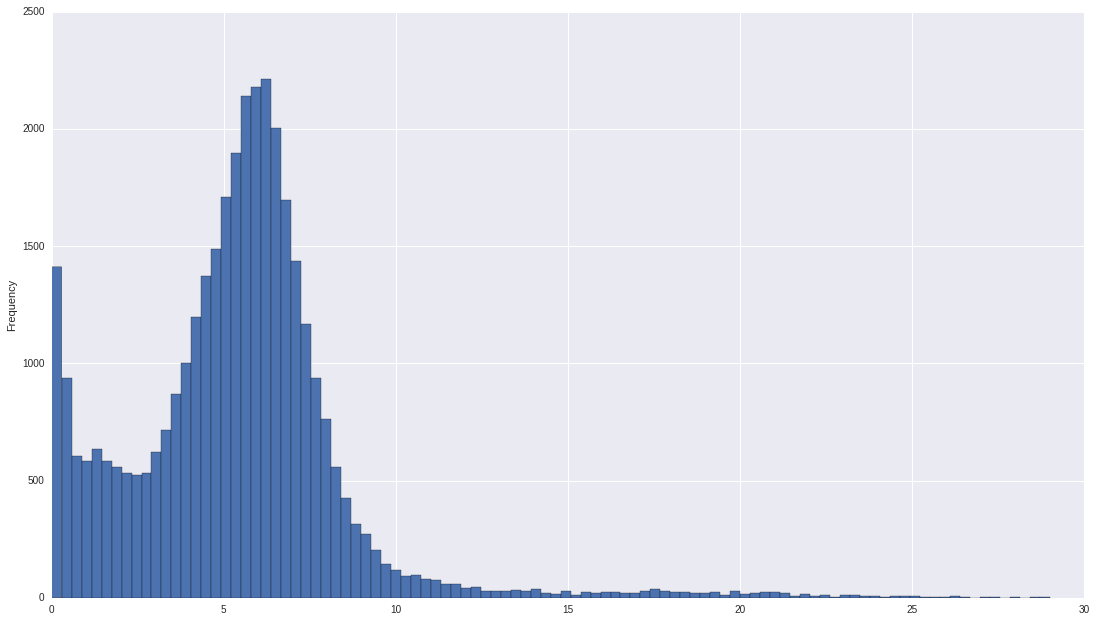

DescribeResult(nobs=35884, minmax=(0.080076318170318475, 29.923974297519049), mean=5.5731306942150241, variance=13.325615947217118, skewness=2.066897320530394, kurtosis=7.844937680198619)
0.418735713698


In [27]:
readings['gps_speed'].plot(kind='hist', bins = 100, range=(0, 29))
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()
print sp.stats.describe(readings['gps_dist'])
print np.percentile(readings['gps_dist'], 5)

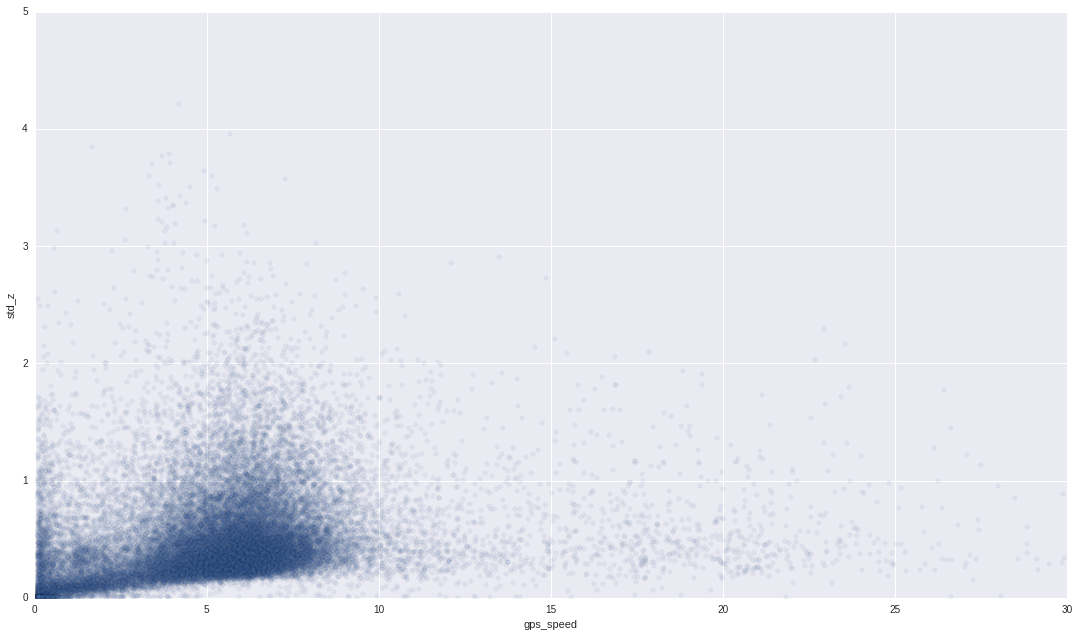

In [42]:
readings.plot(x='gps_speed', y='std_z', alpha=0.08, kind='scatter')
fig = plt.gcf()
plt.title('Relationship between Speed and Vibration')
fig.set_size_inches(18.5, 10.5)
plt.xlim(0, 30)
plt.ylim(0, 5)
plt.show()
# ax = sb.regplot(x="total_bill", y="tip", data=tips, scatter_kws={'alpha':0.3})

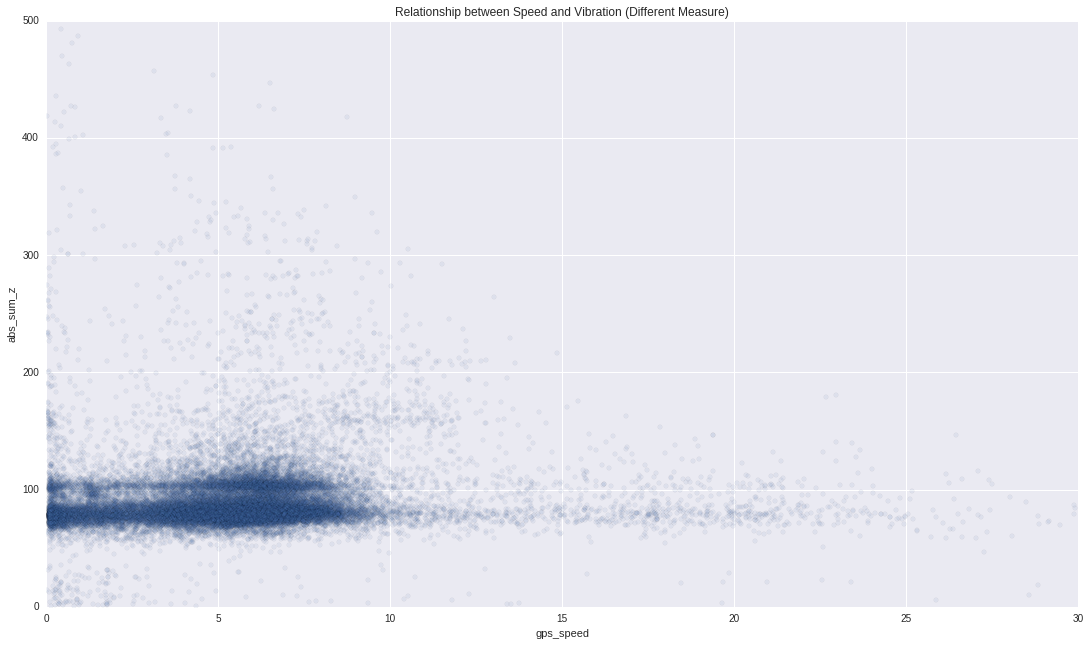

In [46]:
readings.plot(x='gps_speed', y='abs_sum_z', alpha=0.08, kind='scatter')
fig = plt.gcf()
plt.title('Relationship between Speed and Vibration (Different Measure)')
fig.set_size_inches(18.5, 10.5)
plt.xlim(0, 30)
plt.ylim(0, 500)
plt.show()
# ax = sb.regplot(x="total_bill", y="tip", data=tips, scatter_kws={'alpha':0.3})

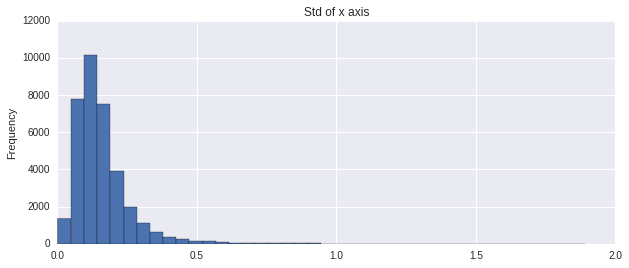

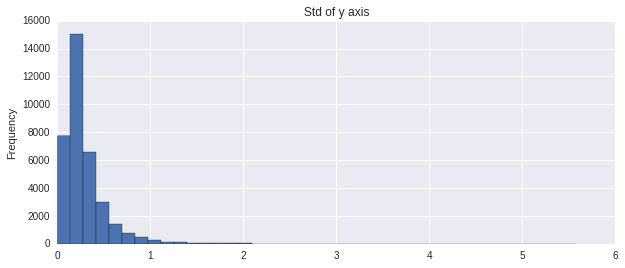

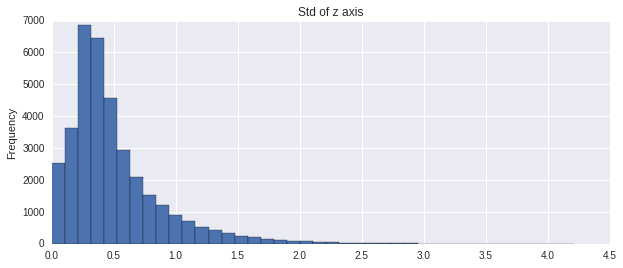

In [52]:
for axis in ['x', 'y', 'z']:
    readings['std_' + axis].plot(kind='hist', bins=40)
    fig = plt.gcf()
    fig.set_size_inches(10, 4)
    plt.title('Std of ' + axis + ' axis')
    plt.show()

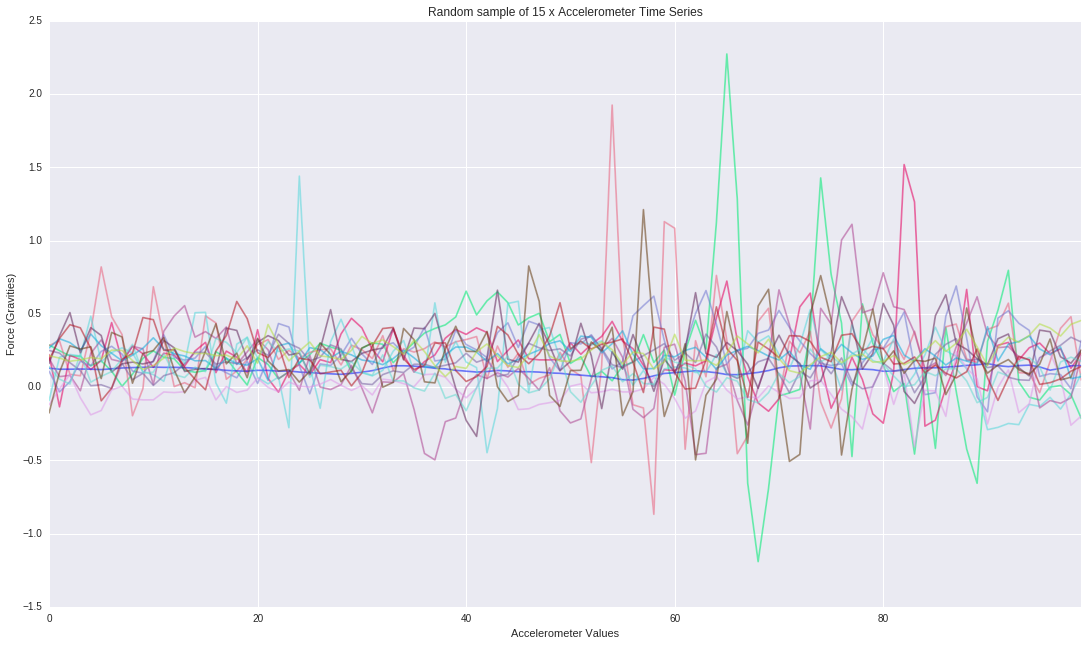

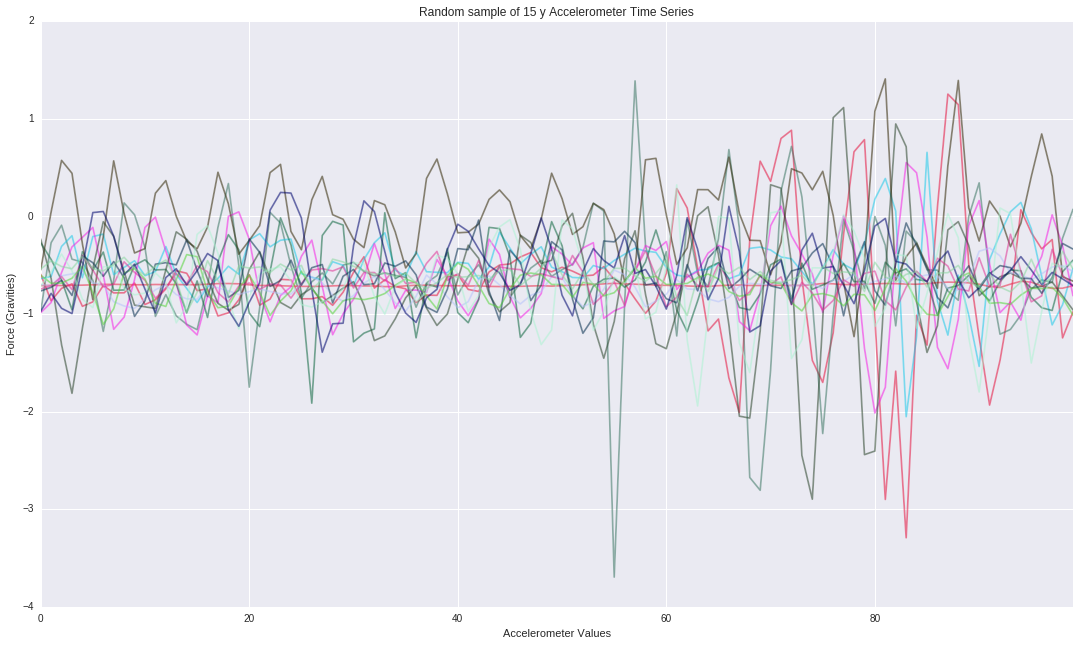

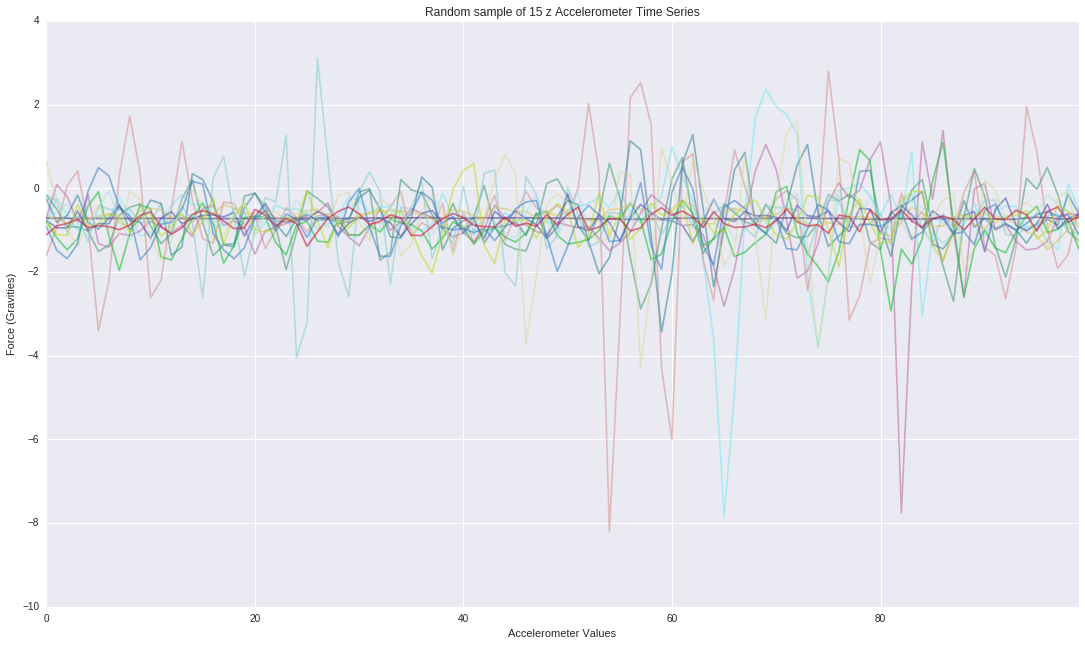

In [65]:
sample_size = 15
indices = np.random.choice(n, sample_size)
for axis in ['x', 'y', 'z']:
    for i in indices:
        sb.tsplot(readings['num_accel_' + axis][i][0:100], alpha=0.50, color=np.random.random(3))
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.xlabel('Accelerometer Values')
    plt.ylabel('Force (Gravities)')
    plt.title('Random sample of ' + str(sample_size) + ' ' + axis + ' Accelerometer Time Series')
    plt.show()

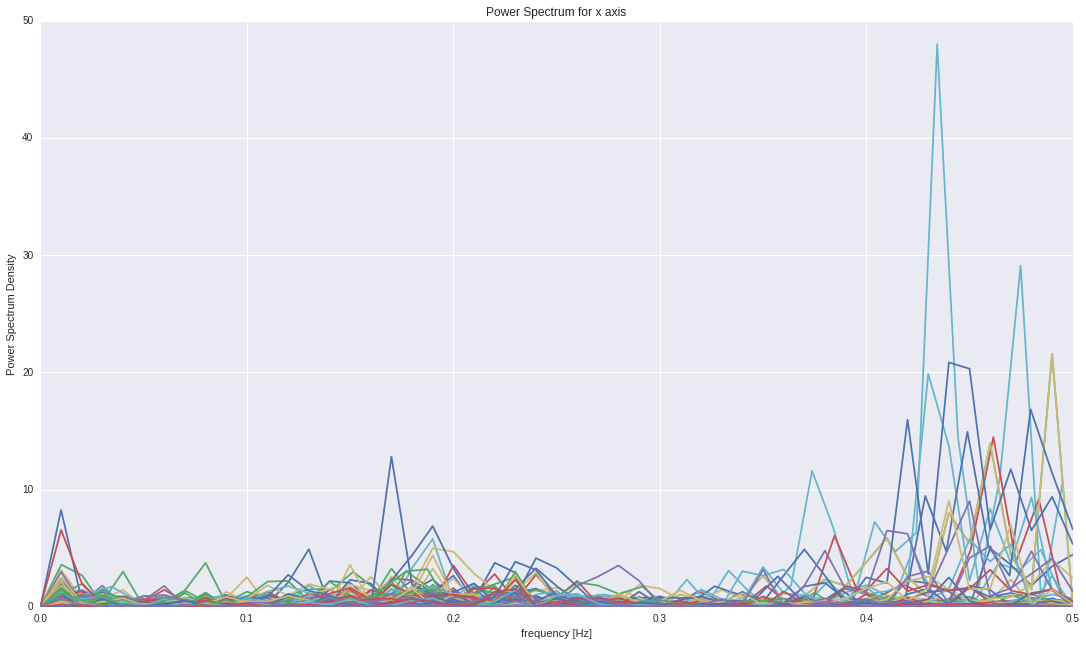

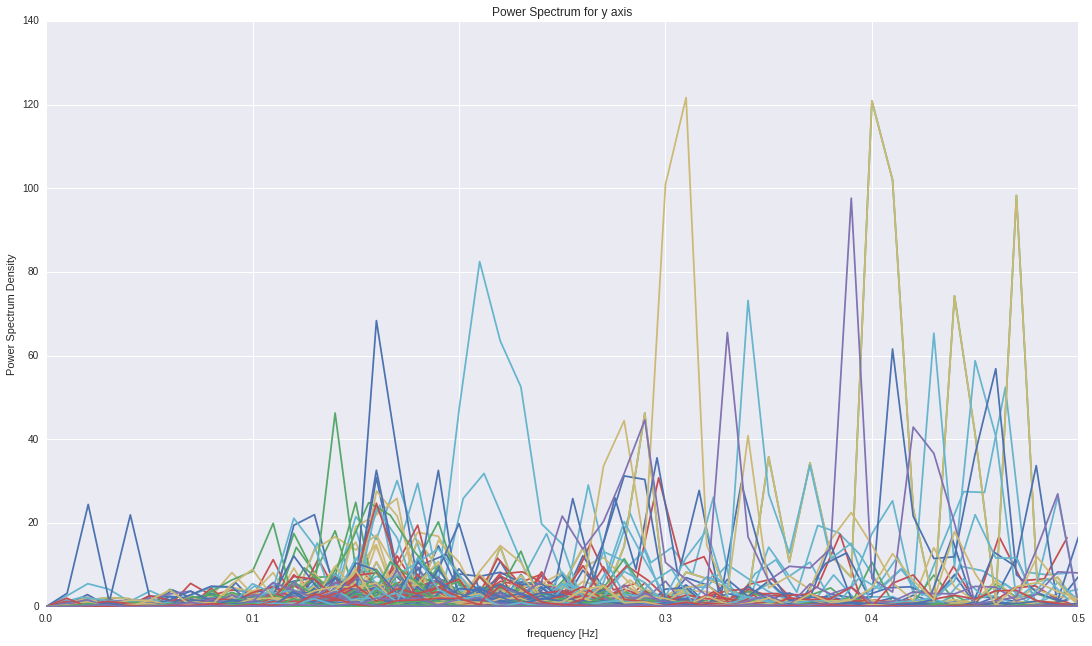

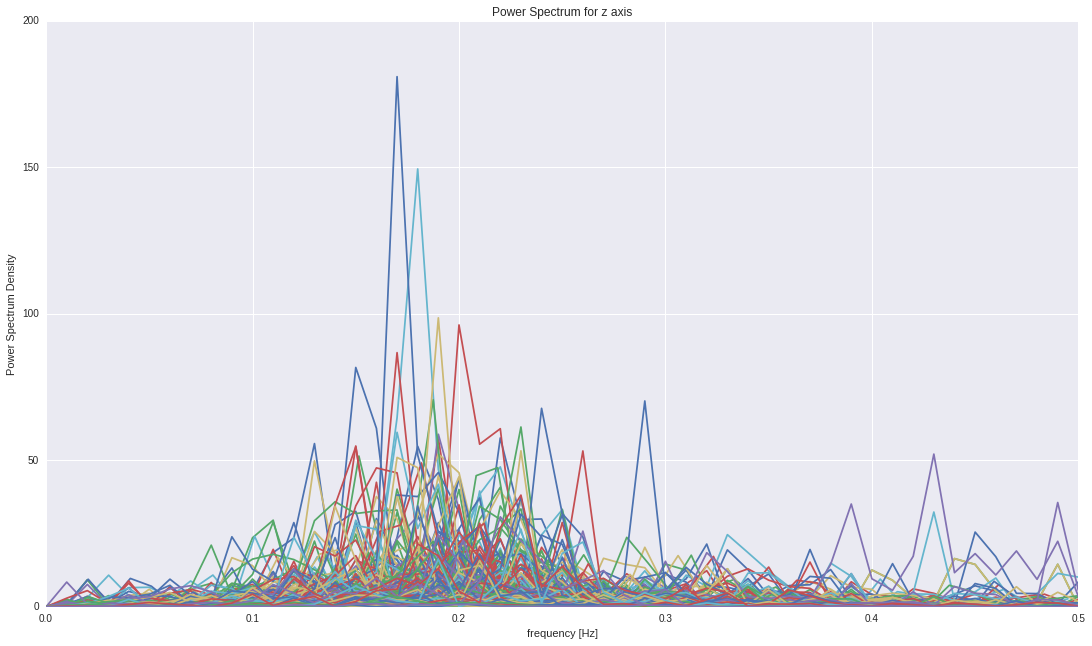

In [64]:
sample_size = 1000
indices = np.random.choice(n, sample_size)
for axis in ['x', 'y', 'z']:
    for i in indices:
        f, Pxx_den = signal.periodogram(readings['num_accel_' + axis][i][0:100])
        plt.plot(f, Pxx_den)
        plt.title('Power Spectrum for ' + axis + ' axis')
        plt.xlabel('frequency [Hz]')
        plt.ylabel('Power Spectrum Density')
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.show()